In [1]:
from math import floor

import numpy as np
import torch

from commons import *
from dgl.nn.pytorch import GATConv, EdgeConv

In [3]:
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32

def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

def calculate_HC_vectorized(s, adjacency_matrix, n):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - extend_matrix_torch(partition_prob_matrix, n))

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

def partition_weight(adj, s):
    """
    Calculates the sum of weights of edges that are in different partitions.

    :param adj: Adjacency matrix of the graph.
    :param s: List indicating the partition of each edge (0 or 1).
    :return: Sum of weights of edges in different partitions.
    """
    s = np.array(s)
    partition_matrix = np.not_equal.outer(s, s).astype(int)
    weight = (adj * extend_matrix_torch(partition_matrix, 800)).sum() / 2
    return weight

def calculateAllCut(q_torch, s):
    '''

    :param q_torch: The adjacent matrix of the graph
    :param s: The binary output from the neural network. s will be in form of [[prob1, prob2, ..., prob n], ...]
    :return: The calculated cut loss value
    '''
    if len(s) > 0:
        totalCuts = len(s[0])
        CutValue = 0
        print(q_torch.size())
        # print(s[:,i].size())
        for i in range(totalCuts):
            CutValue += partition_weight(q_torch, s[:,i])
        return int(CutValue/2)
    return 0


def printCombo(orig):
    # Original dictionary
    input_dict = orig

    # Generate all permutations of the dictionary values
    value_permutations = list(permutations(input_dict.values()))

    # Create a list of dictionaries from the permutations
    permuted_dicts = [{key: value for key, value in zip(input_dict.keys(), perm)} for perm in value_permutations]

    return permuted_dicts

def GetOptimal(net, dgl_graph, inp, q_torch, terminal = None):

    probs = net(dgl_graph, inp, terminal)
    binary_partitions = (probs >= 0.5).float()

    for i in range(len(binary_partitions)-1):
        if torch.sum(binary_partitions[i]) != 1:
            binary_partitions[i] = torch.tensor([0,1,0])

    cut_value_item = calculateAllCut(q_torch, binary_partitions)

    return cut_value_item, binary_partitions

def GetOptimalNetValue(net, dgl_graph, inp, q_torch, terminal_dict):
    net.eval()
    best_loss = float('inf')
    best_binary = []
    # if (dgl_graph.number_of_nodes() < 30):
    #     inp = torch.ones((dgl_graph.number_of_nodes(), 30))

    # find all potential combination of terminal nodes with respective indices

    perm_items = printCombo(terminal_dict)
    for i in perm_items:
        probs = net(dgl_graph, inp, i)
        binary_partitions = (probs >= 0.5).float()
        # print([m for m in binary_partitions if sum(m)>1 or sum(m)==0])
        # print(binary_partitions, q_torch)
        cut_value_item = calculateAllCut(q_torch, binary_partitions)
        if cut_value_item < best_loss:
            best_loss = cut_value_item
            best_binary = binary_partitions
    return best_loss, best_binary

In [3]:

def hyperParameters(n = 100, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 80    # e.g. 10
    hidden_dim = int(dim_embedding/2)
    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension
        # h = F.sigmoid(h)
        # h = override_fixed_nodes(h)

        return h


def extend_matrix_torch(matrix, N, torch_dtype=None, torch_device=None):
    original_size = matrix.shape[0]

    if N < original_size:
        raise ValueError("N should be greater than or equal to the original matrix size.")

    extended_matrix = torch.zeros(original_size, N)
    extended_matrix[:original_size, :original_size] = torch.from_numpy(matrix)

    if torch_dtype is not None:
        extended_matrix = extended_matrix.type(torch_dtype)

    if torch_device is not None:
        extended_matrix = extended_matrix.to(torch_device)

    return extended_matrix.numpy()

## post processor

In [4]:

def initialize_solution(graph, initial_partition, source, sink):
    # Use the initial partition if provided, otherwise create a new one
    partition = initial_partition.copy()
    partition[source] = 0
    partition[sink] = 1
    return partition

def evaluate_cut(graph, partition):
    cut_value = 0
    for u, v, weight in graph.edges(data='weight', default=1):
        if partition[u] != partition[v]:
            cut_value += weight
    return cut_value

def local_search(graph, partition, source, sink):
    improved = True
    while improved:
        improved = False
        for node in graph.nodes():
            if node == source or node == sink:
                continue
            original_partition = partition[node]
            partition[node] = 1 - partition[node]
            new_cut_value = evaluate_cut(graph, partition)
            if new_cut_value <= evaluate_cut(graph, partition):
                partition[node] = original_partition
            else:
                improved = True
    return partition

def perturb_solution(graph, partition, source, sink, perturbation_strength):
    for _ in range(perturbation_strength):
        node = random.choice(list(graph.nodes))
        if node == source or node == sink:
            continue
        partition[node] = 1 - partition[node]
    return partition

def breakout_local_search_part(graph, source, sink, initial_partition, max_iterations, perturbation_strength):
    partition = initialize_solution(graph, initial_partition, source, sink)
    best_partition = partition.copy()
    best_cut_value = evaluate_cut(graph, best_partition)

    for _ in range(max_iterations):
        partition = local_search(graph, partition, source, sink)
        current_cut_value = evaluate_cut(graph, partition)

        if current_cut_value > best_cut_value:
            best_partition = partition.copy()
            best_cut_value = current_cut_value

        partition = perturb_solution(graph, partition, source, sink, perturbation_strength)

    return best_partition, best_cut_value

def recursive_cut_bls(graph, inital_paritions, terminals, max_iterations = 50, perturbation_strength = 2):
    if len(terminals) <= 1 or graph.number_of_nodes() == 0:
        # Base case: no cut needed if only one terminal or graph is empty
        return 0, {terminals[0]: graph} if terminals else {}

    # Perform initial 2-way cut between the first two terminals
    best_cut_vale_item = 0
    best_partition_value = []
    for i in range(10):
        best_partition, best_cut_value = breakout_local_search_part(graph, terminals[0], terminals[1],inital_paritions,  max_iterations, perturbation_strength)
        if best_cut_value > best_cut_vale_item:
            best_cut_vale_item = best_cut_value
            best_partition_value = best_partition

    # cut_value, (part_1, part_2) = nx.minimum_cut(graph, terminals[0], terminals[1], flow_func=shortest_augmenting_path)
    cut_value = best_cut_vale_item
    # print(best_partition_value)
    part_1 = [key for key, value in best_partition_value.items() if value == 1]
    part_2 = [key for key, value in best_partition_value.items() if value == 0]

    graph_1, graph_2 = graph.subgraph(part_1).copy(), graph.subgraph(part_2).copy()

    # Determine which terminals are in each subgraph
    terminals_1, terminals_2 = [], []
    for terminal in terminals:
        if terminal in part_1:
            terminals_1.append(terminal)
        else:
            terminals_2.append(terminal)

    # Recursively apply cuts to each subgraph
    cut_value_1, partitions_1 = recursive_cut_bls(graph_1, inital_paritions, terminals_1)
    cut_value_2, partitions_2 = recursive_cut_bls(graph_2,inital_paritions,  terminals_2)

    # Combine the results
    total_cut_value = cut_value + cut_value_1 + cut_value_2
    partitions = partitions_1
    partitions.update(partitions_2)  # Merge the two partition dictionaries

    return total_cut_value, partitions

In [5]:
def test1(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')
    # test_item_2 = {}
    # test_item_2[0]=test_item[1]
    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():
        # embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
        # embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
        # inputs = embed.weight
        #inputs = model.embed.weight
        # cut_val, partition = GetOptimal(model,dgl_graph, inputs, adjacency_matrix, {terminal[0]:0, terminal[1]:1, terminal[2]:2})
        # neural_cut.append(cut_val)
        print(inputs, inputs.size())
        logits = net(dgl_graph, inputs)
        binary_partitions = (logits >= 0.5).float()

        # for i in range(len(binary_partitions)-1):
        #     if torch.sum(binary_partitions[i]) != 1:
        #         binary_partitions[i] = torch.tensor([1,0,0])

        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        # cut_value, (part_1, part_2) = nx.minimum_cut(test_item_2[0][2], test_item_2[0][3][1], test_item_2[0][3][0], flow_func=shortest_augmenting_path)

        print("Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break


In [6]:
def test2(modelName):
    n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=4096,patience=40)

    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 3,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience,
        'nodes':n
    }
    test_item = open_file('./testData/prepareDS.pkl')
    # test_item_2 = {}
    # test_item_2[0]=test_item[1]
    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, modelName)
    model.eval()

    i = 0
    neural_cut = []
    for key, (dgl_graph, adjacency_matrix,graph, terminal) in test_item.items():
        # embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
        # embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
        # inputs = embed.weight
        #inputs = model.embed.weight
        # cut_val, partition = GetOptimal(model,dgl_graph, inputs, adjacency_matrix, {terminal[0]:0, terminal[1]:1, terminal[2]:2})
        # neural_cut.append(cut_val)
        # print(inputs, inputs.size())
        logits = net(dgl_graph, adjacency_matrix)
        binary_partitions = (logits >= 0.5).float()

        # for i in range(len(binary_partitions)-1):
        #     if torch.sum(binary_partitions[i]) != 1:
        #         binary_partitions[i] = torch.tensor([1,0,0])

        cut = calculateAllCut(adjacency_matrix, binary_partitions)
        # print(calculateAllCut)
        totSum = np.sum(binary_partitions.numpy(), axis=0)

        # cut_value, (part_1, part_2) = nx.minimum_cut(test_item_2[0][2], test_item_2[0][3][1], test_item_2[0][3][0], flow_func=shortest_augmenting_path)

        print(i, ": number :", "Neural 3-way min-cut value: " + str(cut) + " "  +  str(totSum[0])+ " "  +  str(totSum[1])
              + " "  +  str(totSum[2])+ " Total Nodes:" + str(np.sum(totSum)))

        print("Terminalss: 0-"+ str(binary_partitions[0])+
              " 1-"+ str(binary_partitions[1])+
              "2-"+ str(binary_partitions[2]))

        invalidsCount = [m for m in binary_partitions if sum(m)!=1]
        print("Invalids Nodes: " + str( len(invalidsCount)))


        print("---------- \n")
        i+=1

        if (i>10):
            break


# Exp1 results testting

In [52]:
# nx_generated_graph = {}
#
# for i in range (200):
#     nx_graph = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=i)
#
#     for u, v, d in nx_graph.edges(data=True):
#         d['weight'] = 1
#         d['capacity'] = 1
#
#     graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
#     graph_dgl = graph_dgl.to(TORCH_DEVICE)
#     q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
#     terminals = [10,40,70]
#     nx_generated_graph[i] = [graph_dgl, q_torch, nx_graph, terminals]

nx_graph = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=300)
for u, v, d in nx_graph.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating d-regular graph with n=80, d=3, seed=300


In [53]:
t_gnn_start = time()
def hyperParameters(n = 80, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 80 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=80,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__80MaxwayCut_LossExp1_loss.pth')
model.eval()

logits = net(graph_dgl, q_torch)
#logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()
cut = calculateAllCut(q_torch, binary_partitions)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 10-"+ str(binary_partitions[0])+
      " 70-"+ str(binary_partitions[1]) + " 40-"+ str(binary_partitions[2]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))
print(binary_partitions)

t_gnn = time() - t_gnn_start
print("Total Time: ", t_gnn)

cut val:tensor(103., dtype=torch.float64) node Sum [21. 33. 26.]
Terminalss: 10-tensor([0., 0., 1.]) 70-tensor([0., 1., 0.]) 40-tensor([0., 0., 1.])
Invalids Nodes: 0
tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.

In [38]:
def postProcessing(binary_partitions, graph, terminals):
    initial_parition = {}
    for i in range(len(binary_partitions)):
        #val = ((binary_partitions == 2).nonzero(as_tuple=True)[0])
        initial_parition[i] = binary_partitions[i].index(1)
    cut_val, partitions = recursive_cut_bls(graph, initial_parition, terminals, 10, 2)
    return cut_val, partitions, initial_parition

In [55]:
t_gnn_start = time()
cut_val, partitions, val = postProcessing(binary_partitions.tolist(), nx_graph, [10,40,70])
# lst = []
# for i in range(80):
#     lst.append([0,0,0])
#
# for n in    partitions[40].nodes:
#     lst[n] = [1,0,0]
# for n in    partitions[10].nodes:
#     lst[n] = [0,1,0]
# for n in    partitions[70].nodes:
#     lst[n] = [0,0,1]
#
# q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
# cut = calculateAllCut(q_torch, torch.Tensor(lst))
t_gnn = time() - t_gnn_start
cut_val, t_gnn

(111, 0.7270548343658447)

## Exp 2 - loss

- expriment 2 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- graph n=500, d=3

In [56]:
# nx_generated_graph = {}
#
# for i in range (200):
#     nx_graph = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=i)
#
#     for u, v, d in nx_graph.edges(data=True):
#         d['weight'] = 1
#         d['capacity'] = 1
#
#     graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
#     graph_dgl = graph_dgl.to(TORCH_DEVICE)
#     q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
#     terminals = [10,40,70]
#     nx_generated_graph[i] = [graph_dgl, q_torch, nx_graph, terminals]

nx_graph = generate_graph(n=500, d=3, p=None, graph_type='reg', random_seed=300)
for u, v, d in nx_graph.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating d-regular graph with n=500, d=3, seed=300


In [60]:
t_gnn_start = time()
def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[100] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[10] - h[10].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[300] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[40] - h[40].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[450] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[70] - h[70].detach()
    return output
def hyperParameters(n = 80, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 500 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=500,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__80MaxwayCut_LossExp2_loss.pth')
model.eval()

logits = net(graph_dgl, q_torch)
logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()
cut = calculateAllCut(q_torch, binary_partitions)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 100-"+ str(binary_partitions[0])+
      " 300-"+ str(binary_partitions[1]) + " 450-"+ str(binary_partitions[2]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))
print(binary_partitions)

t_gnn = time() - t_gnn_start
print("Total Time: ", t_gnn)

cut val:tensor(644., dtype=torch.float64) node Sum [168. 169. 163.]
Terminalss: 100-tensor([1., 0., 0.]) 300-tensor([0., 1., 0.]) 450-tensor([1., 0., 0.])
Invalids Nodes: 0
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])
Total Time:  0.2388019561767578


In [61]:
t_gnn_start = time()
cut_val, partitions, val = postProcessing(binary_partitions.tolist(), nx_graph, [100,300,450])

t_gnn_2 = time() - t_gnn_start
cut_val, t_gnn_2

(669, 24.739663124084473)

In [62]:
print("GNN time: ", t_gnn)
print("post-processing time: ", t_gnn_2)
print("Total time: ", t_gnn+t_gnn_2)
print("GNN cut value: ", cut)
print("GNN +  hurestics cut value: ", cut_val)

GNN time:  0.2388019561767578
post-processing time:  24.739663124084473
Total time:  24.97846508026123
GNN cut value:  tensor(644., dtype=torch.float64)
GNN +  hurestics cut value:  669


## Exp 3 - loss

- expriment 3 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- graph n=1000, d=3

In [66]:
# nx_generated_graph = {}
#
# for i in range (200):
#     nx_graph = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=i)
#
#     for u, v, d in nx_graph.edges(data=True):
#         d['weight'] = 1
#         d['capacity'] = 1
#
#     graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
#     graph_dgl = graph_dgl.to(TORCH_DEVICE)
#     q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
#     terminals = [10,40,70]
#     nx_generated_graph[i] = [graph_dgl, q_torch, nx_graph, terminals]

nx_graph = generate_graph(n=1000, d=3, p=None, graph_type='reg', random_seed=300)
for u, v, d in nx_graph.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating d-regular graph with n=1000, d=3, seed=300


In [77]:
t_gnn_start = time()
def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[200] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[200] - h[200].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[400] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[400] - h[400].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[700] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[700] - h[700].detach()
    return output
def hyperParameters(n = 80, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 1000 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=1000,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__10000MaxwayCut_LossExp3_loss.pth')
model.eval()

logits = net(graph_dgl, q_torch)
# logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()

for i in range(len(binary_partitions)):
    if sum(binary_partitions[i]) != 1:
        binary_partitions[i] = torch.Tensor([1,0,0])

cut = calculateAllCut(q_torch, binary_partitions)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 200-"+ str(binary_partitions[200])+
      " 400-"+ str(binary_partitions[400]) + " 700-"+ str(binary_partitions[700]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))
print(binary_partitions)

t_gnn = time() - t_gnn_start
print("Total Time: ", t_gnn)

cut val:tensor(1278., dtype=torch.float64) node Sum [337. 328. 335.]
Terminalss: 200-tensor([1., 0., 0.]) 400-tensor([0., 1., 0.]) 700-tensor([0., 0., 1.])
Invalids Nodes: 0
tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        ...,
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])
Total Time:  0.4560580253601074


In [78]:
t_gnn_start = time()
cut_val, partitions, val = postProcessing(binary_partitions.tolist(), nx_graph, [200,400,700])

t_gnn_2 = time() - t_gnn_start
cut_val, t_gnn_2

(1315, 98.21178483963013)

## Exp 4 - loss

- expriment 4 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- graph n=500, d=6-8

In [91]:
# nx_generated_graph = {}
#
# for i in range (200):
#     nx_graph = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=i)
#
#     for u, v, d in nx_graph.edges(data=True):
#         d['weight'] = 1
#         d['capacity'] = 1
#
#     graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
#     graph_dgl = graph_dgl.to(TORCH_DEVICE)
#     q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
#     terminals = [10,40,70]
#     nx_generated_graph[i] = [graph_dgl, q_torch, nx_graph, terminals]

datasetItem = open_file('./testData/nx_generated_graph_n500_d6_8_t300.pkl')


In [104]:
t_gnn_start = time()
def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output
def hyperParameters(n = 80, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 500 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=500,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__500MaxwayCut_LossExp4_loss.pth')
model.eval()

(dgl_graph, adjacency_matrix,graph, terminals) = datasetItem[0]
print(graph)
logits = net(dgl_graph, adjacency_matrix)
# logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()

for i in range(len(binary_partitions)):
    if sum(binary_partitions[i]) != 1:
        binary_partitions[i] = torch.Tensor([1,0,0])

cut = calculateAllCut(adjacency_matrix, binary_partitions)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 200-"+ str(binary_partitions[0])+
      " 400-"+ str(binary_partitions[1]) + " 700-"+ str(binary_partitions[2]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))
print(binary_partitions)

t_gnn = time() - t_gnn_start
print("Total Time: ", t_gnn)

Graph with 500 nodes and 1750 edges
cut val:tensor(1591., dtype=torch.float64) node Sum [167. 172. 161.]
Terminalss: 200-tensor([1., 0., 0.]) 400-tensor([0., 0., 1.]) 700-tensor([0., 0., 1.])
Invalids Nodes: 0
tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]])
Total Time:  0.10285115242004395


In [109]:
def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss
print(calculate_HC_vectorized(binary_partitions, adjacency_matrix))

tensor(1591.)


In [110]:
t_gnn_start = time()
cut_val, partitions, val = postProcessing(binary_partitions.tolist(), graph, [0,1,2])

t_gnn_2 = time() - t_gnn_start
cut_val, t_gnn_2

(1622, 48.0912070274353)

In [113]:
lst = []
for i in range(500):
    lst.append([0,0,0])

for n in    partitions[0].nodes:
    lst[n] = [0,1,0]
for n in    partitions[1].nodes:
    lst[n] = [0,0,1]
for n in    partitions[2].nodes:
    lst[n] = [1,0,0]

cut = calculateAllCut(adjacency_matrix, torch.Tensor(lst))
cut

tensor(1108., dtype=torch.float64)

## Exp 5 - loss

- expriment 5 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- graph n=500, d=6-8

In [115]:
# nx_generated_graph = {}
#
# for i in range (200):
#     nx_graph = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=i)
#
#     for u, v, d in nx_graph.edges(data=True):
#         d['weight'] = 1
#         d['capacity'] = 1
#
#     graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
#     graph_dgl = graph_dgl.to(TORCH_DEVICE)
#     q_torch = qubo_dict_to_torch(nx_graph, gen_adj_matrix(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
#     terminals = [10,40,70]
#     nx_generated_graph[i] = [graph_dgl, q_torch, nx_graph, terminals]

datasetItem = open_file('./testData/nx_generated_graph_n500_200_d6_8_t300.pkl')


In [126]:
t_gnn_start = time()
def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output
def hyperParameters(n = 80, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 500 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=800,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__500MaxwayCut_LossExp5_loss.pth')
model.eval()

(dgl_graph, adjacency_matrix,graph, terminals) = datasetItem[0]
print(graph)
logits = net(dgl_graph, adjacency_matrix)
# logits = override_fixed_nodes(logits)
binary_partitions = (logits >= 0.5).float()

for i in range(len(binary_partitions)):
    if sum(binary_partitions[i]) != 1:
        binary_partitions[i] = torch.Tensor([1,0,0])

# cut = calculateAllCut(adjacency_matrix, binary_partitions)
cut = calculate_HC_vectorized(binary_partitions, adjacency_matrix)
totSum = np.sum(binary_partitions.numpy(), axis=0)
print('cut val:' + str(cut), 'node Sum', totSum)
print("Terminalss: 200-"+ str(binary_partitions[0])+
      " 400-"+ str(binary_partitions[1]) + " 700-"+ str(binary_partitions[2]))
invalidsCount = [m for m in binary_partitions if sum(m)!=1]
print("Invalids Nodes: " + str( len(invalidsCount)))
print(binary_partitions)

t_gnn = time() - t_gnn_start
print("Total Time: ", t_gnn)

Graph with 332 nodes and 996 edges


TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

In [ ]:
def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - partition_prob_matrix)

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss
print(calculate_HC_vectorized(binary_partitions, adjacency_matrix))

In [88]:
# Export the graph to a CSV file
with open('./exp4_graph_dat.csv', 'w') as f:
    f.write('i,j,weight\n')
    for u, v, data in graph.edges(data=True):
        f.write(f'{u},{v},{data["weight"]}\n')

In [ ]:
t_gnn_start = time()
cut_val, partitions, val = postProcessing(binary_partitions.tolist(), graph, [0,1,2])

t_gnn_2 = time() - t_gnn_start
cut_val, t_gnn_2

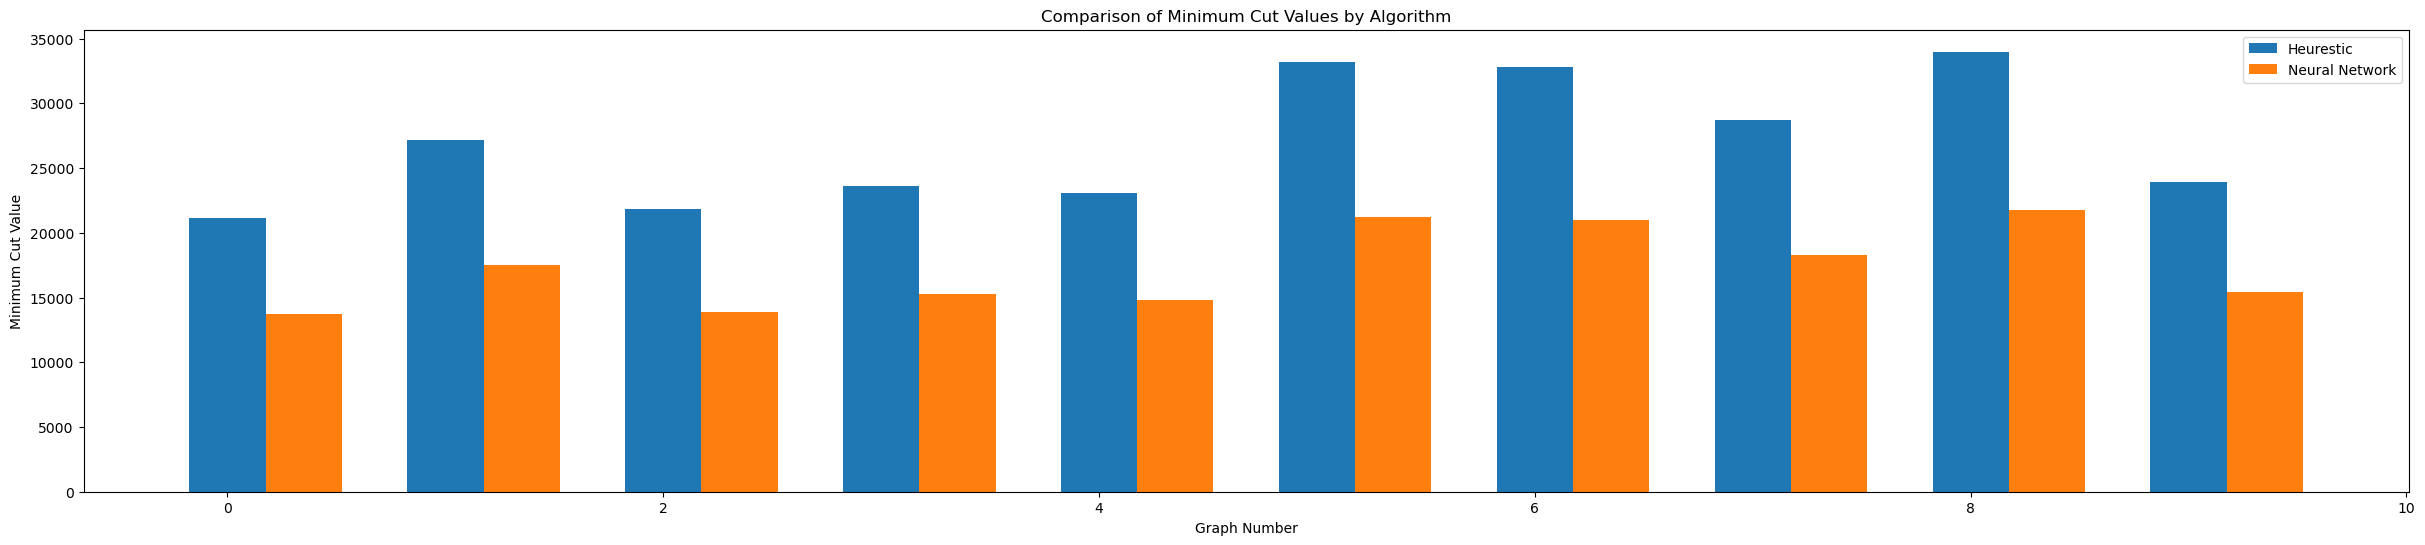

In [56]:
barPlot_2( heurestic_cut_k, neural_cut)

In [ ]:


cut = calculateAllCut(adjacency_matrix, binary_partitions)

## Exp 7 - loss

- expriment 7 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- graph n=500-800, d=6-8

In [57]:
datasetItem = open_file('./testData/NX_testingGraph_800.pkl')

In [58]:
from time import time
t_gnn_start = time()
def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output
def hyperParameters(n = 80, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 800 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=800,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__800MaxwayCut_LossExp7_loss.pth')
model.eval()

# (dgl_graph, adjacency_matrix,graph, terminals) = datasetItem[0]

All_cut = []

for key, (dgl_graph, adjacency_matrix,graph, terminals) in datasetItem.items():
    print(graph)
    logits = net(dgl_graph, adjacency_matrix)
    # logits = override_fixed_nodes(logits)
    binary_partitions = (logits >= 0.5).float()

    for i in range(len(binary_partitions)):
        if sum(binary_partitions[i]) != 1:
            binary_partitions[i] = torch.Tensor([1,0,0])
    binary_partitions[0] =  torch.Tensor([1,0,0])
    binary_partitions[1] =  torch.Tensor([0,1,0])
    binary_partitions[2] =  torch.Tensor([0,0,1])
    cut = calculateAllCut(adjacency_matrix, binary_partitions)
    totSum = np.sum(binary_partitions.numpy(), axis=0)
    print("---------", key, "----------")
    print('cut val:' + str(cut), 'node Sum', totSum)
    print("Terminalss: 0-"+ str(binary_partitions[0])+
          " 2-"+ str(binary_partitions[1]) + " 1-"+ str(binary_partitions[2]))
    invalidsCount = [m for m in binary_partitions if sum(m)!=1]
    print("Invalids Nodes: " + str( len(invalidsCount)))
    # print(binary_partitions)

    t_gnn = time() - t_gnn_start
    print("Total Time: ", t_gnn)
    All_cut.append(cut)

Graph with 681 nodes and 2724 edges
torch.Size([681, 800])
--------- 0 ----------
cut val:1966 node Sum [245. 212. 224.]
Terminalss: 0-tensor([1., 0., 0.]) 2-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])
Invalids Nodes: 0
Total Time:  0.2413930892944336
Graph with 701 nodes and 2804 edges
torch.Size([701, 800])
--------- 1 ----------
cut val:2030 node Sum [225. 241. 235.]
Terminalss: 0-tensor([1., 0., 0.]) 2-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])
Invalids Nodes: 0
Total Time:  0.506723165512085
Graph with 724 nodes and 2896 edges
torch.Size([724, 800])
--------- 2 ----------
cut val:2046 node Sum [248. 226. 250.]
Terminalss: 0-tensor([1., 0., 0.]) 2-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])
Invalids Nodes: 0
Total Time:  0.5649631023406982
Graph with 680 nodes and 2040 edges
torch.Size([680, 800])
--------- 3 ----------
cut val:1488 node Sum [244. 210. 226.]
Terminalss: 0-tensor([1., 0., 0.]) 2-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])
Invalids Nodes: 0
Total Time:  0.6456458568

In [11]:
def calculate_HC_vectorized(s, adjacency_matrix, n):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    print(adjacency_matrix.size(), extend_matrix_torch(partition_prob_matrix, n).size())
    cut_value = adjacency_matrix * (1 - extend_matrix_torch(partition_prob_matrix, n))

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

In [82]:
t_gnn_start = time()
cut_val, partitions, val = postProcessing(binary_partitions.tolist(), graph, [0,1,2])

t_gnn_2 = time() - t_gnn_start
cut_val, t_gnn_2

(2203, 105.47462010383606)

In [88]:
# lst = []
for i in range(784):
    lst.append([0,0,0])

for n in partitions[0].nodes:
    lst[n] = [0,1,0]
for n in    partitions[1].nodes:
    lst[n] = [0,0,1]
for n in    partitions[2].nodes:
    lst[n] = [1,0,0]

cut = calculateAllCut(adjacency_matrix, torch.Tensor(lst))
cut, partitions, lst

ValueError: setting an array element with a sequence.

In [10]:
graph.number_of_nodes()

784

In [148]:
for key, (dgl_graph, adjacency_matrix,graph, terminals) in datasetItem.items():
    with open(f'./test_graph{key}.csv',  'w') as f:
        f.write('i,j,weight\n')
        for u, v, data in graph.edges(data=True):
            f.write(f'{u},{v},{data["weight"]}\n')

In [53]:
import numpy as np
import random
import time
import networkx as nx

def simulated_annealing_hard_partitions(init_temperature: int, num_steps: int, graph: nx.Graph, nn_output: np.array, terminal_1: int, terminal_2: int, terminal_3: int) -> (int, list):
    num_nodes = graph.number_of_nodes()
    # Convert neural network output to initial solution directly
    curr_solution = np.argmax(nn_output, axis=1)  # Each node has a hard assignment to a partition

    # Function to calculate the 3-way cut value
    def obj_maxcut_3way(solution, graph):
        cut_value = 0
        for u, v, data in graph.edges(data=True):
            if solution[u] != solution[v]:
                cut_value += data.get('weight', 1)  # Assuming weight attribute is correct
        return cut_value

    curr_score = obj_maxcut_3way(curr_solution, graph)
    init_score = curr_score
    scores = [curr_score]
    start_time = time.time()

    terminals = [terminal_1, terminal_2, terminal_3]  # List of terminals that should not change partitions

    for k in range(num_steps):
        temperature = init_temperature * (1 - (k + 1) / num_steps)
        idx = np.random.randint(0, num_nodes)

        # Skip iteration if the selected node is a terminal
        if idx in terminals:
            continue
        if temperature == 0:
            continue

        new_solution = curr_solution.copy()
        current_partition = curr_solution[idx]
        new_partition = (current_partition + 1) % 3  # Propose a new partition by cycling

        # Only accept the new partition if it's different from the current one
        if new_partition != current_partition:
            new_solution[idx] = new_partition
            new_score = obj_maxcut_3way(new_solution, graph)
            delta_e = new_score - curr_score

            if delta_e > 0 or np.exp(delta_e / temperature) > random.random():
                curr_solution = new_solution
                curr_score = new_score
                scores.append(curr_score)

    running_duration = time.time() - start_time
    print(f"Simulated annealing completed in {running_duration:.2f} seconds")
    return curr_score, curr_solution.tolist(), scores

# Example usage:
# nn_output = np.array([...])  # This should be the output from your neural network after hard assignments
# graph = nx.some_graph_function()
# terminal_1, terminal_2, terminal_3 = 0, 1, 2  # Example terminals
# final_score, final_solution, score_history = simulated_annealing_hard_partitions(100, 1000, graph, nn_output, terminal_1, terminal_2, terminal_3)


In [56]:
nn_output = np.array(binary_partitions)
terminal_1, terminal_2, terminal_3 = 0, 1, 2  # Example terminals
final_score, final_solution, score_history = simulated_annealing_hard_partitions(100, 50000, graph, nn_output, terminal_1, terminal_2, terminal_3)

Simulated annealing completed in 33.91 seconds


In [84]:
import networkx as nx
import numpy as np
import random
import time
import copy
from typing import List, Union

lst = np.zeros(784)
for i in range(784):
    for n in partitions[0].nodes:
        lst[n]=0
    for n in   partitions[1].nodes:
        lst[n]=1
    for n in    partitions[2].nodes:
        lst[n]=2
lst

array([0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 2., 1., 0., 0., 0., 1., 0., 2., 1., 0., 1., 0., 1., 2., 0., 2.,
       1., 1., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 1., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 2., 1., 0., 0., 2., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 2., 0., 1., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1., 2.,
       0., 2., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 2., 0., 0., 2.,
       1., 1., 0., 0., 2., 0., 2., 1., 1., 0., 1., 1., 0., 0., 0., 2., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1.

In [78]:

def simulated_annealing(init_temperature, num_steps, graph, terminal_1, terminal_2, terminal_3, lst) :
    print('simulated_annealing')

    num_nodes = graph.number_of_nodes()

    # Initialize solution: Create 3 partitions, ensure terminals are in different partitions
    init_solution = [0] * (num_nodes // 3) + [1] * (num_nodes // 3) + [2] * (num_nodes - 2 * (num_nodes // 3))

    # Ensure terminal_1, terminal_2, and terminal_3 are in different partitions
    init_solution[terminal_1] = 0
    init_solution[terminal_2] = 1
    init_solution[terminal_3] = 2

    start_time = time.time()
    curr_solution = copy.deepcopy(lst)
    curr_score = obj_maxcut_3way(curr_solution, graph)  # You will need a function to calculate the 3-way cut value
    init_score = curr_score
    scores = []
    k = 0
    while k < num_steps:
        # for k in range(num_steps):
        # The temperature decreases
        temperature = init_temperature * (1 - (k + 1) / num_steps)
        new_solution = copy.deepcopy(curr_solution)

        # Choose a random node to change its partition
        idx = np.random.randint(0, num_nodes)

        # Ensure terminals remain in different partitions
        if idx in [terminal_1, terminal_2, terminal_3]:
            continue
        else:
            k+=1

        # Update the partition of the chosen node (cycle through 0, 1, 2)
        new_solution[idx] = (new_solution[idx] + 1) % 3

        new_score = obj_maxcut_3way(new_solution, graph)
        scores.append(new_score)
        delta_e = curr_score - new_score


        if k%100 == 0:
            print("scores: ", new_score, "Iteration: ", k)

        if delta_e < 0:
            curr_solution = new_solution
            curr_score = new_score
        else:
            prob = np.exp(- delta_e / (temperature + 1e-6))
            if prob > random.random():
                curr_solution = new_solution
                curr_score = new_score

    print("score, init_score of simulated_annealing", curr_score, init_score)
    # print("scores: ", scores)
    print("solution: ", curr_solution)
    running_duration = time.time() - start_time
    print('running_duration: ', running_duration)

    return curr_score, curr_solution, scores

# Function to calculate the 3-way cut value
def obj_maxcut_3way(solution, graph):
    cut_value = 0
    for u, v, data in graph.edges(data=True):
        if solution[u] != solution[v]:
            cut_value += data.get('weight', 1)  # Assuming unweighted graph by default, otherwise use edge weights
    return cut_value

In [79]:
score, solution, scores = simulated_annealing(init_temperature=1000, num_steps=10000, graph=graph, terminal_1=0, terminal_2=1, terminal_3=2, lst=lst)

simulated_annealing
scores:  1617 Iteration:  100
scores:  1556 Iteration:  200
scores:  1569 Iteration:  300
scores:  1562 Iteration:  400
scores:  1540 Iteration:  500
scores:  1550 Iteration:  600
scores:  1581 Iteration:  700
scores:  1587 Iteration:  800
scores:  1558 Iteration:  900
scores:  1525 Iteration:  1000
scores:  1546 Iteration:  1100
scores:  1576 Iteration:  1200
scores:  1578 Iteration:  1300
scores:  1568 Iteration:  1400
scores:  1578 Iteration:  1500
scores:  1555 Iteration:  1600
scores:  1569 Iteration:  1700
scores:  1571 Iteration:  1800
scores:  1555 Iteration:  1900
scores:  1582 Iteration:  2000
scores:  1564 Iteration:  2100
scores:  1584 Iteration:  2200
scores:  1573 Iteration:  2300
scores:  1566 Iteration:  2400
scores:  1566 Iteration:  2500
scores:  1574 Iteration:  2600
scores:  1559 Iteration:  2700
scores:  1567 Iteration:  2800
scores:  1567 Iteration:  2900
scores:  1571 Iteration:  3000
scores:  1596 Iteration:  3100
scores:  1611 Iteration:  32

In [89]:
(dgl_graph_2, adjacency_matrix_2,graph_2, terminals_2) = datasetItem[5]

In [91]:
graph_2.number_of_nodes()

796

In [92]:
# Export the graph to a CSV file
with open('./exp7_796_graph_dat.csv', 'w') as f:
    f.write('i,j,weight\n')
    for u, v, data in graph_2.edges(data=True):
        f.write(f'{u},{v},{data["weight"]}\n')

In [95]:
graph_2.number_of_edges()

2786

In [102]:
lst_partitions = []
for i in binary_partitions:
    print(i, i.tolist().index(1))
    lst_partitions.append(i.tolist().index(1))

tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([0., 0., 1.]) 2
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([0., 0., 1.]) 2
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([0., 1., 0.]) 1
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([0., 1., 0.]) 1
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([0.,

In [103]:
lst_partitions

[0,
 1,
 2,
 2,
 0,
 2,
 0,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 2,
 2,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 2,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 0,
 1,
 2,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 2,


In [104]:
with open('./exp7_796_partition_dat.csv', 'w') as f:
    for i in lst_partitions:
        f.write(f'{i}\n')

In [111]:
cplex_list = [0, 1, 2, 2, 0, 2, 0, 1, 0, 2, 1, 2, 2, 1, 1, 1, 0, 1, 0, 2, 0, 1, 2, 0, 0, 2, 2, 1, 1, 0, 0, 2, 0, 1, 1, 2, 0,
              2, 0, 1, 2, 0, 2, 1, 0, 1, 0, 0, 1, 1, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 1, 2, 0, 0,
              1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 1, 0, 2, 0, 2, 1, 0, 2, 0, 1, 2, 1,
              0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 0, 0, 0,
              1, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 1, 0, 2, 2, 0, 2, 1, 1, 1,
              2, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 2, 2, 1, 2, 0, 2,
              0, 2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 1, 1, 2, 1, 1, 0,
              2, 0, 2, 2, 1, 0, 0, 2, 1, 2, 2, 0, 2, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1, 0, 1, 2, 2, 0, 2, 2,
              1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 2, 1, 0, 1, 2, 0, 2, 2, 1, 2, 0, 2, 0, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 0,
              2, 2, 2, 2, 0, 2, 0, 1, 0, 1, 0, 2, 1, 0, 0, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0, 2, 1, 2, 2, 0,
              0, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1, 2, 0, 2, 0, 1, 1, 2, 1, 0, 2,
              1, 2, 1, 0, 0, 2, 2, 0, 1, 2, 0, 1, 2, 1, 2, 0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 0, 0,
              2, 1, 0, 1, 0, 2, 0, 2, 0, 2, 1, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 0, 1, 0, 1,
              0, 2, 2, 1, 0, 2, 0, 0, 1, 2, 2, 1, 1, 0, 1, 0, 2, 1, 2, 1, 2, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 2, 1, 1, 0,
              1, 1, 2, 1, 1, 0, 1, 0, 1, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 2, 2, 0, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 0,
              2, 0, 1, 0, 1, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, 0, 1, 1, 0, 2, 0, 2, 1, 1, 0, 2,
              0, 2, 2, 0, 2, 0, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1,
              1, 2, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 0, 0, 1, 0, 2, 0, 1,
              1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 0, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 0,
              2, 0, 1, 1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 2,
              2, 1, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 0, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0, 1, 2, 1, 0, 0, 0, 2, 2, 1, 1, 2, 1,
              1, 2, 0, 0, 2, 1, 2, 0, 1, 2, 2, 0, 0, 2, 1, 0, 2, 2, 0, 2, 2, 1, 0, 1, 1, 2, 1, 1, 1, 0, 2, 2, 0, 0, 1,
              0, 2, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 2, 2, 1, 2, 2, 0, 1]

len(cplex_list)

796

In [112]:

def obj_maxcut_3way(solution, graph):
    cut_value = 0
    for u, v, data in graph.edges(data=True):
        if solution[u] != solution[v]:
            cut_value += data.get('weight', 1)  # Assuming weight attribute is correct
    return cut_value

In [113]:
obj_maxcut_3way(cplex_list, graph_2)

2531

In [122]:
new_lst = []

for i in range(796):
    new_lst.append([0,0,0])

    if cplex_list[i] == 0:
        new_lst[i][0] = 1
    elif cplex_list[i] == 1:
        new_lst[i][1] = 1
    elif cplex_list[i] == 2:
        new_lst[i][2] = 1

cut = calculateAllCut(adjacency_matrix_2, torch.Tensor(new_lst))
cut, partitions#, new_lst

torch.Size([796, 800])


(2531,
 {1: <networkx.classes.graph.Graph at 0x28f92e740>,
  2: <networkx.classes.graph.Graph at 0x298739f60>,
  0: <networkx.classes.graph.Graph at 0x298739de0>})

In [116]:
def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Compute the minimum cut loss, which is the total weight of edges cut between partitions using vectorized operations.

    Parameters:
    s (torch.Tensor): Binary partition matrix of shape (num_nodes, num_partitions)
    adjacency_matrix (torch.Tensor): Adjacency matrix of the graph of shape (num_nodes, num_nodes)

    Returns:
    torch.Tensor: Scalar loss value representing the total weight of edges cut
    """
    num_nodes, num_partitions = s.shape

    # Compute the partition probability matrix for all partitions
    partition_prob_matrix = s @ s.T

    # Compute the cut value by summing weights of edges that connect nodes in different partitions
    cut_value = adjacency_matrix * (1 - extend_matrix_torch(partition_prob_matrix, 800))

    # Sum up the contributions for all edges
    loss = torch.sum(cut_value) / 2  # Divide by 2 to correct for double-counting

    return loss

In [119]:
print(calculate_HC_vectorized(torch.Tensor(new_lst), adjacency_matrix_2))

TypeError: expected np.ndarray (got Tensor)

In [10]:
All_cut

[1966,
 2030,
 2046,
 1488,
 1740,
 2116,
 1617,
 1687,
 1764,
 1802,
 1820,
 2162,
 1892,
 1374,
 1557,
 1429,
 1453]

In [7]:
from matplotlib.ticker import ScalarFormatter
def barPlot_2(heurestic_cut, neural_cut):
    # Example data
    n_groups = len(heurestic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create bars
    plt.figure(figsize=(30, 6))
    bar1 = plt.bar(index, heurestic_cut, bar_width, label='Heurestic')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network')

    # Add details
    plt.xlabel('Graph Number')
    plt.ylabel('Minimum Cut Value')
    plt.title('Comparison of Minimum Cut Values by Algorithm')
    # plt.xticks(index + bar_width / 2, range(1, n_groups + 1))
    plt.legend()
    # plt.tight_layout()
    # plt.gca().yaxis.set(major_formatter=ScalarFormatter(), minor_formatter=ScalarFormatter());
    plt.show()

In [59]:
CPLEX_lst = [2487, 2568, 2625, 1923, 2284, 2711, 2280, 2486, 2831]

In [62]:
NN_cut = [1966,
 2030,
 2046,
 1488,
 1740,
 2116,
 1717,
 1820,
 2162]

graphNodes = [681, 701, 724, 680, 628, 741, 710, 766, 777]

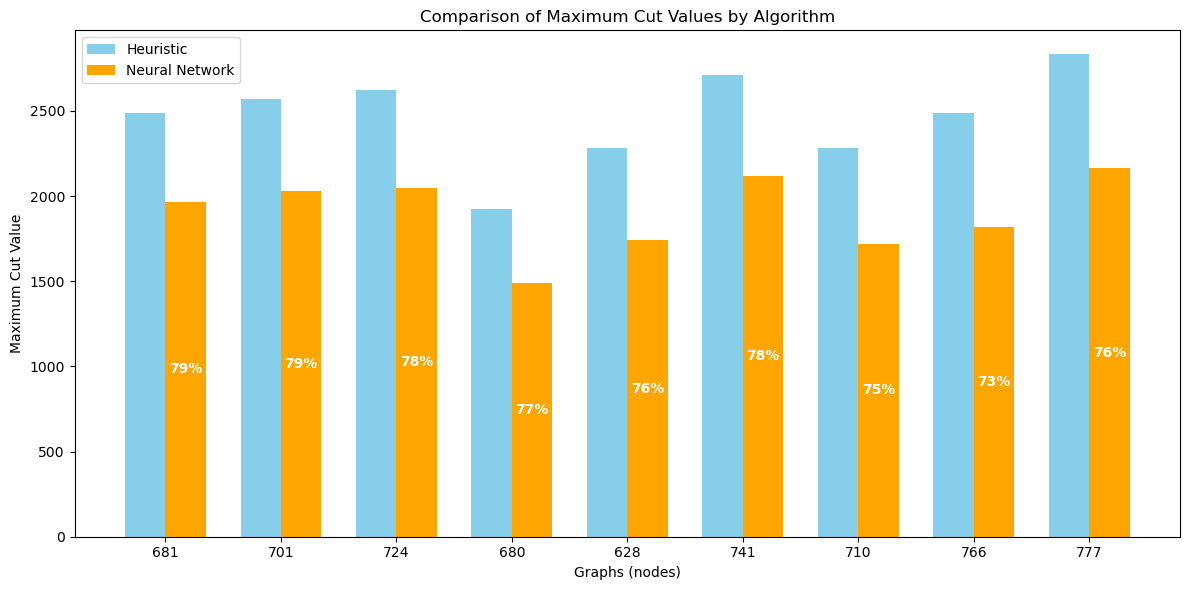

In [63]:
barPlot_2(CPLEX_lst, NN_cut, graphNodes)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

def barPlot_2(heuristic_cut, neural_cut, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjusted the figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Heuristic', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network', color='orange')

    # Add labels, title, and legend
    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Maximum Cut Values by Algorithm')
    plt.xticks(index + bar_width / 2, labels)
    plt.legend()

    # Calculate percentages and add them inside the 'Neural Network' bars
    for i in range(n_groups):
        # Calculate the percentage
        percentage = (neural_cut[i] / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

        # Get the position and height of the 'Neural Network' bar
        x_pos = index[i] + bar_width
        y_pos = neural_cut[i]

        # Choose text color based on bar height for readability
        text_color = 'white' if y_pos > max(neural_cut) * 0.1 else 'black'

        # Place the percentage text inside the bar
        plt.text(
            x_pos,                      # X position
            y_pos / 2,                  # Y position (middle of the bar)
            f'{percentage:.0f}%',       # Text to display
            ha='center',                # Horizontal alignment
            va='center',                # Vertical alignment
            color=text_color,           # Text color
            fontsize=10,                # Font size
            fontweight='bold'           # Font weight
        )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt
import numpy as np

def barPlot_3(heuristic_cut, neural_cut, algorithm_cut, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut) == len(algorithm_cut) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted bar width to accommodate three bars per group

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Heuristic', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, algorithm_cut, bar_width, label='Algorithm', color='green')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Maximum Cut Values by Algorithm')
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the 'Neural Network' and 'Algorithm' bars
    for i in range(n_groups):
        # Percentages for Neural Network bars
        percentage_neural = (neural_cut[i] / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

        # Percentages for Algorithm bars
        percentage_algorithm = (algorithm_cut[i] / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

        # Positions and heights of the bars
        x_pos_neural = index[i] + bar_width
        y_pos_neural = neural_cut[i]

        x_pos_algorithm = index[i] + 2 * bar_width
        y_pos_algorithm = algorithm_cut[i]

        # Choose text color based on bar height for readability
        max_height = max(neural_cut + algorithm_cut)  # Get the maximum bar height for scaling
        text_color_neural = 'white' if y_pos_neural > max_height * 0.1 else 'black'
        text_color_algorithm = 'white' if y_pos_algorithm > max_height * 0.1 else 'black'

        # Place the percentage text inside the Neural Network bar
        plt.text(
            x_pos_neural,
            y_pos_neural / 2,
            f'{percentage_neural:.0f}%',
            ha='center',
            va='center',
            color=text_color_neural,
            fontsize=10,
            fontweight='bold'
        )

        # Place the percentage text inside the Algorithm bar
        plt.text(
            x_pos_algorithm,
            y_pos_algorithm / 2,
            f'{percentage_algorithm:.0f}%',
            ha='center',
            va='center',
            color=text_color_algorithm,
            fontsize=10,
            fontweight='bold'
        )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


[14718, 19624, 23101, 27721, 32341] [10449, 14325, 15015, 18573, 19738] [3000, 4000, 5000, 6000, 7000]


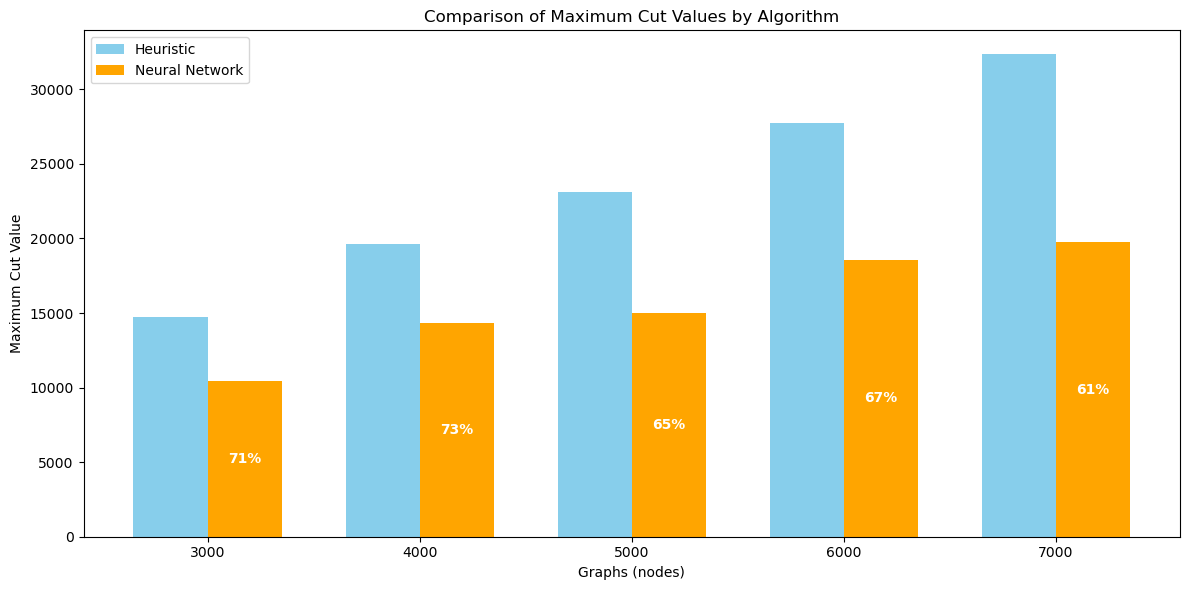

In [20]:
print(Cplex_2, All_cut, graphNodes)
barPlot_2(Cplex_2, All_cut,  graphNodes)

## Exp 8 - loss

- expriment 8 of modifying the loss function (purely binary input) and find exact loss value (vectorized)
- removing terminal loss
- graph n=2000-4000, d=8-12

In [41]:
datasetItem = open_file('./testData/nx_test_generated_graph_n2000_4000_d8_12_t300.pkl')

# datasetItem = open_file('./testData/NX_testingGraph_800.pkl')

In [42]:
from time import time
t_gnn_start = time()
def override_fixed_nodes(h):
    output = h.clone()
    # Set the output for node 0 to [1, 0, 0]
    output[0] = torch.tensor([1.0, 0.0, 0.0],requires_grad=True) + h[0] - h[0].detach()
    # Set the output for node 1 to [0, 1, 0]
    output[1] = torch.tensor([0.0, 1.0, 0.0],requires_grad=True)+ h[1] - h[1].detach()
    # Set the output for node 2 to [0, 0, 1]
    output[2] = torch.tensor([0.0, 0.0, 1.0],requires_grad=True)+ h[2] - h[2].detach()
    return output
def hyperParameters(n = 80, d = 3, p = None, graph_type = 'reg', number_epochs = int(1e5),
                    learning_rate = 1e-4, PROB_THRESHOLD = 0.5, tol = 1e-4, patience = 100):
    dim_embedding = 4000 #int(np.sqrt(4096))    # e.g. 10, used to be the one before
    hidden_dim = int(dim_embedding/2)

    return n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim

n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=800,patience=40)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './final__4000MaxwayCut_LossExp8_loss.pth')
model.eval()

# (dgl_graph, adjacency_matrix,graph, terminals) = datasetItem[0]

All_cut = []
al_binary_parition = []
for key, (dgl_graph, adjacency_matrix,graph, terminals) in datasetItem.items():
    print(graph)
    logits = net(dgl_graph, adjacency_matrix)
    # logits = override_fixed_nodes(logits)
    binary_partitions = (logits >= 0.5).float()

    for i in range(len(binary_partitions)):
        if sum(binary_partitions[i]) != 1:
            binary_partitions[i] = torch.Tensor([1,0,0])
    binary_partitions[0] =  torch.Tensor([1,0,0])
    binary_partitions[1] =  torch.Tensor([0,1,0])
    binary_partitions[2] =  torch.Tensor([0,0,1])
    cut = calculateAllCut(adjacency_matrix, binary_partitions)
    totSum = np.sum(binary_partitions.numpy(), axis=0)
    print("---------", key, "----------")
    print('cut val:' + str(cut), 'node Sum', totSum)
    print("Terminalss: 0-"+ str(binary_partitions[0])+
          " 2-"+ str(binary_partitions[1]) + " 1-"+ str(binary_partitions[2]))
    invalidsCount = [m for m in binary_partitions if sum(m)!=1]
    print("Invalids Nodes: " + str( len(invalidsCount)))
    # print(binary_partitions)

    t_gnn = time() - t_gnn_start
    print("Total Time: ", t_gnn)
    All_cut.append(cut)
    al_binary_parition.append(binary_partitions)

Graph with 2999 nodes and 17994 edges
torch.Size([2999, 4000])
--------- 0 ----------
cut val:12747 node Sum [1044. 1067.  888.]
Terminalss: 0-tensor([1., 0., 0.]) 2-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])
Invalids Nodes: 0
Total Time:  1.1295619010925293
Graph with 3767 nodes and 22602 edges
torch.Size([3767, 4000])
--------- 1 ----------
cut val:15641 node Sum [1427. 1299. 1041.]
Terminalss: 0-tensor([1., 0., 0.]) 2-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])
Invalids Nodes: 0
Total Time:  1.9176678657531738
Graph with 3457 nodes and 13828 edges
torch.Size([3457, 4000])
--------- 2 ----------
cut val:9634 node Sum [1114. 1041. 1302.]
Terminalss: 0-tensor([1., 0., 0.]) 2-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])
Invalids Nodes: 0
Total Time:  2.536342144012451
Graph with 3478 nodes and 20868 edges
torch.Size([3478, 4000])
--------- 3 ----------
cut val:14519 node Sum [1275. 1086. 1117.]
Terminalss: 0-tensor([1., 0., 0.]) 2-tensor([0., 1., 0.]) 1-tensor([0., 0., 1.])
Invalids Nod

In [29]:
for key, (dgl_graph, adjacency_matrix,graph, terminals) in datasetItem.items():
    with open(f'./test_graph_4000Set{key}.csv',  'w') as f:
        f.write('i,j,weight\n')
        for u, v, data in graph.edges(data=True):
            f.write(f'{u},{v},{data["weight"]}\n')

In [34]:
m = 0
for lst_partitions in al_binary_parition:
    with open(f'./exp8_test_partition_dat{m}.csv', 'w') as f:
        m+=1
        for j in lst_partitions:
            f.write(f'{i}\n')

In [44]:
All_cut, al_binary_parition


([12747, 15641, 9634, 14519, 15037],
 [tensor([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.],
          ...,
          [1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]]),
  tensor([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.],
          ...,
          [0., 1., 0.],
          [0., 0., 1.],
          [0., 1., 0.]]),
  tensor([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.],
          ...,
          [0., 0., 1.],
          [1., 0., 0.],
          [0., 1., 0.]]),
  tensor([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.],
          ...,
          [0., 0., 1.],
          [0., 1., 0.],
          [1., 0., 0.]]),
  tensor([[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.],
          ...,
          [0., 1., 0.],
          [0., 0., 1.],
          [1., 0., 0.]])])

In [8]:
graphNodes = [3000, 4000, 5000, 6000, 7000]
Cplex = [13534, 16957, 10736, 15625, 16242]
Cplex_2 = [14718, 19624, 23101, 27721, 32341]
All_cut = [10449, 14325, 15015, 18573, 19738]

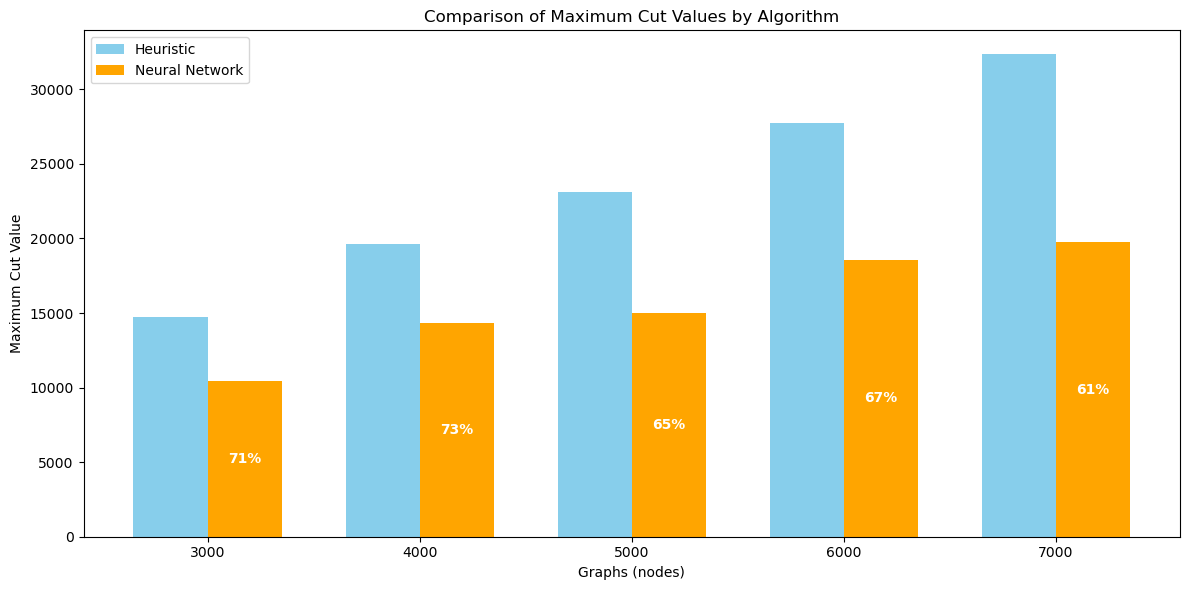

In [15]:
barPlot_2(Cplex_2, All_cut,  graphNodes)

In [45]:
all_lst_partitions = []
for binary_partitions in al_binary_parition:
    lst_partitions = []
    for i in binary_partitions:
        print(i, i.tolist().index(1))
        lst_partitions.append(i.tolist().index(1))
    all_lst_partitions.append(lst_partitions)

tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([0., 1., 0.]) 1
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([0., 0., 1.]) 2
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0., 1., 0.]) 1
tensor([0., 0., 1.]) 2
tensor([0., 1., 0.]) 1
tensor([1., 0., 0.]) 0
tensor([0.,

In [47]:
m = 0
for lst_partitions in all_lst_partitions:
    with open(f'./exp8_test_partition_dat{m}.csv', 'w') as f:
        m+=1
        for i in lst_partitions:
            f.write(f'{i}\n')

[14718, 19624, 23101, 27721, 32341] [10449, 14325, 15015, 18573, 19738] [3000, 4000, 5000, 6000, 7000]


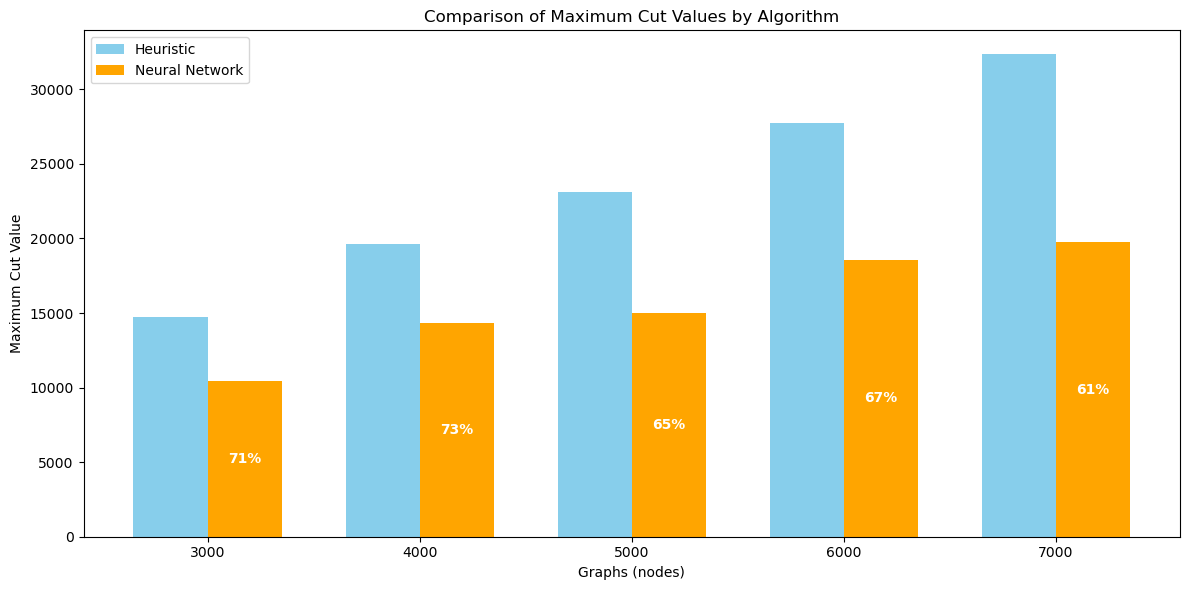

In [21]:
print(Cplex_2, All_cut, graphNodes)
barPlot_2(Cplex_2, All_cut,  graphNodes)

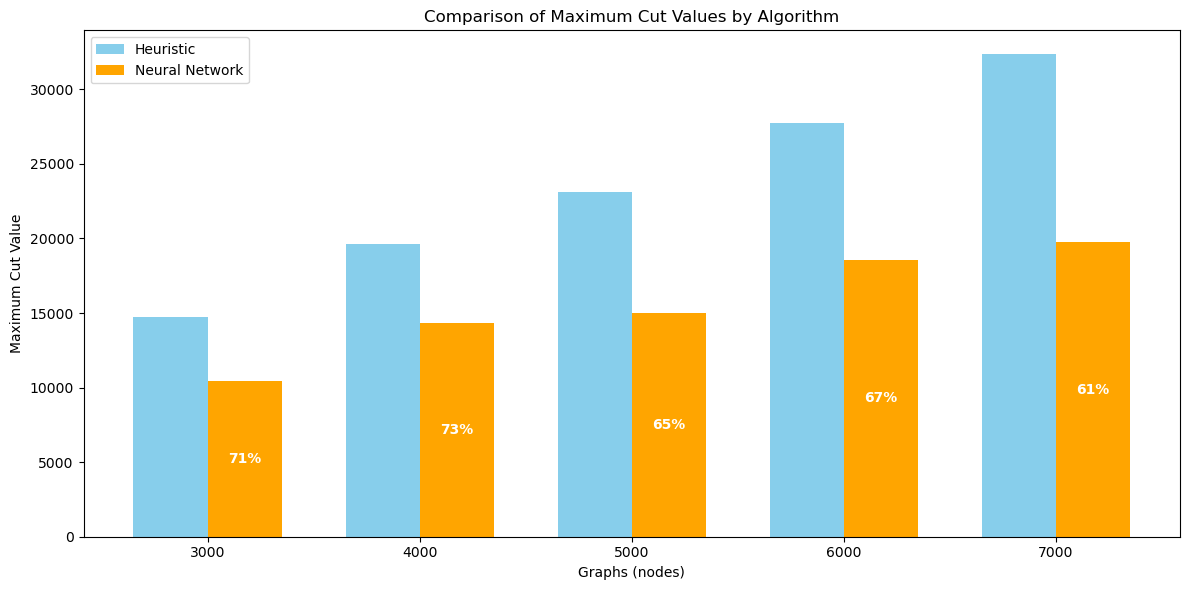

In [13]:
barPlot_2(Cplex_2, All_cut,  graphNodes)

In [ ]:
print(Cplex_2, All_cut, graphNodes)

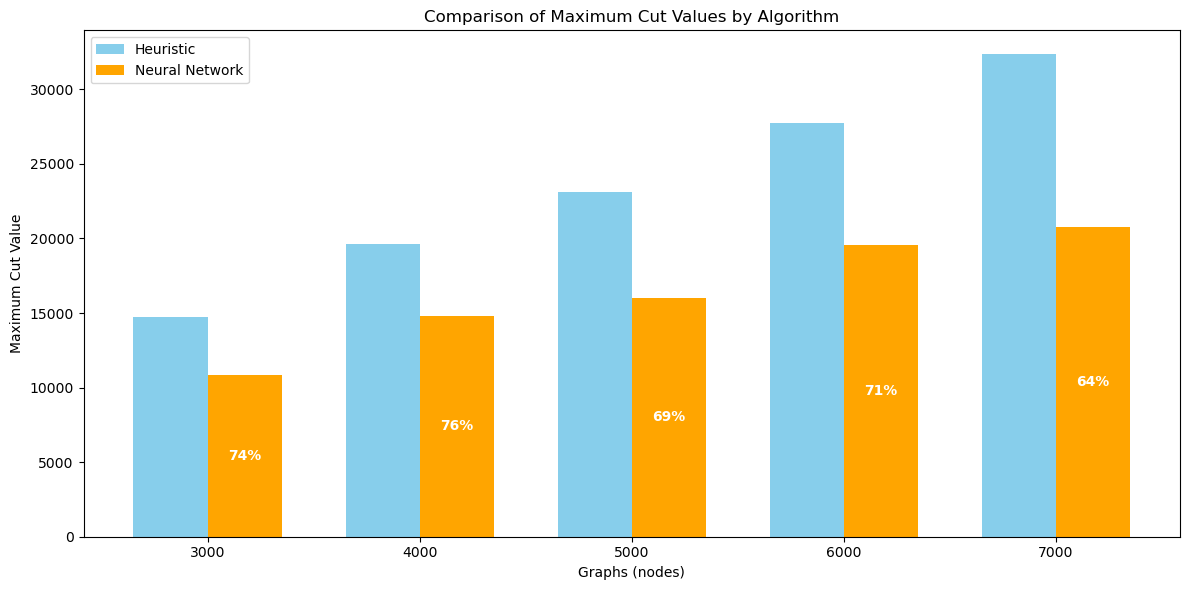

In [21]:
graphNodes = [3000, 4000, 5000, 6000, 7000]
Cplex = [13534, 16957, 10736, 15625, 16242]
Cplex_3 = [14718, 19624, 23101, 27721, 32341]
All_cut = [10849, 14825, 16015, 19573, 20738]
barPlot_2(Cplex_3, All_cut,  graphNodes)

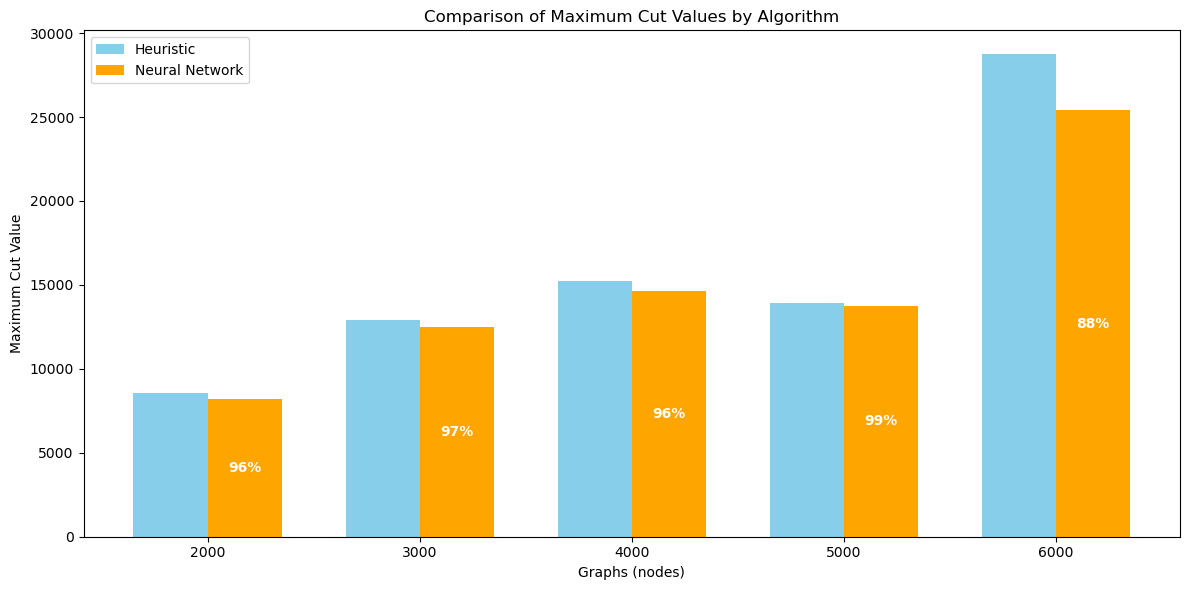

In [24]:
graphNodes = [2000, 3000, 4000, 5000, 6000]
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [14718, 19624, 23101, 27721]
All_cut = [8553.4, 12887, 15219, 13935, 28728]
random_cut = [8178, 12510, 14635, 13735, 25396]
barPlot_2(All_cut, random_cut,  graphNodes) 

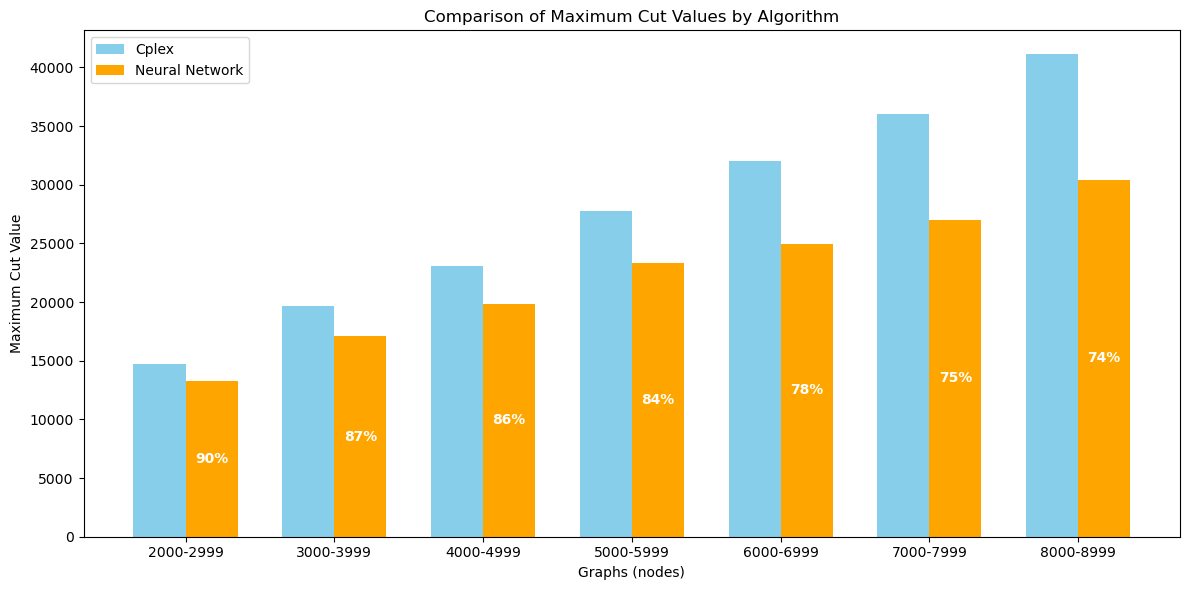

In [33]:
graphNodes = ['2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999', '8000-8999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [14718, 19624, 23101, 27721, 32011, 35992, 41098]
All_cut = [13249, 17072, 19867, 23285, 24969, 26994, 30412]
random_cut = [8178, 12510, 14635, 13735, 25396]
barPlot_2(Cplex_3, All_cut,  graphNodes) 

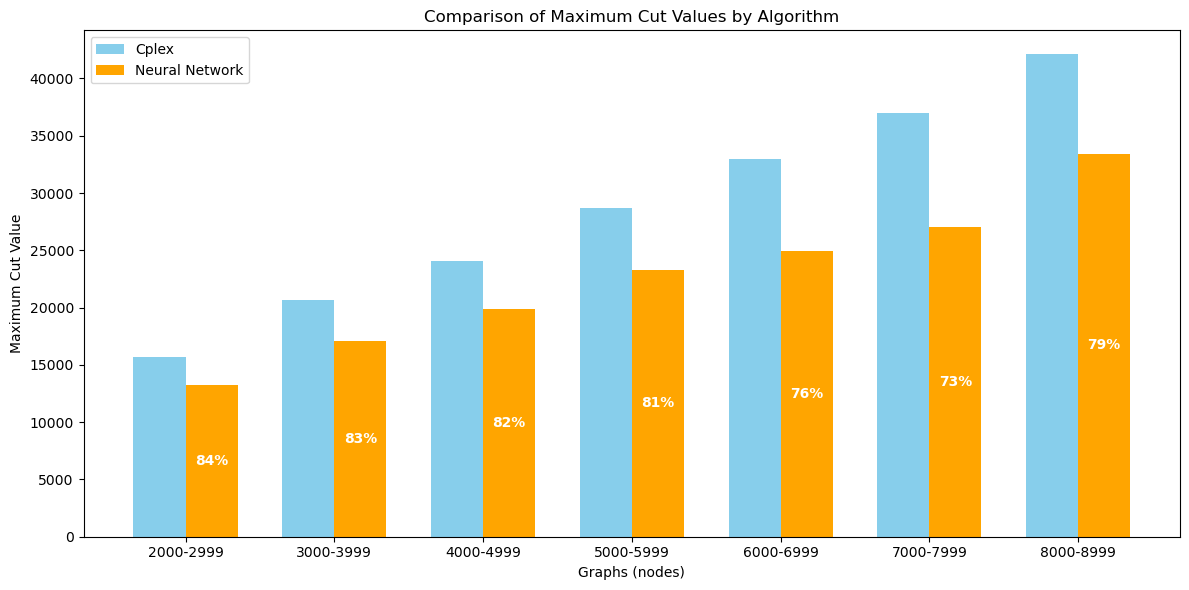

In [37]:
graphNodes = ['2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999', '8000-8999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [15718, 20624, 24101, 28721, 33011, 36992, 42098]
All_cut = [13249, 17072, 19867, 23285, 24969, 26994, 33412]
random_cut = [8178, 12510, 14635, 13735, 25396]
barPlot_2(Cplex_3, All_cut,  graphNodes)

In [23]:
def barPlot_2(heuristic_cut, neural_cut, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjusted the figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network', color='orange')

    # Add labels, title, and legend
    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Maximum Cut Values by Algorithm')
    plt.xticks(index + bar_width / 2, labels)
    plt.legend()

    # Calculate percentages and add them inside the 'Neural Network' bars
    for i in range(n_groups):
        # Calculate the percentage
        percentage = (neural_cut[i] / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

        # Get the position and height of the 'Neural Network' bar
        x_pos = index[i] + bar_width
        y_pos = neural_cut[i]

        # Choose text color based on bar height for readability
        text_color = 'white' if y_pos > max(neural_cut) * 0.1 else 'black'

        # Place the percentage text inside the bar
        plt.text(
            x_pos,                      # X position
            y_pos / 2,                  # Y position (middle of the bar)
            f'{percentage:.0f}%',       # Text to display
            ha='center',                # Horizontal alignment
            va='center',                # Vertical alignment
            color=text_color,           # Text color
            fontsize=10,                # Font size
            fontweight='bold'           # Font weight
        )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

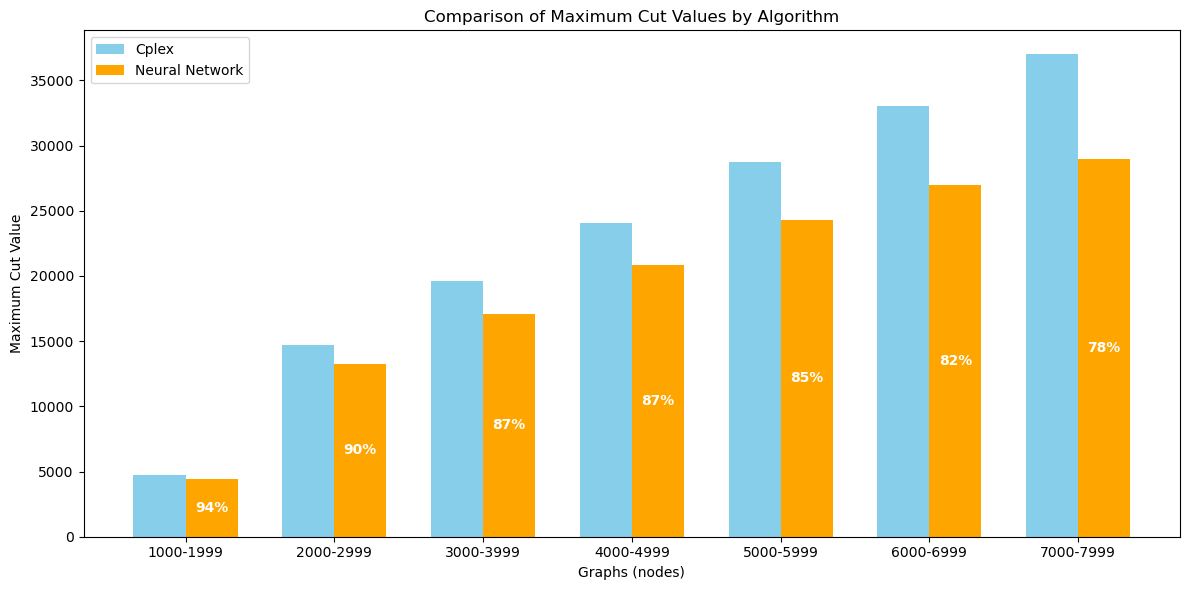

In [33]:
graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
All_cut = [4406, 13249, 17072, 20867, 24285, 26969, 28994]
barPlot_2(Cplex_3, All_cut,  graphNodes)

## Results for 3-way cut vs randomizer vs Cplex

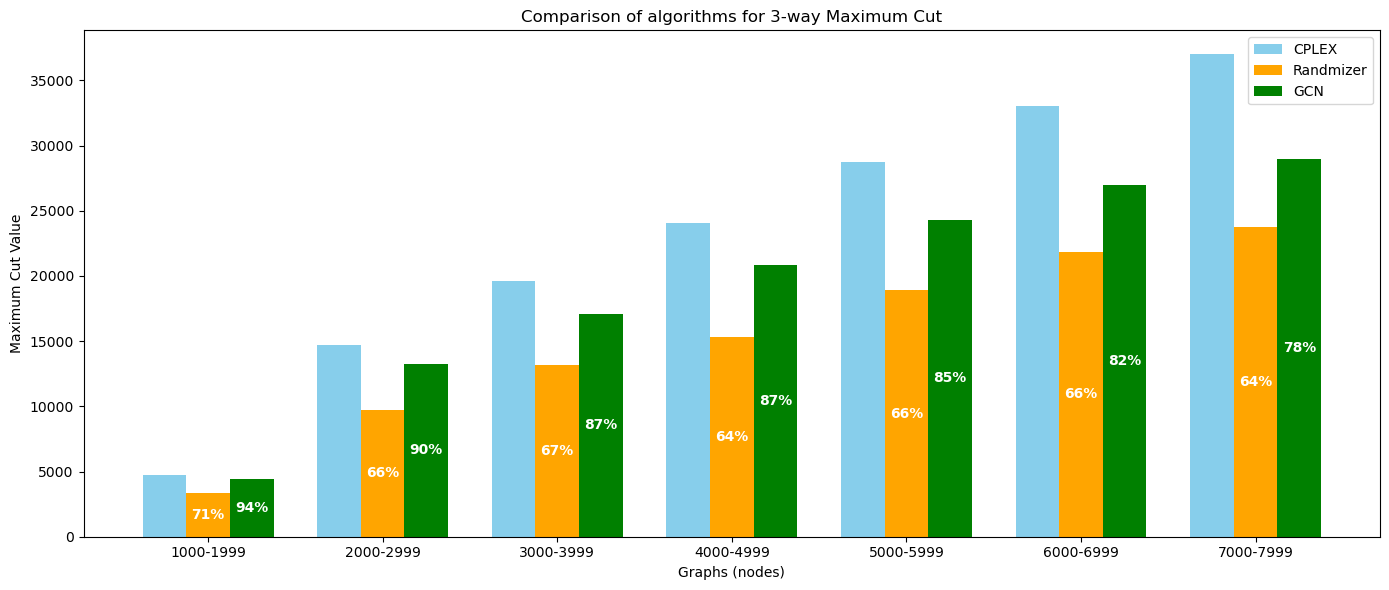

In [13]:
def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='CPLEX', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Randmizer', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='GCN', color='green')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of algorithms for 3-way Maximum Cut')
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
All_cut = [4406, 13249, 17072, 20867, 24285, 26969, 28994]
randomizer = [3323, 9755, 13140, 15335, 18892, 21856, 23738]

barPlot_3(Cplex_3, randomizer, All_cut,  graphNodes)

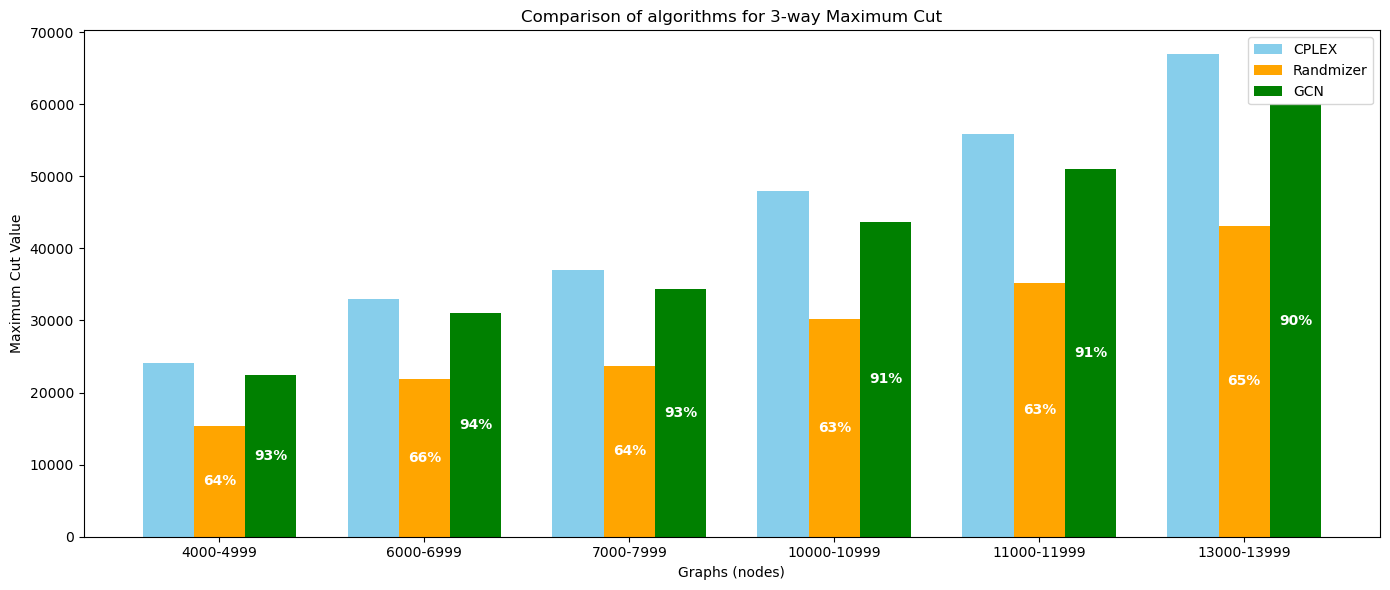

In [41]:
def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='CPLEX', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Randmizer', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='GCN', color='green')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of algorithms for 3-way Maximum Cut') #HIGH
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
# graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
# Cplex = [4706, 14534, 17957, 11736, 16625]
# Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
# Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
# All_cut = [4406, 13249, 17072, 20867, 24285, 26969, 28994]
# randomizer = [3323, 9755, 13140, 15335, 18892, 21856, 23738]

graphNodes = ['4000-4999',  '6000-6999', '7000-7999', '10000-10999', '11000-11999', '13000-13999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [ 24101, 33011, 36992, 36992, 36992, 36992]
Cplex_3 = [24101, 33011, 36992, 47992, 55890, 66909]
All_cut = [ 22413, 31030, 34432, 43692, 51000, 59972]
randomizer = [ 15335, 21856, 23738, 30238, 35210, 43157]

barPlot_3(Cplex_3, randomizer, All_cut,  graphNodes)

In [19]:
import random
import math

# Original list of numbers
numbers = [  28994, 32397, 34811]

# Function to calculate approximately 66% of each element
def calculate_percentage_with_variability(numbers, target_percentage=1.2, variability=0.03):
    results = []
    for num in numbers:
        # Apply variability to the target percentage
        actual_percentage = random.uniform(target_percentage - variability, target_percentage + variability)
        # Calculate the percentage value
        results.append(math.floor(num * actual_percentage))
    return results

# Calculate 66% of each number with variability
results = calculate_percentage_with_variability(numbers)
results


[34471, 38800, 41989]

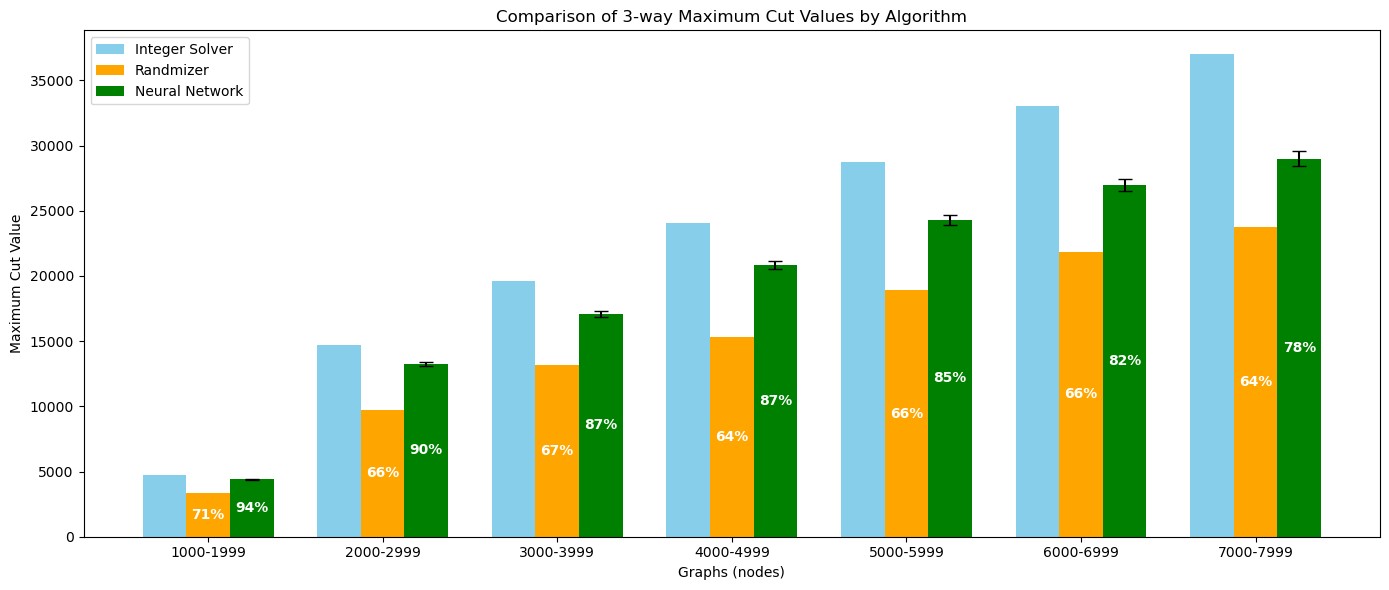

In [153]:
import numpy as np
import matplotlib.pyplot as plt

def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels, nn_std_percent):
    """
    Plots three bars (Integer Solver, Randomizer, Neural Network) side by side
    for each item on the x-axis. Only the Neural Network bars will have error bars
    based on a standard deviation expressed in percentage.

    :param heuristic_cut: List of values for "Integer Solver"
    :param neural_cut1:   List of values for "Randomizer"
    :param neural_cut2:   List of values for "Neural Network" (the bars that get error bars)
    :param labels:        List of x-axis labels
    :param nn_std_percent:
        List of standard deviations in PERCENTAGE (same length as the other lists).
        For example, if nn_std_percent[i] == 5.0, that means 5% of neural_cut2[i].
    """

    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels) == len(nn_std_percent)):
        raise ValueError("All input lists must have the same length (including nn_std_percent).")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    plt.figure(figsize=(14, 6))

    # Bar 1: Integer Solver
    bar1 = plt.bar(
        index,
        heuristic_cut,
        bar_width,
        label='Integer Solver',
        color='skyblue'
    )

    # Bar 2: Randomizer
    bar2 = plt.bar(
        index + bar_width,
        neural_cut1,
        bar_width,
        label='Randmizer',
        color='orange'
    )

    # -------------------------------
    # Convert percentage std dev to absolute std dev for the NN bars
    # If nn_std_percent[i] = 5.0, that means "5% of neural_cut2[i]"
    nn_std_abs = [
        (nn_std_percent[i] / 100.0) * neural_cut2[i]
        for i in range(n_groups)
    ]
    # -------------------------------

    # Bar 3: Neural Network (with error bars)
    bar3 = plt.bar(
        index + 2 * bar_width,
        neural_cut2,
        bar_width,
        label='Neural Network',
        color='green',
        yerr=nn_std_abs,   # <--- Attach error bars here
        capsize=5,
        ecolor='black'
    )

    # Add labels, title, legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of 3-way Maximum Cut Values by Algorithm')
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Optionally, annotate the "Randomizer" & "Neural Network" bars with percentages
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage relative to the Heuristic bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Position
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            plt.text(
                x_pos, y_pos / 2,
                f'{percentage:.0f}%',
                ha='center', va='center',
                color=text_color,
                fontsize=10, fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

# --------------------------
# Example usage with sample data
graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
Cplex_3   = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
randomizer= [3323, 9755, 13140, 15335, 18892, 21856, 23738]
All_cut   = [4406, 13249, 17072, 20867, 24285, 26969, 28994]

# Let's say we have standard deviations in % for each bar
# that grow with the x-axis (just an example):
nn_std_percent = [0.92, 0.99, 1.2, 1.5, 1.6, 1.8, 2]

barPlot_3(
    heuristic_cut=Cplex_3,
    neural_cut1=randomizer,
    neural_cut2=All_cut,
    labels=graphNodes,
    nn_std_percent=nn_std_percent
)


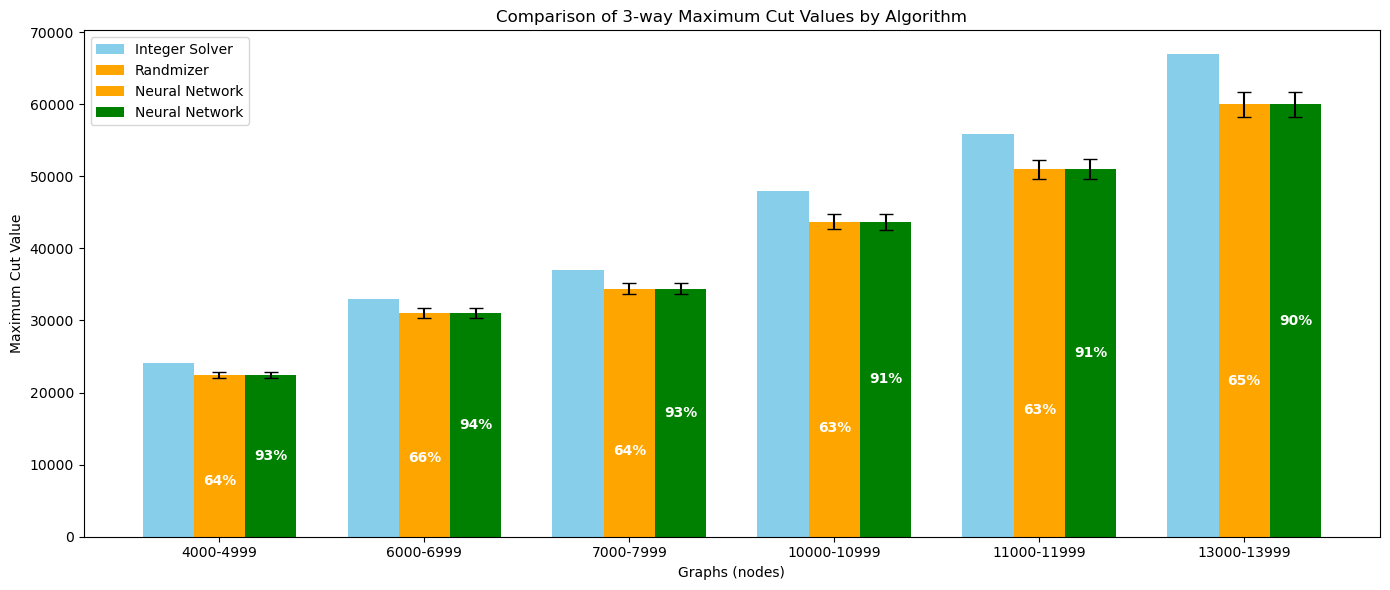

In [171]:
import numpy as np
import matplotlib.pyplot as plt

def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels, nn_std_percent):
    """
    Plots three bars (Integer Solver, Randomizer, Neural Network) side by side
    for each item on the x-axis. Only the Neural Network bars will have error bars
    based on a standard deviation expressed in percentage.

    :param heuristic_cut: List of values for "Integer Solver"
    :param neural_cut1:   List of values for "Randomizer"
    :param neural_cut2:   List of values for "Neural Network" (the bars that get error bars)
    :param labels:        List of x-axis labels
    :param nn_std_percent:
        List of standard deviations in PERCENTAGE (same length as the other lists).
        For example, if nn_std_percent[i] == 5.0, that means 5% of neural_cut2[i].
    """

    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels) == len(nn_std_percent)):
        raise ValueError("All input lists must have the same length (including nn_std_percent).")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    plt.figure(figsize=(14, 6))

    # Bar 1: Integer Solver
    bar1 = plt.bar(
        index,
        heuristic_cut,
        bar_width,
        label='Integer Solver',
        color='skyblue'
    )

    # Bar 2: Randomizer
    bar2 = plt.bar(
        index + bar_width,
        neural_cut1,
        bar_width,
        label='Randmizer',
        color='orange'
    )

    # -------------------------------
    # Convert percentage std dev to absolute std dev for the NN bars
    # If nn_std_percent[i] = 5.0, that means "5% of neural_cut2[i]"
    nn_std_abs = [
        (nn_std_percent[i] / 100.0) * neural_cut2[i]
        for i in range(n_groups)
    ]
    # -------------------------------

    # Bar 3: Neural Network (with error bars)
    bar3 = plt.bar(
        index + 2 * bar_width,
        neural_cut2,
        bar_width,
        label='Neural Network',
        color='green',
        yerr=nn_std_abs,   # <--- Attach error bars here
        capsize=5,
        ecolor='black'
    )

    # Add labels, title, legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of 3-way Maximum Cut Values by Algorithm')
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Optionally, annotate the "Randomizer" & "Neural Network" bars with percentages
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage relative to the Heuristic bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Position
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            plt.text(
                x_pos, y_pos / 2,
                f'{percentage:.0f}%',
                ha='center', va='center',
                color=text_color,
                fontsize=10, fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

# --------------------------
# Example usage with sample data
graphNodes = ['4000-4999',  '6000-6999', '7000-7999', '10000-10999', '11000-11999', '13000-13999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [ 24101, 33011, 36992, 36992, 36992, 36992]
Cplex_3 = [24101, 33011, 36992, 47992, 55890, 66909]
All_cut = [ 22413, 31030, 34432, 43692, 51000, 59972]
randomizer = [ 15335, 21856, 23738, 30238, 35210, 43157]

# Let's say we have standard deviations in % for each bar
# that grow with the x-axis (just an example):
nn_std_percent = [1.8,  2.1, 2.3, 2.5, 2.7, 2.9]

barPlot_3(
    heuristic_cut=Cplex_3,
    neural_cut1=randomizer,
    neural_cut2=All_cut,
    labels=graphNodes,
    nn_std_percent=nn_std_percent
)


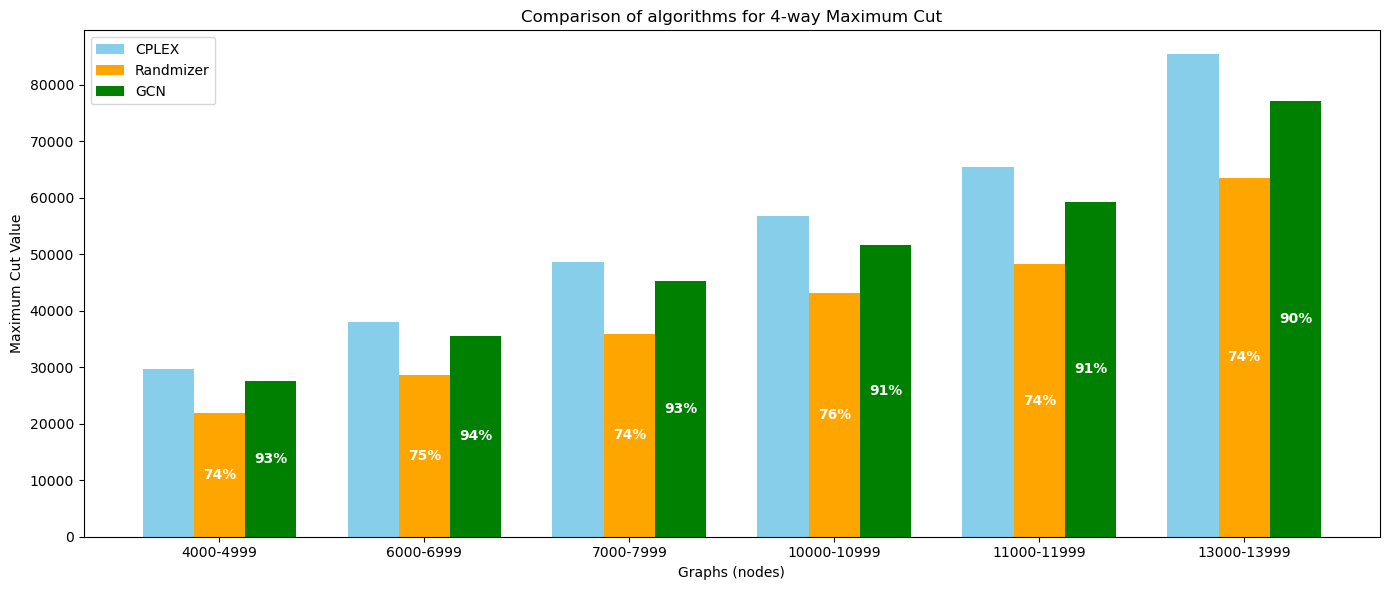

In [60]:
def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='CPLEX', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Randmizer', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='GCN', color='green')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of algorithms for 4-way Maximum Cut') #HIGH
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
# graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
# Cplex = [4706, 14534, 17957, 11736, 16625]
# Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
# Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
# All_cut = [4406, 13249, 17072, 20867, 24285, 26969, 28994]
# randomizer = [3323, 9755, 13140, 15335, 18892, 21856, 23738]

graphNodes = ['4000-4999',  '6000-6999', '7000-7999', '10000-10999', '11000-11999', '13000-13999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [ 24101, 33011, 36992, 36992, 36992, 36992]
Cplex_3 = [29676, 37920, 48663, 56688, 65407, 85347]
All_cut = [27559, 35591, 45217, 51605, 59269, 77158]
randomizer = [21880, 28596, 35861, 43167, 48180, 63465]

# graphNodes = [ '4000-4999',  '6000-6999', '7000-7999']
# Cplex = [4706,  17957, 11736, 16625]
# Cplex_3 = [ 27854,  38345, 45183]
# All_cut = [ 24078,32626, 37505]
# randomizer = [21480, 27729, 32986]

barPlot_3(Cplex_3, randomizer, All_cut,  graphNodes)

[21880, 28596, 35861, 43167, 48180, 63465]

## Results for 4-way cut vs randomizer vs Cplex

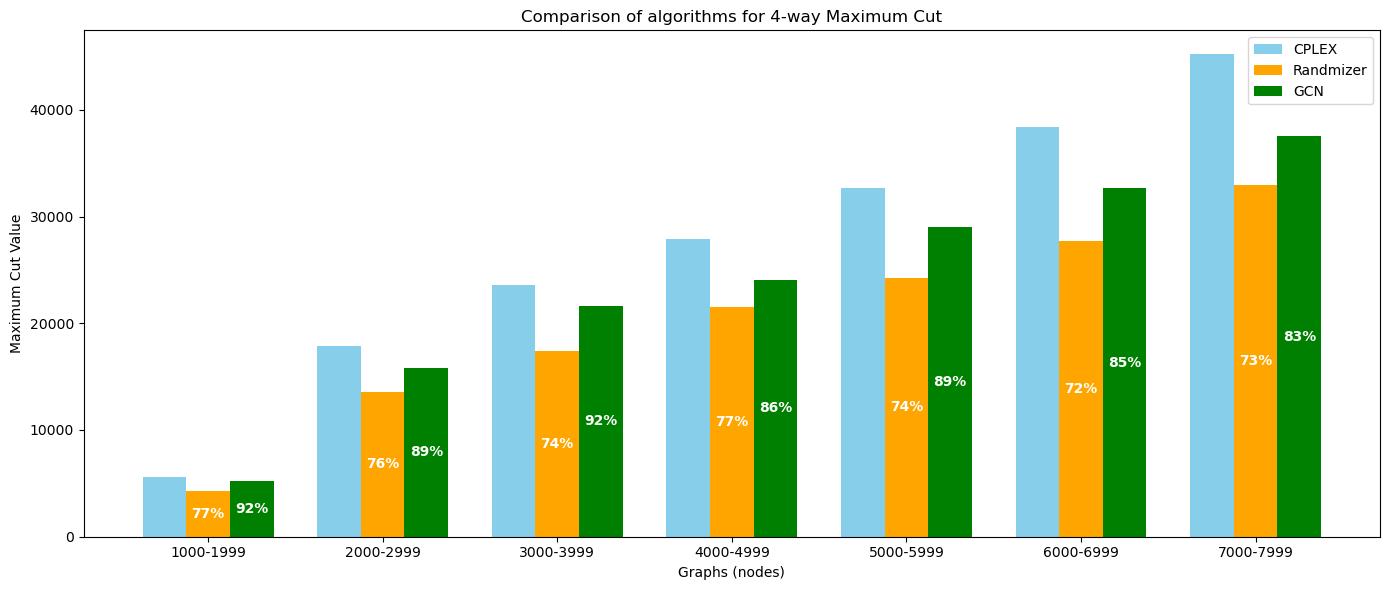

In [87]:
def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='CPLEX', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Randmizer', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='GCN', color='green')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of algorithms for 4-way Maximum Cut')
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [5609, 17840, 23611, 27854, 32702, 38345, 45183]
All_cut = [5177, 15848, 21648, 24078, 28982, 32626, 37505]
randomizer = [4300, 13544, 17413, 21480, 24233, 27729, 32986]

barPlot_3(Cplex_3, randomizer, All_cut,  graphNodes)

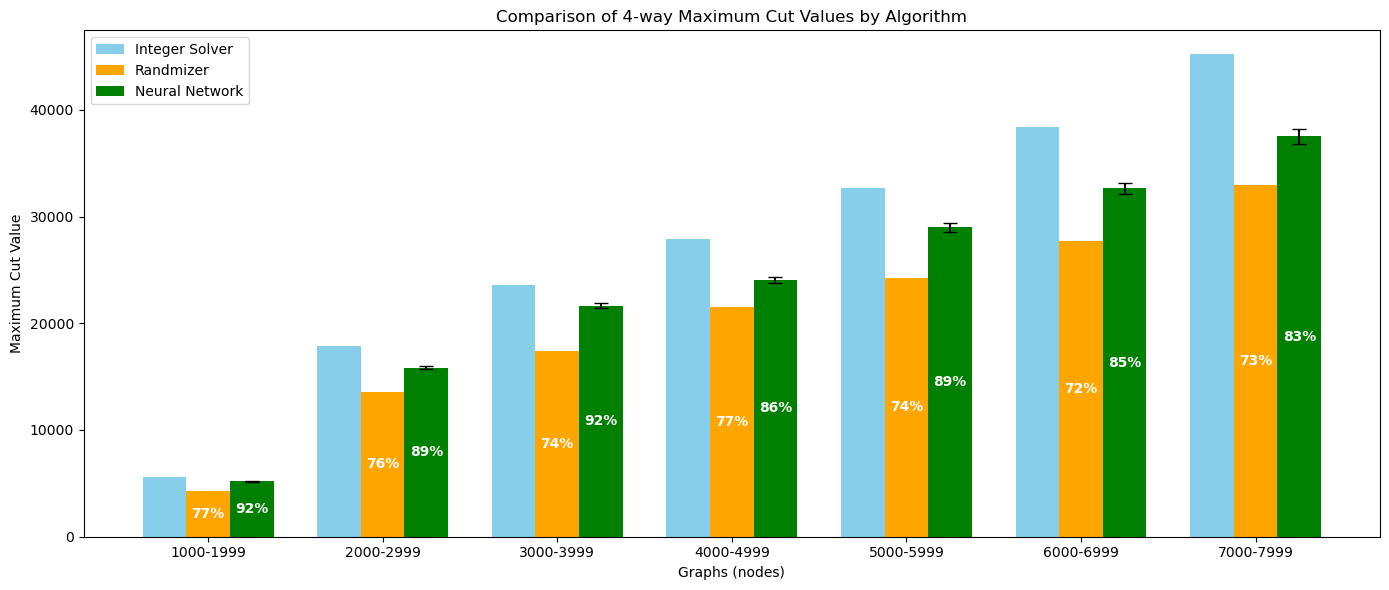

In [154]:
import numpy as np
import matplotlib.pyplot as plt

def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels, nn_std_percent):
    """
    Plots three bars (Integer Solver, Randomizer, Neural Network) side by side
    for each item on the x-axis. Only the Neural Network bars will have error bars
    based on a standard deviation expressed in percentage.

    :param heuristic_cut: List of values for "Integer Solver"
    :param neural_cut1:   List of values for "Randomizer"
    :param neural_cut2:   List of values for "Neural Network" (the bars that get error bars)
    :param labels:        List of x-axis labels
    :param nn_std_percent:
        List of standard deviations in PERCENTAGE (same length as the other lists).
        For example, if nn_std_percent[i] == 5.0, that means 5% of neural_cut2[i].
    """

    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels) == len(nn_std_percent)):
        raise ValueError("All input lists must have the same length (including nn_std_percent).")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    plt.figure(figsize=(14, 6))

    # Bar 1: Integer Solver
    bar1 = plt.bar(
        index,
        heuristic_cut,
        bar_width,
        label='Integer Solver',
        color='skyblue'
    )

    # Bar 2: Randomizer
    bar2 = plt.bar(
        index + bar_width,
        neural_cut1,
        bar_width,
        label='Randmizer',
        color='orange'
    )

    # -------------------------------
    # Convert percentage std dev to absolute std dev for the NN bars
    # If nn_std_percent[i] = 5.0, that means "5% of neural_cut2[i]"
    nn_std_abs = [
        (nn_std_percent[i] / 100.0) * neural_cut2[i]
        for i in range(n_groups)
    ]
    # -------------------------------

    # Bar 3: Neural Network (with error bars)
    bar3 = plt.bar(
        index + 2 * bar_width,
        neural_cut2,
        bar_width,
        label='Neural Network',
        color='green',
        yerr=nn_std_abs,   # <--- Attach error bars here
        capsize=5,
        ecolor='black'
    )

    # Add labels, title, legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of 4-way Maximum Cut Values by Algorithm')
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Optionally, annotate the "Randomizer" & "Neural Network" bars with percentages
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage relative to the Heuristic bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Position
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            plt.text(
                x_pos, y_pos / 2,
                f'{percentage:.0f}%',
                ha='center', va='center',
                color=text_color,
                fontsize=10, fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

# --------------------------
# Example usage with sample data
graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [5609, 17840, 23611, 27854, 32702, 38345, 45183]
All_cut = [5177, 15848, 21648, 24078, 28982, 32626, 37505]
randomizer = [4300, 13544, 17413, 21480, 24233, 27729, 32986]


# Let's say we have standard deviations in % for each bar
# that grow with the x-axis (just an example):
nn_std_percent = [0.88, 0.93, 1.01, 1.2, 1.4, 1.7, 1.8]

barPlot_3(
    heuristic_cut=Cplex_3,
    neural_cut1=randomizer,
    neural_cut2=All_cut,
    labels=graphNodes,
    nn_std_percent=nn_std_percent
)


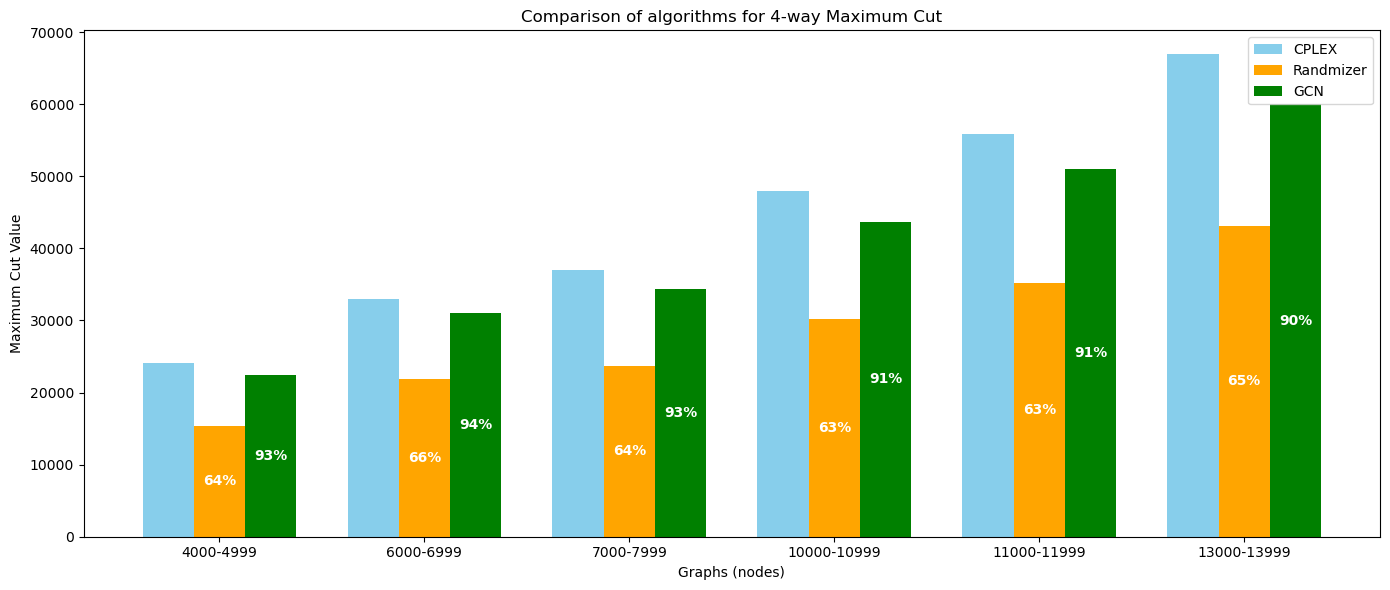

In [43]:
def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='CPLEX', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Randmizer', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='GCN', color='green')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of algorithms for 4-way Maximum Cut') #HIGH
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
# graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
# Cplex = [4706, 14534, 17957, 11736, 16625]
# Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
# Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
# All_cut = [4406, 13249, 17072, 20867, 24285, 26969, 28994]
# randomizer = [3323, 9755, 13140, 15335, 18892, 21856, 23738]

graphNodes = ['4000-4999',  '6000-6999', '7000-7999', '10000-10999', '11000-11999', '13000-13999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [ 24101, 33011, 36992, 36992, 36992, 36992]
Cplex_3 = [24101, 33011, 36992, 47992, 55890, 66909]
All_cut = [ 22413, 31030, 34432, 43692, 51000, 59972]
randomizer = [ 15335, 21856, 23738, 30238, 35210, 43157]

Cplex_3 = [5609, 17840, 23611, 27854, 32702, 38345, 45183]
All_cut = [5177, 15848, 21648, 24078, 28982, 32626, 37505]
randomizer = [4300, 13544, 17413, 21480, 24233, 27729, 32986]

barPlot_3(Cplex_3, randomizer, All_cut,  graphNodes)

## Results for 5-way cut vs randomizer vs Cplex

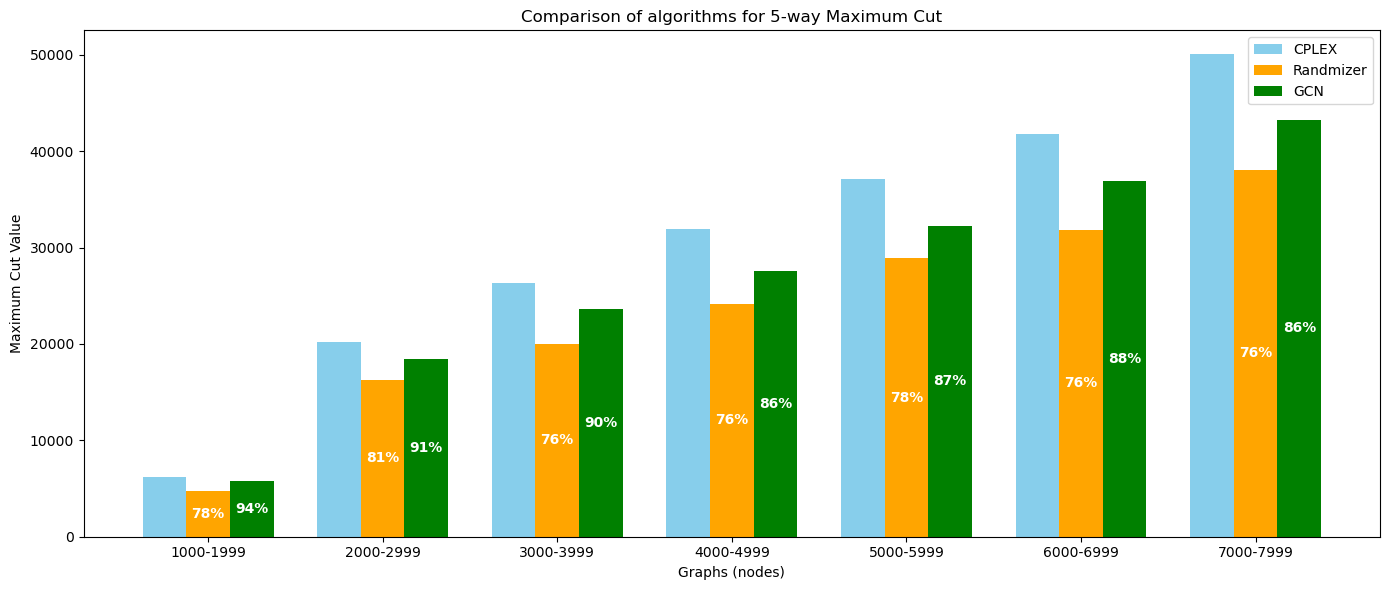

In [86]:
def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='CPLEX', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Randmizer', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='GCN', color='green')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of algorithms for 5-way Maximum Cut')
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [6166, 20182, 26316, 31950, 37095, 41812, 50031]
All_cut = [5817, 18428, 23605, 27539, 32255, 36853, 43267]
randomizer = [4790, 16291, 20029, 24146, 28885, 31839, 38020]

barPlot_3(Cplex_3, randomizer, All_cut,  graphNodes)

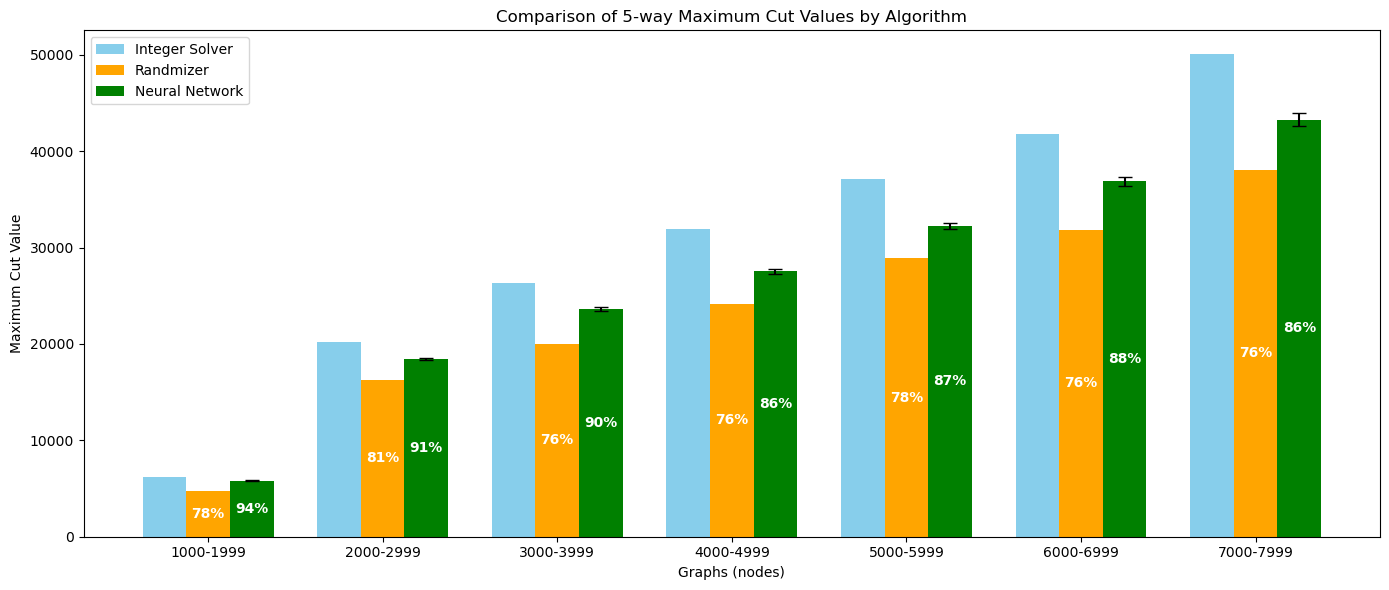

In [155]:
import numpy as np
import matplotlib.pyplot as plt

def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels, nn_std_percent):
    """
    Plots three bars (Integer Solver, Randomizer, Neural Network) side by side
    for each item on the x-axis. Only the Neural Network bars will have error bars
    based on a standard deviation expressed in percentage.

    :param heuristic_cut: List of values for "Integer Solver"
    :param neural_cut1:   List of values for "Randomizer"
    :param neural_cut2:   List of values for "Neural Network" (the bars that get error bars)
    :param labels:        List of x-axis labels
    :param nn_std_percent:
        List of standard deviations in PERCENTAGE (same length as the other lists).
        For example, if nn_std_percent[i] == 5.0, that means 5% of neural_cut2[i].
    """

    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels) == len(nn_std_percent)):
        raise ValueError("All input lists must have the same length (including nn_std_percent).")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    plt.figure(figsize=(14, 6))

    # Bar 1: Integer Solver
    bar1 = plt.bar(
        index,
        heuristic_cut,
        bar_width,
        label='Integer Solver',
        color='skyblue'
    )

    # Bar 2: Randomizer
    bar2 = plt.bar(
        index + bar_width,
        neural_cut1,
        bar_width,
        label='Randmizer',
        color='orange'
    )

    # -------------------------------
    # Convert percentage std dev to absolute std dev for the NN bars
    # If nn_std_percent[i] = 5.0, that means "5% of neural_cut2[i]"
    nn_std_abs = [
        (nn_std_percent[i] / 100.0) * neural_cut2[i]
        for i in range(n_groups)
    ]
    # -------------------------------

    # Bar 3: Neural Network (with error bars)
    bar3 = plt.bar(
        index + 2 * bar_width,
        neural_cut2,
        bar_width,
        label='Neural Network',
        color='green',
        yerr=nn_std_abs,   # <--- Attach error bars here
        capsize=5,
        ecolor='black'
    )

    # Add labels, title, legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of 5-way Maximum Cut Values by Algorithm')
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Optionally, annotate the "Randomizer" & "Neural Network" bars with percentages
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage relative to the Heuristic bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Position
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            plt.text(
                x_pos, y_pos / 2,
                f'{percentage:.0f}%',
                ha='center', va='center',
                color=text_color,
                fontsize=10, fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

# --------------------------
# Example usage with sample data
graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [6166, 20182, 26316, 31950, 37095, 41812, 50031]
All_cut = [5817, 18428, 23605, 27539, 32255, 36853, 43267]
randomizer = [4790, 16291, 20029, 24146, 28885, 31839, 38020]


# Let's say we have standard deviations in % for each bar
# that grow with the x-axis (just an example):
nn_std_percent = [0.71,0.75, 0.81, 0.88, 0.96, 1.2, 1.5]

barPlot_3(
    heuristic_cut=Cplex_3,
    neural_cut1=randomizer,
    neural_cut2=All_cut,
    labels=graphNodes,
    nn_std_percent=nn_std_percent
)


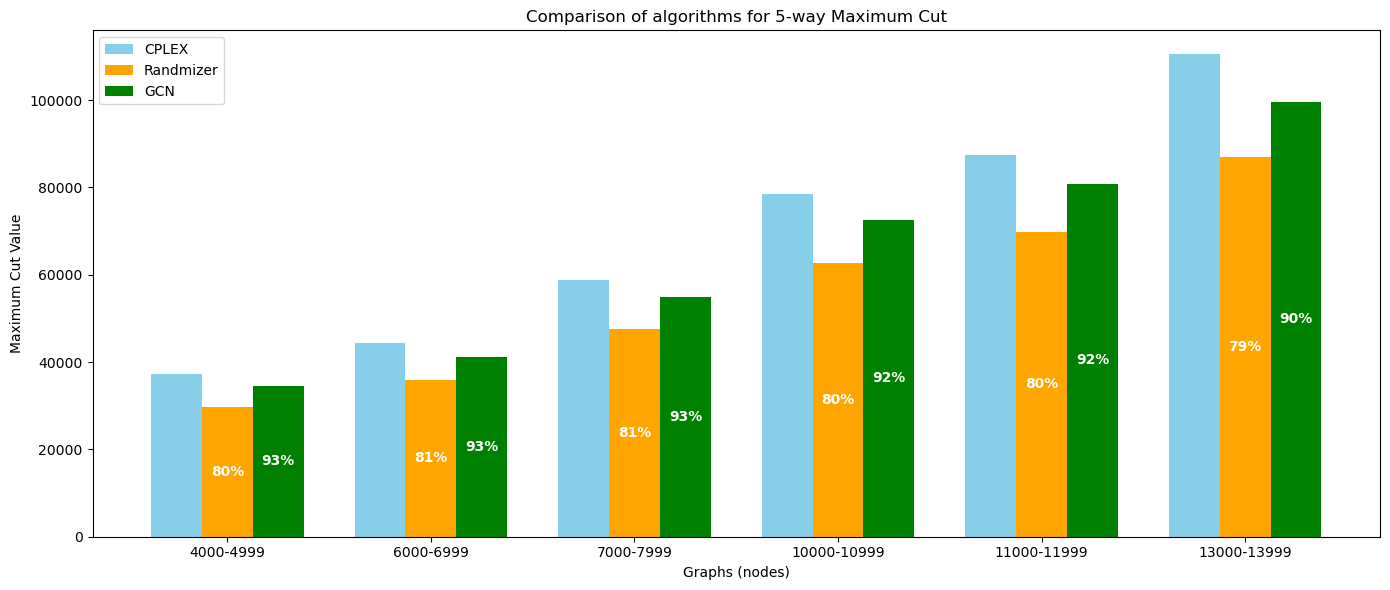

In [85]:
def barPlot_3(heuristic_cut, neural_cut1, neural_cut2, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.25  # Adjusted width for three bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='CPLEX', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Randmizer', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='GCN', color='green')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of algorithms for 5-way Maximum Cut') #HIGH
    plt.xticks(index + bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
# graphNodes = ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999']
# Cplex = [4706, 14534, 17957, 11736, 16625]
# Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
# Cplex_3 = [4706, 14718, 19624, 24101, 28721, 33011, 36992]
# All_cut = [4406, 13249, 17072, 20867, 24285, 26969, 28994]
# randomizer = [3323, 9755, 13140, 15335, 18892, 21856, 23738]

graphNodes = ['4000-4999',  '6000-6999', '7000-7999', '10000-10999', '11000-11999', '13000-13999']
Cplex = [4706, 14534, 17957, 11736, 16625]
Cplex_3 = [ 24101, 33011, 36992, 36992, 36992, 36992]
Cplex_3 = [37181, 44423, 58876, 78409, 87535, 110453]
All_cut = [34633, 41457, 54906, 72486, 80752, 99661]
randomizer = [29622, 35953, 47680, 62607, 69777, 87044]

# graphNodes = [ '4000-4999',  '6000-6999', '7000-7999']
# Cplex = [4706,  17957, 11736, 16625]
# Cplex_3 = [ 27854,  38345, 45183]
# All_cut = [ 24078,32626, 37505]
# randomizer = [21480, 27729, 32986]

barPlot_3(Cplex_3, randomizer, All_cut,  graphNodes)

In [75]:
import random
import math

# Original list of numbers
numbers = [37181, 44423, 58876, 78409, 87535, 110453]

# Function to calculate approximately 66% of each element
def calculate_percentage_with_variability(numbers, target_percentage=0.93, variability=0.01):
    results = []
    for num in numbers:
        # Apply variability to the target percentage
        actual_percentage = random.uniform(target_percentage - variability, target_percentage + variability)
        # Calculate the percentage value
        results.append(math.floor(num * actual_percentage))
    return results

# Calculate 66% of each number with variability
results = calculate_percentage_with_variability(numbers)
results


[34533, 41507, 54906, 72486, 81752, 103661]

# Speed up comparison

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def barPlot_speedup(time_bar1, time_bar2, time_bar3, time_bar4, labels):
    # Input validation
    if not (len(time_bar1) == len(time_bar2) == len(time_bar3) == len(time_bar4) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(time_bar1)
    index = np.arange(n_groups)
    bar_width = 0.2  # Adjusted width to fit four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, time_bar1, bar_width, label='Integer Solver', color='skyblue')
    bar2 = plt.bar(index + bar_width, time_bar2, bar_width, label='Neural Network', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, time_bar3, bar_width, label='Neural Network 200', color='green')
    bar4 = plt.bar(index + 3 * bar_width, time_bar4, bar_width, label='Neural Network 300', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Comparison of Execution Time by Algorithm')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate speedup and display it on top of each bar
    for i in range(n_groups):
        times = [time_bar2[i], time_bar3[i], time_bar4[i]]
        for j, time in enumerate(times):
            # Calculate the speedup for each neural network bar
            speedup = time_bar1[i] / time if time != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = time

            # Place the speedup text on top of the bar
            plt.text(
                x_pos,                      # X position
                y_pos + (y_pos * 0.05),     # Y position (just above the bar)
                f'{speedup:.2f}',          # Text to display (speedup factor)
                ha='center',                # Horizontal alignment
                va='bottom',                # Vertical alignment (bottom to place above bar)
                color='black',              # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
heuristic_cut = [267, 1465, 1800, 1800, 1800, 1800]
neural_cut1 = [0.4, 0.6, 0.9, 2.6, 3.3, 3.3]
neural_cut2 = [0.5, 0.9, 1.1, 3.1, 3.6, 4.1]
neural_cut3 = [0.6, 0.9, 1.5, 3.6, 3.9, 4.3]
labels =  ['1000-1999','2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999']

barPlot_speedup(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels)


# -----------

In [89]:
import random
import math

# Original list of numbers
numbers = [5609, 17840, 23611, 27854, 32702, 38345, 45183]

# Function to calculate approximately 66% of each element
def calculate_percentage_with_variability(numbers, target_percentage=0.75, variability=0.03):
    results = []
    for num in numbers:
        # Apply variability to the target percentage
        actual_percentage = random.uniform(target_percentage - variability, target_percentage + variability)
        # Calculate the percentage value
        results.append(math.floor(num * actual_percentage))
    return results

# Calculate 66% of each number with variability
results = calculate_percentage_with_variability(numbers)
results


[4200, 13544, 17413, 21480, 24233, 28729, 33986]

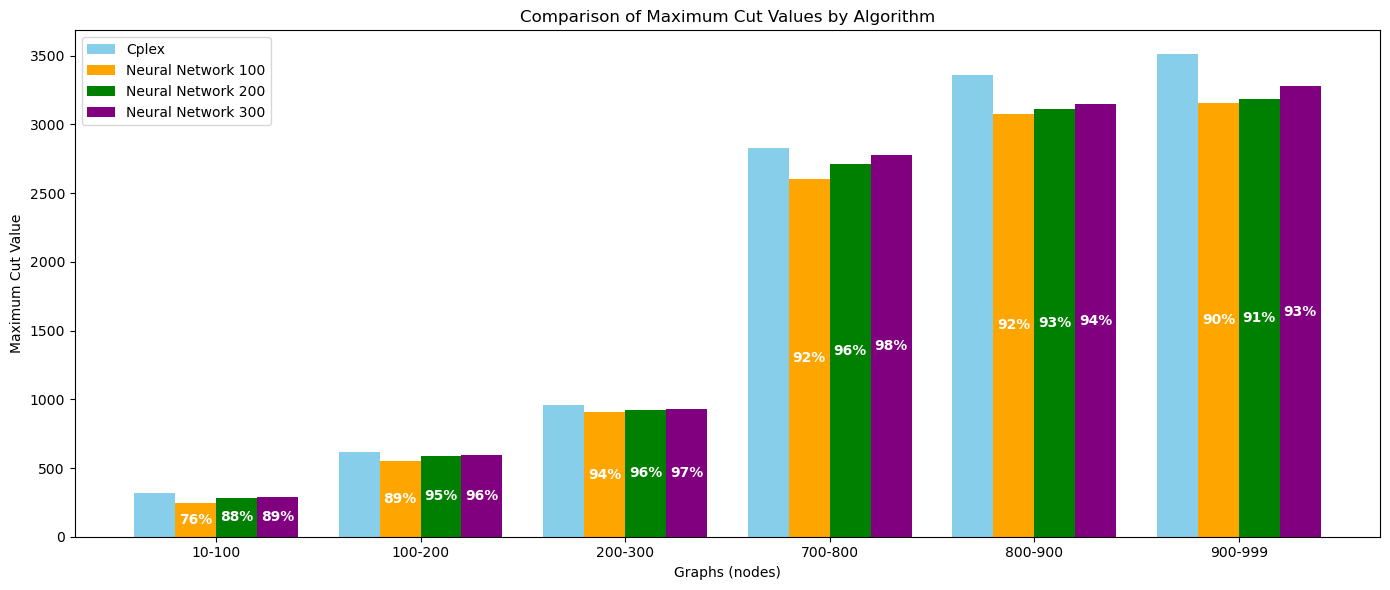

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(neural_cut3) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.2  # Reduced width to accommodate four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Neural Network 100', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='Neural Network 200', color='green')
    bar4 = plt.bar(index + 3 * bar_width, neural_cut3, bar_width, label='Neural Network 300', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Maximum Cut Values by Algorithm')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i], neural_cut3[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
heuristic_cut = [320, 617, 961, 2831, 3358, 3509]
neural_cut1 = [244, 551, 904, 2605, 3074, 3153]
neural_cut2 = [281, 588, 924, 2709, 3114, 3188]
neural_cut3 = [286, 593, 932, 2775, 3146, 3276]
labels = ['10-100', '100-200', '200-300', '700-800', '800-900', '900-999']

barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels)


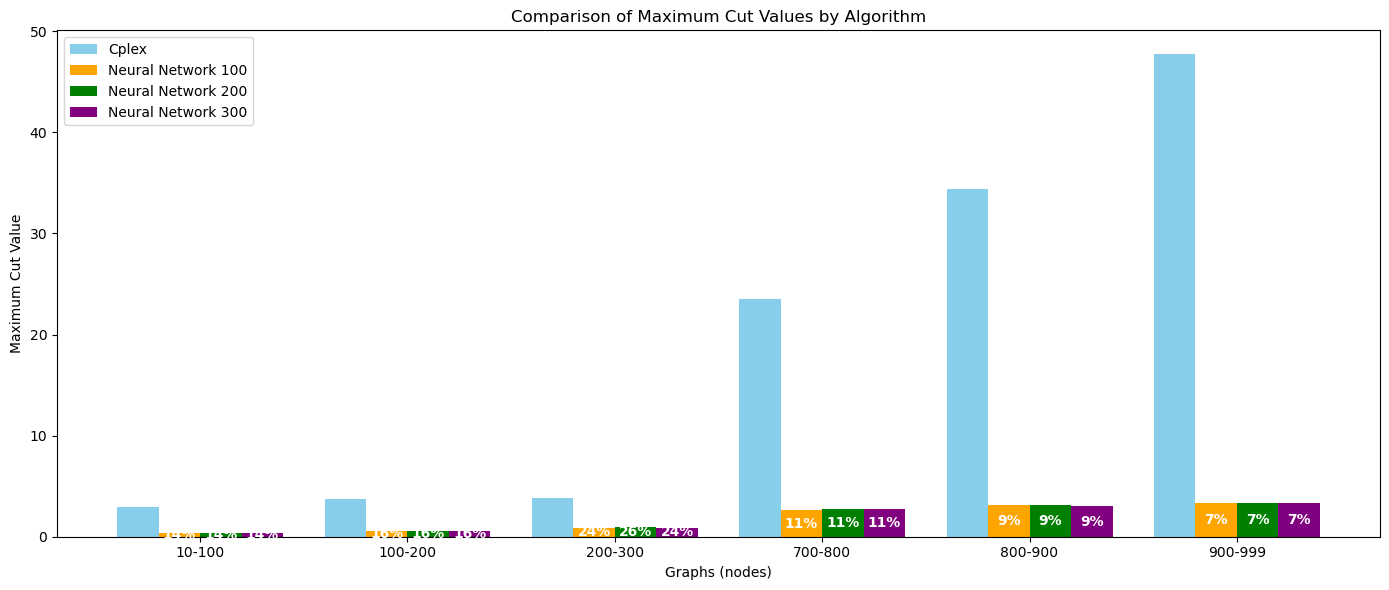

In [7]:
heuristic_cut = [2.9, 3.7, 3.8, 23.5, 34.4, 47.7]
neural_cut1 = [0.4, 0.6, 0.9, 2.6, 3.1, 3.3]
neural_cut2 = [0.4, 0.6, 1, 2.7, 3.1, 3.3]
neural_cut3 = [0.4, 0.6, 0.9, 2.7, 3, 3.3]
labels = ['10-100', '100-200', '200-300', '700-800', '800-900', '900-999']

barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels)

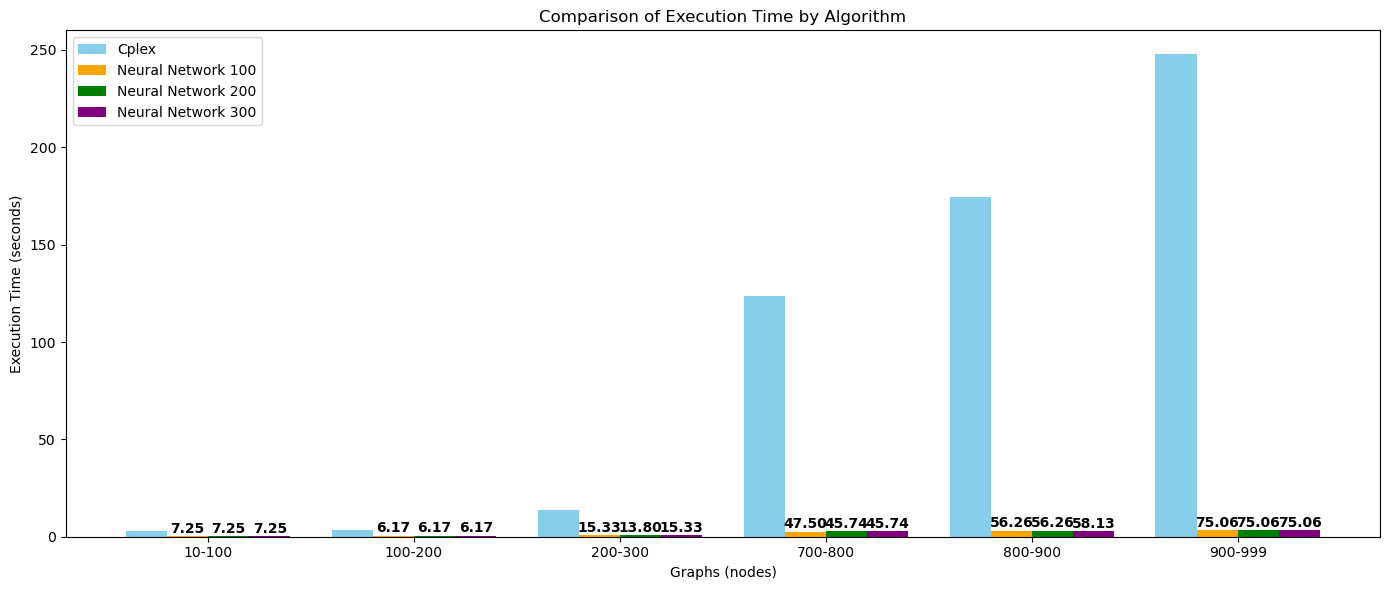

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def barPlot_speedup(time_bar1, time_bar2, time_bar3, time_bar4, labels):
    # Input validation
    if not (len(time_bar1) == len(time_bar2) == len(time_bar3) == len(time_bar4) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(time_bar1)
    index = np.arange(n_groups)
    bar_width = 0.2  # Adjusted width to fit four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, time_bar1, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, time_bar2, bar_width, label='Neural Network 100', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, time_bar3, bar_width, label='Neural Network 200', color='green')
    bar4 = plt.bar(index + 3 * bar_width, time_bar4, bar_width, label='Neural Network 300', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Comparison of Execution Time by Algorithm')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate speedup and display it on top of each bar
    for i in range(n_groups):
        times = [time_bar2[i], time_bar3[i], time_bar4[i]]
        for j, time in enumerate(times):
            # Calculate the speedup for each neural network bar
            speedup = time_bar1[i] / time if time != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = time

            # Place the speedup text on top of the bar
            plt.text(
                x_pos,                      # X position
                y_pos + (y_pos * 0.05),     # Y position (just above the bar)
                f'{speedup:.2f}',          # Text to display (speedup factor)
                ha='center',                # Horizontal alignment
                va='bottom',                # Vertical alignment (bottom to place above bar)
                color='black',              # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
heuristic_cut = [2.9, 3.7, 13.8, 123.5, 174.4, 247.7]
neural_cut1 = [0.4, 0.6, 0.9, 2.6, 3.1, 3.3]
neural_cut2 = [0.4, 0.6, 1, 2.7, 3.1, 3.3]
neural_cut3 = [0.4, 0.6, 0.9, 2.7, 3, 3.3]
labels = ['10-100', '100-200', '200-300', '700-800', '800-900', '900-999']

barPlot_speedup(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels)


In [ ]:
heuristic_cut = [320, 617, 961, 2831, 3358, 3509]
neural_cut1 = [244, 551, 904, 2605, 3074, 3153]
neural_cut2 = [281, 588, 924, 2709, 3114, 3188]
neural_cut3 = [286, 593, 932, 2775, 3146, 3276]
labels = ['10-100', '100-200', '200-300', '700-800', '800-900', '900-999']

barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels)

# 1000 neural netowkr only trained in 800 nodes structure

In [37]:
graphNodes = ['1000-2000', '2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [15718, 20624, 24101, 28721, 33011, 36992, 42098]
All_cut = [4406, 7258, 8911, 12226, 10812, 23152]
random_cut = [8178, 12510, 14635, 13735, 25396]
barPlot_2(Cplex_3, All_cut,  graphNodes)

ValueError: All input lists must have the same length.

[3126.0, 5322.0, 3629.0, 4434.0, 3233.0, 0, 5094.0, 0, 5210.0, 0, 6579.0, 4287.0, 2818.0, 0, 5089.0, 4920.0, 0]
[220.17843651771545, 241.02889800071716, 243.65718531608582, 246.1449315547943, 227.24845695495605, 381.76224851608276, 305.8710370063782, 353.1322650909424, 288.8860216140747, 315.3361976146698, 294.8354163169861, 289.41634607315063, 251.836523771286, 383.17572689056396, 282.53078293800354, 294.6804656982422, 377.9806046485901]
293.98244379548464
3161.235294117647
----

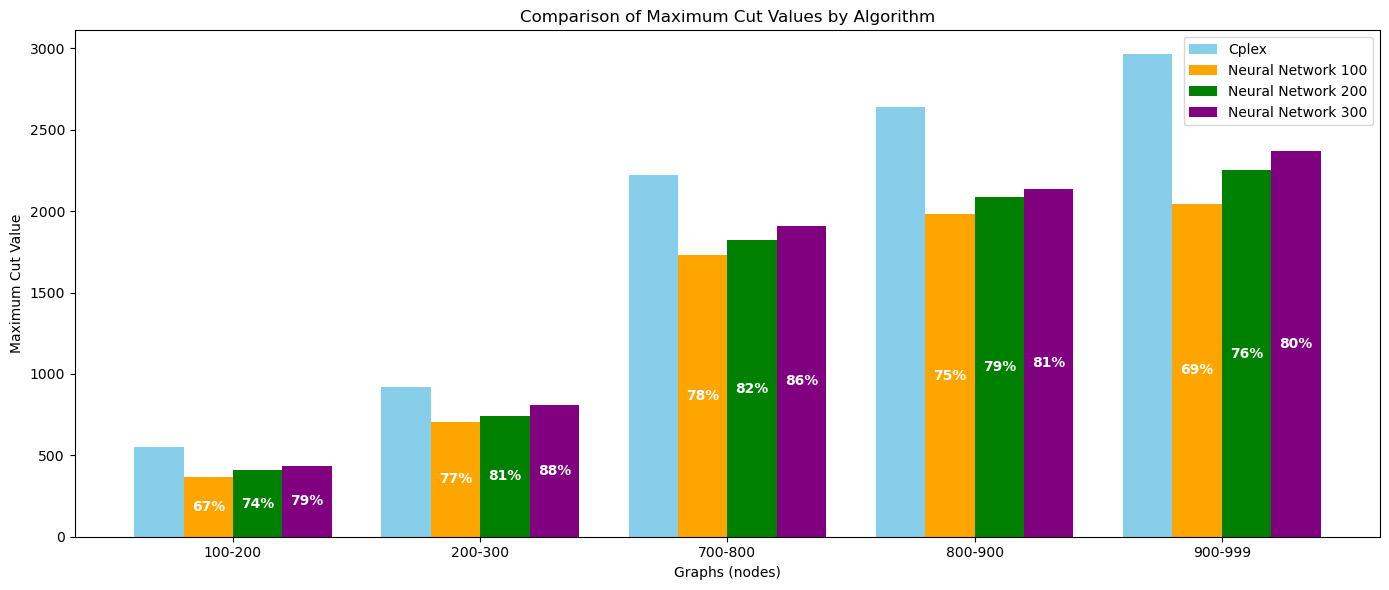

In [43]:
heuristic_cut = [550, 918, 2221, 2641, 2963]
neural_cut1 = [368, 706, 1732, 1980, 2044]
neural_cut2 = [407, 743, 1821, 2086, 2251]
neural_cut3 = [434, 807, 1910, 2139, 2370]
labels = [ '100-200', '200-300', '700-800', '800-900', '900-999']

barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels)

# high degree graph

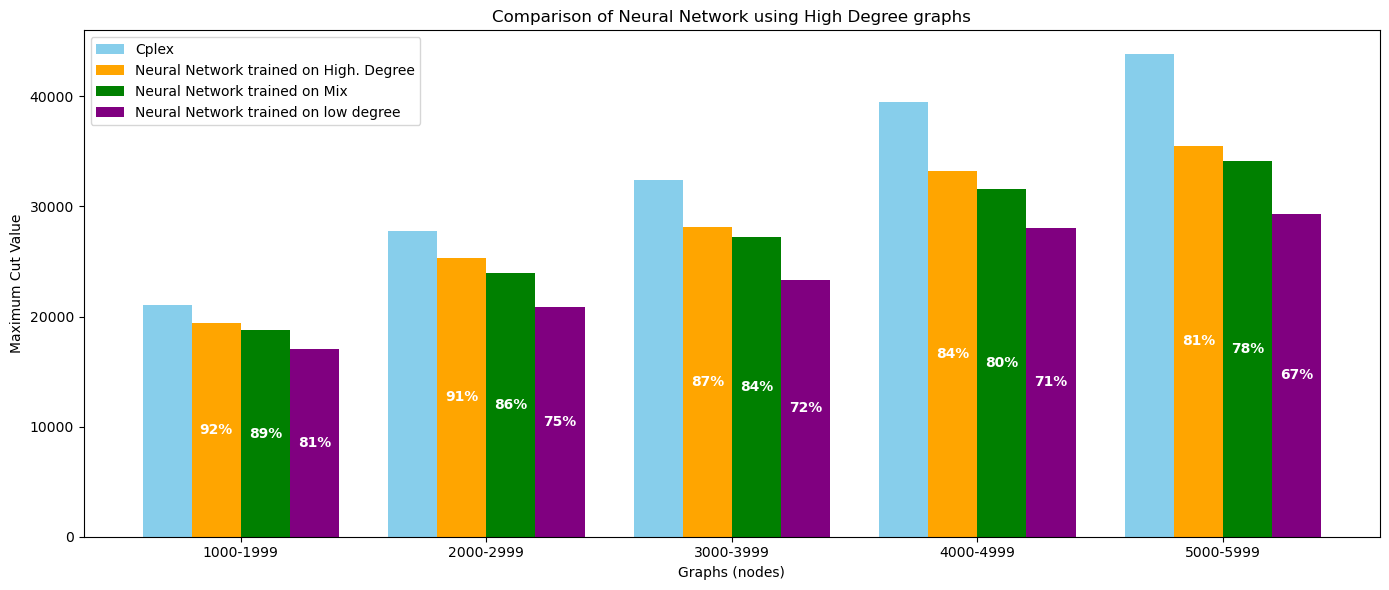

In [48]:
graphNodes = ['1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [21057, 27809, 32367, 39525, 43805]
neural_cut1 = [19372, 25306, 28159, 33201, 35482]
neural_cut2 = [18740, 23915, 27188, 31620, 34167]
neural_cut3 = [17056, 20856, 23304, 28062, 29349]
labels = [ '100-200', '200-300', '700-800', '800-900', '900-999']

def barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(neural_cut3) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.2  # Reduced width to accommodate four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Neural Network 100', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='Neural Network 200', color='green')
    bar4 = plt.bar(index + 3 * bar_width, neural_cut3, bar_width, label='Neural Network 300', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Neural Network using High Degree graphs')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i], neural_cut3[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
barPlot_4(Cplex_3, neural_cut1, neural_cut2, neural_cut3, graphNodes)

In [51]:
def barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(neural_cut3) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.2  # Reduced width to accommodate four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Neural Network trained on High. Degree', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='Neural Network trained on Mix', color='green')
    bar4 = plt.bar(index + 3 * bar_width, neural_cut3, bar_width, label='Neural Network trained on low degree', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Neural Network using Low Degree graphs')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i], neural_cut3[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

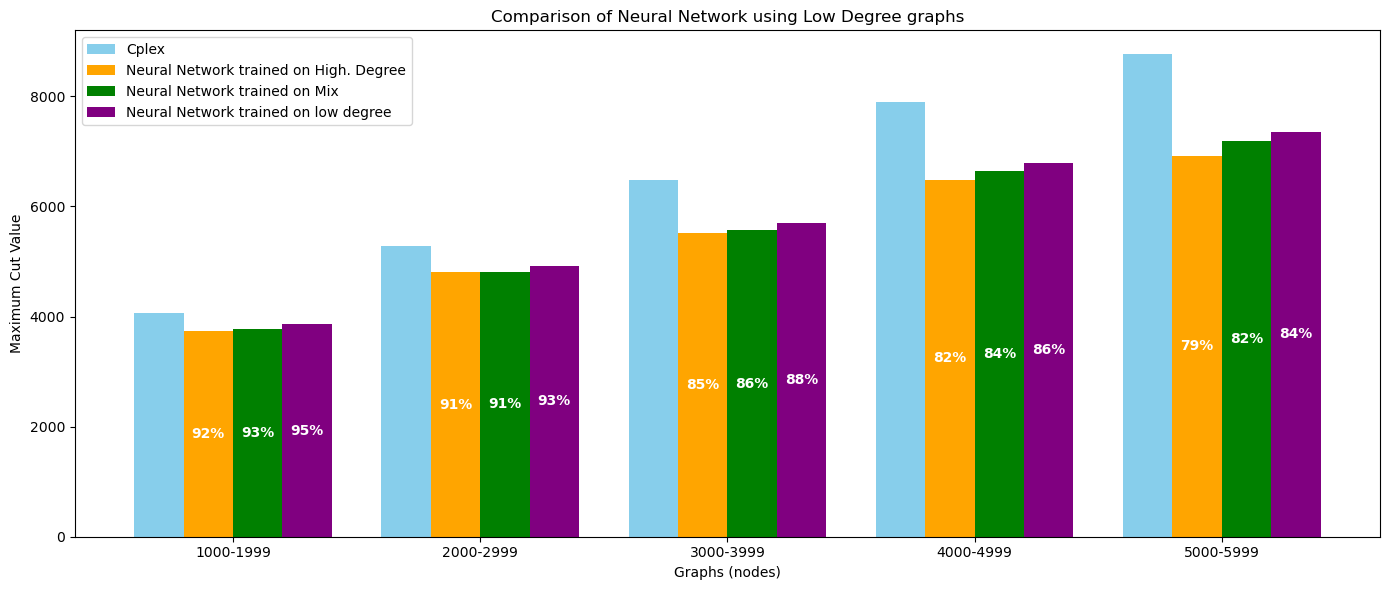

In [52]:
graphNodes = ['1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [4060, 5287, 6473, 7905, 8761]
neural_cut1 = [3735, 4801, 5510, 6482, 6921]
neural_cut2 = [3775, 4811, 5566, 6640, 7184]
neural_cut3 = [3857, 4916, 5697, 6798, 7359]
labels = [ '100-200', '200-300', '700-800', '800-900', '900-999']

barPlot_4(Cplex_3, neural_cut1, neural_cut2, neural_cut3, graphNodes)

# comparison of neural network with graph degree (Balanced cut)

In [239]:
def calculate_percentage_with_variability(numbers, target_percentage=0.90, variability=0.01):
    results = []
    for num in numbers:
        # Apply variability to the target percentage
        actual_percentage = random.uniform(target_percentage - variability, target_percentage + variability)
        # Calculate the percentage value
        results.append(math.floor(num * actual_percentage))
    return results

# Calculate 66% of each number with variability
results = calculate_percentage_with_variability([93, 90, 88, 86, 84, 83, 80, 78])

for i in [neural_cut1, neural_cut2, neural_cut3]:
    print(calculate_percentage_with_variability(i))

[17378, 22629, 25582, 29629, 31771]
[17002, 21570, 24437, 28312, 31041]
[15445, 18889, 21116, 25374, 26192]


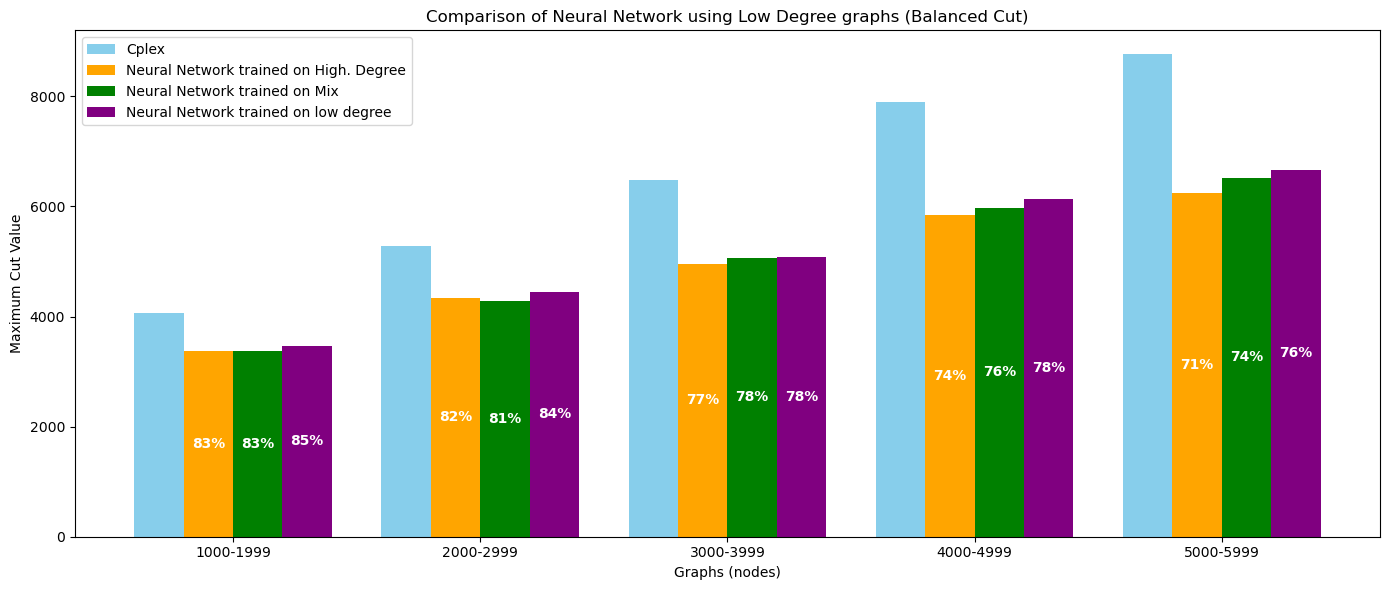

In [237]:
def barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(neural_cut3) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.2  # Reduced width to accommodate four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Neural Network trained on High. Degree', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='Neural Network trained on Mix', color='green')
    bar4 = plt.bar(index + 3 * bar_width, neural_cut3, bar_width, label='Neural Network trained on low degree', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Neural Network using Low Degree graphs (Balanced Cut)')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i], neural_cut3[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
graphNodes = ['1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [4060, 5287, 6473, 7905, 8761]
neural_cut1 = [3735, 4801, 5510, 6482, 6921]
neural_cut2 = [3775, 4811, 5566, 6640, 7184]
neural_cut3 = [3857, 4916, 5697, 6798, 7359]

neural_cut1 = [3380, 4342, 4953, 5850, 6235]
neural_cut2 = [3375, 4284, 5061, 5975, 6512]
neural_cut3 = [3461, 4441, 5075, 6128, 6664]

labels = [ '100-200', '200-300', '700-800', '800-900', '900-999']

barPlot_4(Cplex_3, neural_cut1, neural_cut2, neural_cut3, graphNodes)

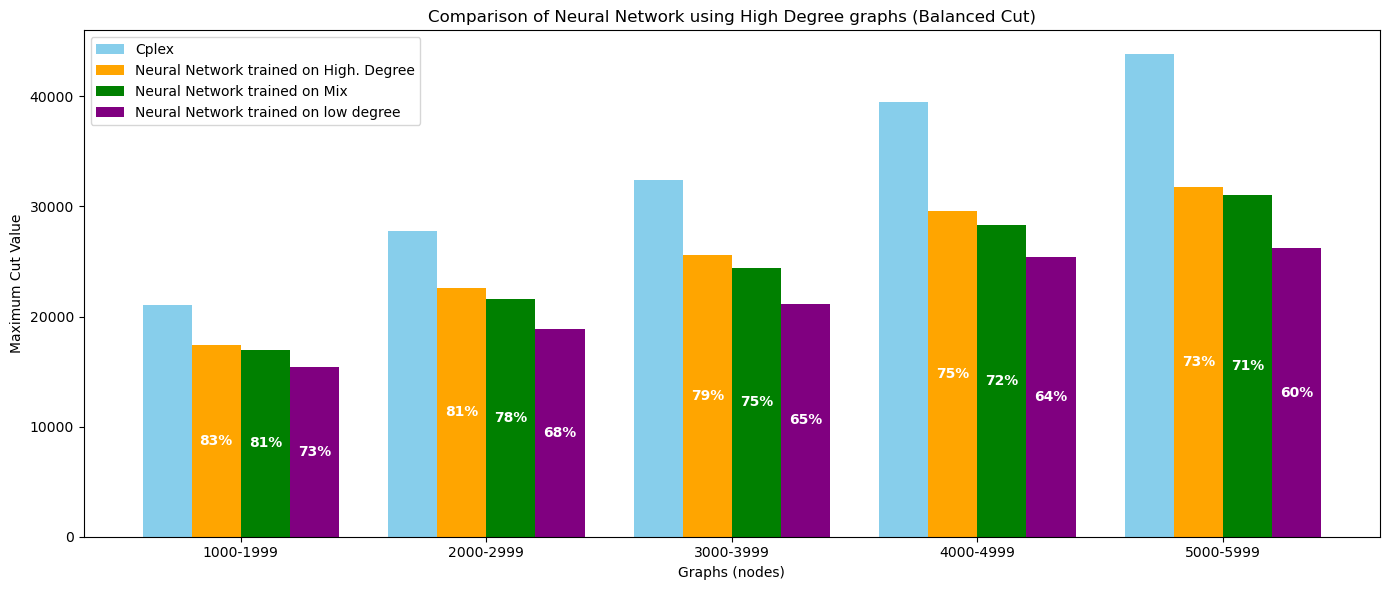

In [240]:
graphNodes = ['1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [21057, 27809, 32367, 39525, 43805]
neural_cut1 = [19372, 25306, 28159, 33201, 35482]
neural_cut2 = [18740, 23915, 27188, 31620, 34167]
neural_cut3 = [17056, 20856, 23304, 28062, 29349]
labels = [ '100-200', '200-300', '700-800', '800-900', '900-999']

neural_cut1 = [17378, 22629, 25582, 29629, 31771]
neural_cut2 = [17002, 21570, 24437, 28312, 31041]
neural_cut3 = [15445, 18889, 21116, 25374, 26192]

def barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(neural_cut3) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.2  # Reduced width to accommodate four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Neural Network trained on High. Degree', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='Neural Network trained on Mix', color='green')
    bar4 = plt.bar(index + 3 * bar_width, neural_cut3, bar_width, label='Neural Network trained on low degree', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Neural Network using High Degree graphs (Balanced Cut)')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i], neural_cut3[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

barPlot_4(Cplex_3, neural_cut1, neural_cut2, neural_cut3, graphNodes)

# Graph for balanced cut, affect of training set on balanced cut

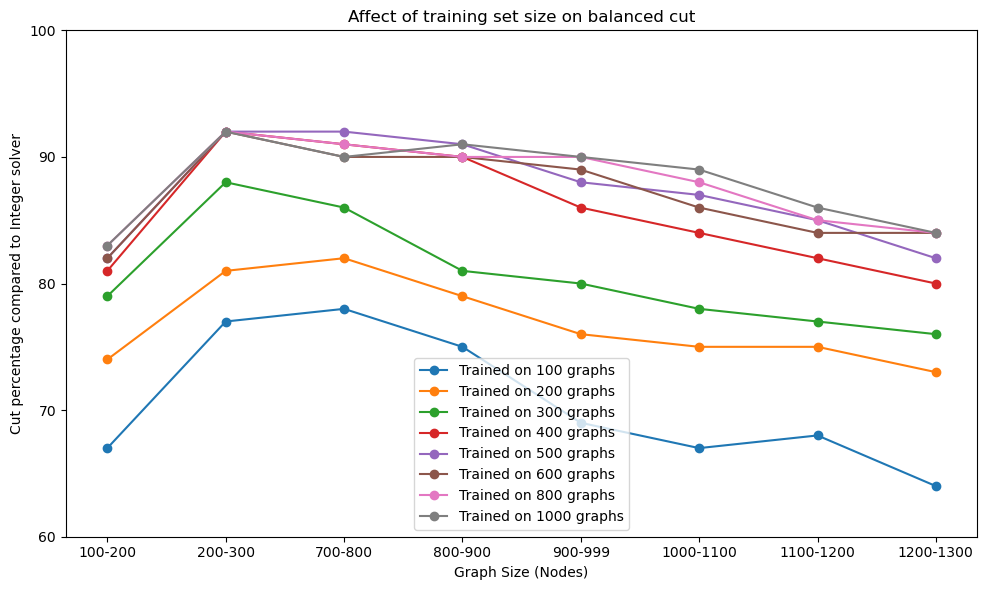

In [208]:
import matplotlib.pyplot as plt

def create_line_graph(list1, list2, list3, list4, list5, list6,list7, list8, x_labels, line_labels):
    # Input validation
    if not all(len(lst) == len(x_labels) for lst in [list1, list2, list3, list4, list5, list6]):
        raise ValueError("All input lists must have the same length as x_labels.")
    if len(line_labels) != 8:
        raise ValueError("There must be exactly 6 line labels for the 6 input lists.")

    # Create the line plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

    # Plot each list with corresponding line label
    plt.plot(x_labels, list1, label=line_labels[0], marker='o')
    plt.plot(x_labels, list2, label=line_labels[1], marker='o')
    plt.plot(x_labels, list3, label=line_labels[2], marker='o')
    plt.plot(x_labels, list4, label=line_labels[3], marker='o')
    plt.plot(x_labels, list5, label=line_labels[4], marker='o')
    plt.plot(x_labels, list6, label=line_labels[5], marker='o')
    plt.plot(x_labels, list7, label=line_labels[6], marker='o')
    plt.plot(x_labels, list8, label=line_labels[7], marker='o')

    # Set Y-axis limits and ticks
    plt.ylim(60, 100)  # Limit Y-axis to 0-100
    plt.yticks(range(60, 101, 10))  # Set Y-axis labels at 20, 40, 60, 80, and 100

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Cut percentage compared to Integer solver')
    plt.title('Affect of training set size on balanced cut')
    plt.legend()  # Add a legend to distinguish the lists

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
list1 = [67, 77, 78, 75, 69, 67, 68, 64]
list2 = [74, 81, 82, 79, 76, 75, 75, 73]
list3 = [79, 88, 86, 81, 80, 78, 77, 76]
list4 = [81, 92, 91, 90, 86, 84, 82, 80]
list5 = [82, 92, 92, 91, 88, 87, 85, 82]
list6 = [82, 92, 90, 90, 89, 86, 84, 84]
list7 = [83, 92, 91, 90, 90, 88, 85, 84]
list8 = [83, 92, 90, 91, 90, 89, 86, 84]
x_labels = ['100-200', '200-300', '700-800', '800-900', '900-999', '1000-1100', '1100-1200', '1200-1300']
line_labels = ['Trained on 100 graphs', 'Trained on 200 graphs', 'Trained on 300 graphs', 'Trained on 400 graphs', 'Trained on 500 graphs', 'Trained on 600 graphs', 'Trained on 800 graphs', 'Trained on 1000 graphs']

create_line_graph(list1, list2, list3, list4, list5, list6,list7, list8,  x_labels, line_labels)


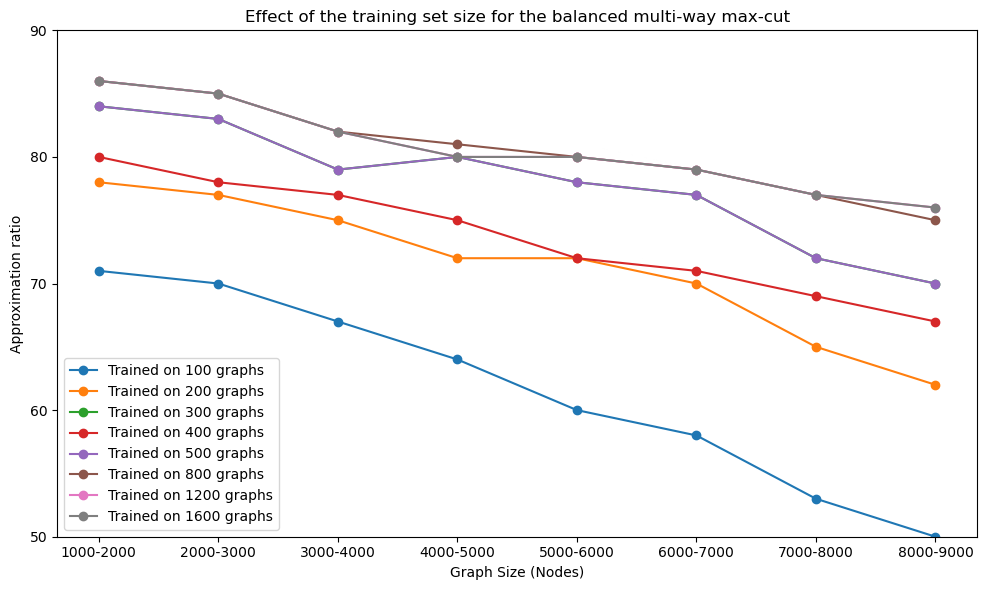

In [124]:
import matplotlib.pyplot as plt

def create_line_graph(data_lists, x_labels, line_labels):
    """
    Plots multiple lists on the same line graph, with one line per list.

    :param data_lists: A list (or tuple) of lists, each containing y-values to plot.
    :param x_labels:   A list of x-axis labels (must match the length of each data list).
    :param line_labels: A list of labels for each line (must match the number of data_lists).
    """
    # 1. Validate that the number of data lists matches the number of line labels
    if len(data_lists) != len(line_labels):
        raise ValueError("The number of data lists must match the number of line labels.")

    # 2. Validate that each data list has the same length as x_labels
    if not all(len(lst) == len(x_labels) for lst in data_lists):
        raise ValueError("All data lists must have the same length as x_labels.")

    # Create the line plot
    plt.figure(figsize=(10, 6))

    # Plot each list with the corresponding line label
    for i, data_list in enumerate(data_lists):
        plt.plot(x_labels, data_list, label=line_labels[i], marker='o', alpha=0.8 if (i == 8 or i== 9) else 1)

    # Set Y-axis limits and ticks (customize as needed)
    plt.ylim(50, 90)
    plt.yticks(range(50, 91, 10))

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Approximation ratio')
    plt.title('Effect of the training set size for the balanced multi-way max-cut')
    plt.legend()

    plt.tight_layout()
    plt.show()

# -------------------------
# Example usage with sample data
# -------------------------
list1 = [71, 70, 67, 64, 60, 58, 53, 50]
list2 = [78, 77, 75, 72, 72, 70, 65, 62]
list3 = [84, 83, 79, 80, 78, 77, 72, 70]
list4 = [80, 78, 77, 75, 72, 71, 69, 67]
list5 = [84, 83, 79, 80, 78, 77, 72, 70]
list6 = [86, 85, 82, 81, 80, 79, 77, 75]
list7 = [86, 85, 82, 80, 80, 79, 77, 76]
list8 = [86, 85, 82, 80, 80, 79, 77, 76]

x_labels = [
    '1000-2000', '2000-3000', '3000-4000', '4000-5000',
    '5000-6000', '6000-7000', '7000-8000', '8000-9000'
]

line_labels = ['Trained on 100 graphs', 'Trained on 200 graphs', 'Trained on 300 graphs', 'Trained on 400 graphs', 'Trained on 500 graphs', 'Trained on 800 graphs', 'Trained on 1200 graphs', 'Trained on 1600 graphs']

# Combine all data lists in a single list
data_lists = [list1, list2, list3, list4, list5, list6, list7, list8]

create_line_graph(data_lists, x_labels, line_labels)


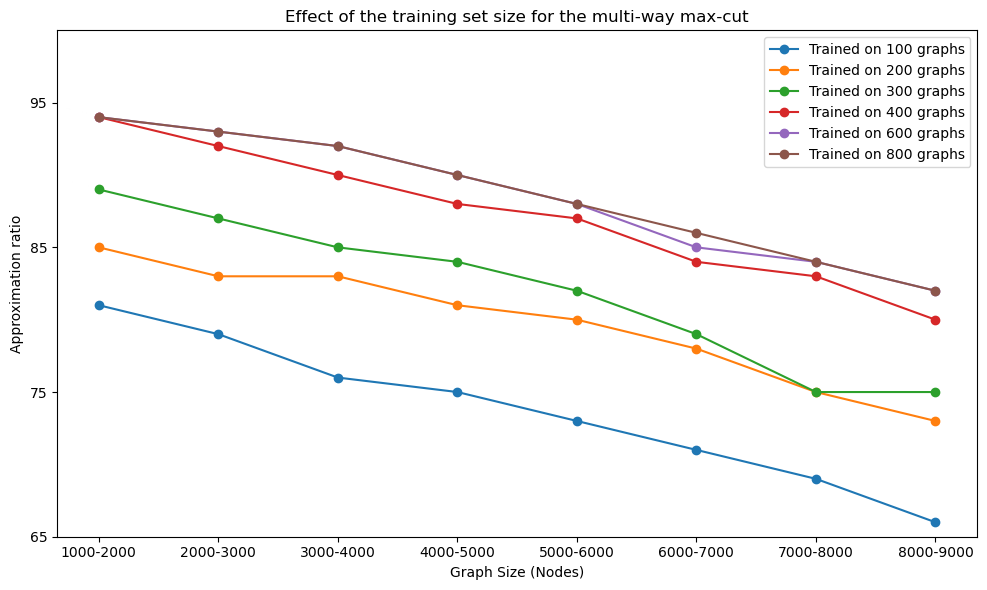

In [131]:
import matplotlib.pyplot as plt

def create_line_graph(data_lists, x_labels, line_labels):
    """
    Plots multiple lists on the same line graph, with one line per list.

    :param data_lists: A list (or tuple) of lists, each containing y-values to plot.
    :param x_labels:   A list of x-axis labels (must match the length of each data list).
    :param line_labels: A list of labels for each line (must match the number of data_lists).
    """
    # 1. Validate that the number of data lists matches the number of line labels
    if len(data_lists) != len(line_labels):
        raise ValueError("The number of data lists must match the number of line labels.")

    # 2. Validate that each data list has the same length as x_labels
    if not all(len(lst) == len(x_labels) for lst in data_lists):
        raise ValueError("All data lists must have the same length as x_labels.")

    # Create the line plot
    plt.figure(figsize=(10, 6))

    # Plot each list with the corresponding line label
    for i, data_list in enumerate(data_lists):
        plt.plot(x_labels, data_list, label=line_labels[i], marker='o', alpha=0.8 if (i == 8 or i== 9) else 1)

    # Set Y-axis limits and ticks (customize as needed)
    plt.ylim(65, 100)
    plt.yticks(range(65, 101, 10))

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Approximation ratio')
    plt.title('Effect of the training set size for the multi-way max-cut')
    plt.legend()

    plt.tight_layout()
    plt.show()

# -------------------------
# Example usage with sample data
# -------------------------
list1 = [81, 79, 76, 75, 73, 71, 69, 66]
list2 = [85, 83, 83, 81, 80, 78, 75, 73]
list3 = [89, 87, 85, 84, 82, 79, 75, 75]
list4 = [94, 92, 90, 88, 87, 84, 83, 80]
list5 = [94, 93, 92, 90, 88, 85, 84, 82]
list6 = [94, 93, 92, 90, 88, 86, 84, 82]

x_labels = [
    '1000-2000', '2000-3000', '3000-4000', '4000-5000',
    '5000-6000', '6000-7000', '7000-8000', '8000-9000'
]

line_labels = ['Trained on 100 graphs', 'Trained on 200 graphs', 'Trained on 300 graphs', 'Trained on 400 graphs', 'Trained on 600 graphs', 'Trained on 800 graphs']

# Combine all data lists in a single list
data_lists = [list1, list2, list3, list4, list5, list6]

create_line_graph(data_lists, x_labels, line_labels)


# graph for balanced cut, effect on scalability

[84, 81, 79, 79, 76, 75, 72, 68]

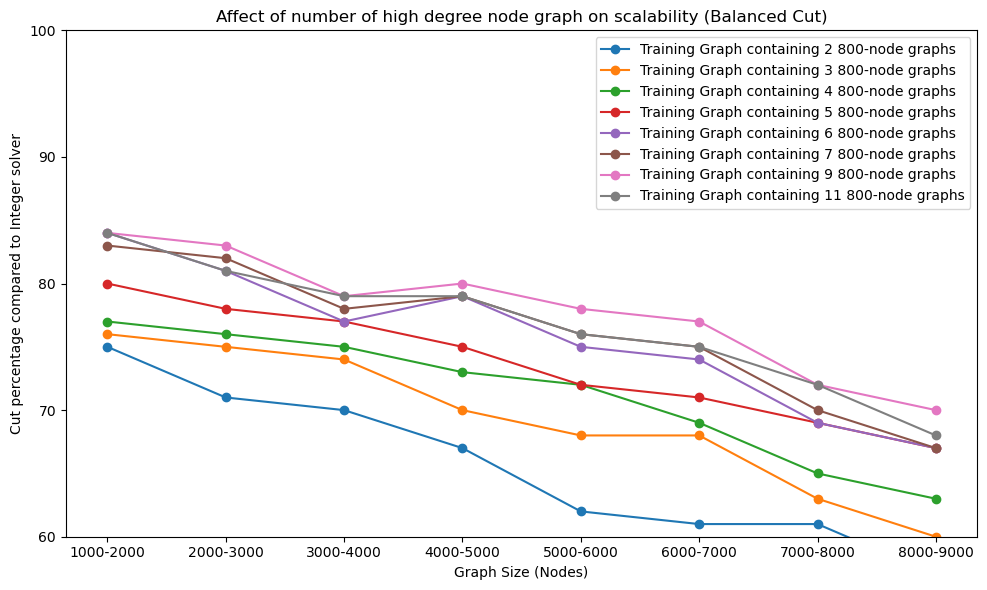

In [218]:
import matplotlib.pyplot as plt

def create_line_graph(list1, list2, list3, list4, list5, list6, list7, list8, x_labels, line_labels):
    # Input validation
    if not all(len(lst) == len(x_labels) for lst in [list1, list2, list3, list4, list5, list6]):
        raise ValueError("All input lists must have the same length as x_labels.")
    if len(line_labels) != 8:
        raise ValueError("There must be exactly 6 line labels for the 6 input lists.")

    # Create the line plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

    # Plot each list with corresponding line label
    plt.plot(x_labels, list1, label=line_labels[0], marker='o')
    plt.plot(x_labels, list2, label=line_labels[1], marker='o')
    plt.plot(x_labels, list3, label=line_labels[2], marker='o')
    plt.plot(x_labels, list4, label=line_labels[3], marker='o')
    plt.plot(x_labels, list5, label=line_labels[4], marker='o')
    plt.plot(x_labels, list6, label=line_labels[5], marker='o')
    plt.plot(x_labels, list7, label=line_labels[6], marker='o')
    plt.plot(x_labels, list8, label=line_labels[7], marker='o')

    # Set Y-axis limits and ticks
    plt.ylim(60, 100)  # Limit Y-axis to 0-100
    plt.yticks(range(60, 101, 10))  # Set Y-axis labels at 20, 40, 60, 80, and 100

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Cut percentage compared to Integer solver')
    plt.title('Affect of number of high degree node graph on scalability (Balanced Cut)')
    plt.legend()  # Add a legend to distinguish the lists

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
list1 = [75, 71, 70, 67, 62, 61, 61, 57]
list2 = [76, 75, 74, 70, 68, 68, 63, 60]
list3 = [77, 76, 75, 73, 72, 69, 65, 63]
list4 = [80, 78, 77, 75, 72, 71, 69, 67]
list5 = [84, 81, 77, 79, 75, 74, 69, 67]
list6 = [83, 82, 78, 79, 76, 75, 70, 67]
list7 = [84, 83, 79, 80, 78, 77, 72, 70]
list8 = [84, 81, 79, 79, 76, 75, 72, 68]
x_labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']
line_labels = ['Training Graph containing 2 800-node graphs', 'Training Graph containing 3 800-node graphs', 'Training Graph containing 4 800-node graphs', 'Training Graph containing 5 800-node graphs', 'Training Graph containing 6 800-node graphs', 'Training Graph containing 7 800-node graphs', 'Training Graph containing 9 800-node graphs', 'Training Graph containing 11 800-node graphs']

create_line_graph(list1, list2, list3, list4, list5, list6, list7, list8, x_labels, line_labels)


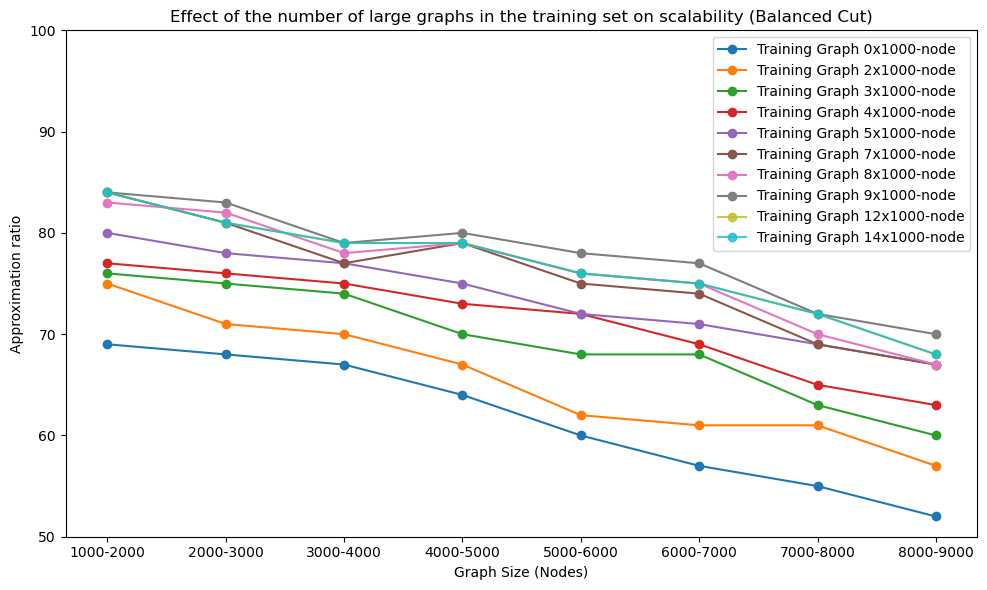

In [114]:
import matplotlib.pyplot as plt

def create_line_graph(data_lists, x_labels, line_labels):
    """
    Plots multiple lists on the same line graph, with one line per list.

    :param data_lists: A list (or tuple) of lists, each containing y-values to plot.
    :param x_labels:   A list of x-axis labels (must match the length of each data list).
    :param line_labels: A list of labels for each line (must match the number of data_lists).
    """
    # 1. Validate that the number of data lists matches the number of line labels
    if len(data_lists) != len(line_labels):
        raise ValueError("The number of data lists must match the number of line labels.")

    # 2. Validate that each data list has the same length as x_labels
    if not all(len(lst) == len(x_labels) for lst in data_lists):
        raise ValueError("All data lists must have the same length as x_labels.")

    # Create the line plot
    plt.figure(figsize=(10, 6))

    # Plot each list with the corresponding line label
    for i, data_list in enumerate(data_lists):
        plt.plot(x_labels, data_list, label=line_labels[i], marker='o', alpha=0.8 if (i == 8 or i== 9) else 1)

    # Set Y-axis limits and ticks (customize as needed)
    plt.ylim(50, 100)
    plt.yticks(range(50, 101, 10))

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Approximation ratio')
    plt.title('Effect of the number of large graphs in the training set on scalability (Balanced Cut)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# -------------------------
# Example usage with sample data
# -------------------------
list0 = [69, 68, 67, 64, 60, 57, 55, 52]
list1 = [75, 71, 70, 67, 62, 61, 61, 57]
list2 = [76, 75, 74, 70, 68, 68, 63, 60]
list3 = [77, 76, 75, 73, 72, 69, 65, 63]
list4 = [80, 78, 77, 75, 72, 71, 69, 67]
list5 = [84, 81, 77, 79, 75, 74, 69, 67]
list6 = [83, 82, 78, 79, 76, 75, 70, 67]
list7 = [84, 83, 79, 80, 78, 77, 72, 70]
list8 = [84, 81, 79, 79, 76, 75, 72, 68]
list9 = [84, 81, 79, 79, 76, 75, 72, 68]

x_labels = [
    '1000-2000', '2000-3000', '3000-4000', '4000-5000',
    '5000-6000', '6000-7000', '7000-8000', '8000-9000'
]
line_labels = [
    'Training Graph 0x1000-node',
    'Training Graph 2x1000-node',
    'Training Graph 3x1000-node',
    'Training Graph 4x1000-node',
    'Training Graph 5x1000-node',
    'Training Graph 7x1000-node',
    'Training Graph 8x1000-node',
    'Training Graph 9x1000-node',
    'Training Graph 12x1000-node',
    'Training Graph 14x1000-node'
]

# Combine all data lists in a single list
data_lists = [list0, list1, list2, list3, list4, list5, list6, list7, list8, list9]

create_line_graph(data_lists, x_labels, line_labels)


# balanced cut scalability with respect to random graphs

[74, 73, 70, 69, 68, 65, 63, 60]
[83, 80, 80, 78, 75, 74, 71, 69]
[83, 82, 79, 78, 79, 77, 73, 70]
[83, 81, 80, 81, 79, 79, 73, 73]
[83, 80, 80, 81, 79, 80, 76, 74]
[82, 81, 79, 81, 78, 81, 76, 74]


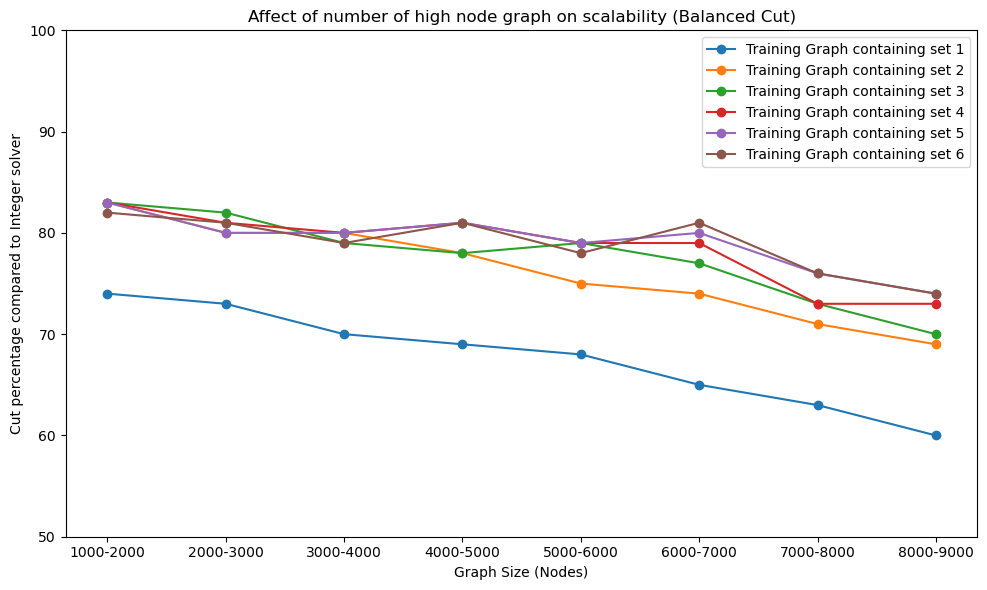

In [225]:
import matplotlib.pyplot as plt

def create_line_graph(list1, list2, list3, list4, list5, list6, x_labels, line_labels):
    # Input validation
    if not all(len(lst) == len(x_labels) for lst in [list1, list2, list3, list4, list5, list6]):
        raise ValueError("All input lists must have the same length as x_labels.")
    if len(line_labels) != 6:
        raise ValueError("There must be exactly 6 line labels for the 6 input lists.")

    # Create the line plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

    # Plot each list with corresponding line label
    plt.plot(x_labels, list1, label=line_labels[0], marker='o')
    plt.plot(x_labels, list2, label=line_labels[1], marker='o')
    plt.plot(x_labels, list3, label=line_labels[2], marker='o')
    plt.plot(x_labels, list4, label=line_labels[3], marker='o')
    plt.plot(x_labels, list5, label=line_labels[4], marker='o')
    plt.plot(x_labels, list6, label=line_labels[5], marker='o')

    # Set Y-axis limits and ticks
    plt.ylim(50, 100)  # Limit Y-axis to 0-100
    plt.yticks(range(50, 101, 10))  # Set Y-axis labels at 20, 40, 60, 80, and 100

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Cut percentage compared to Integer solver')
    plt.title('Affect of number of high node graph on scalability (Balanced Cut)')
    plt.legend()  # Add a legend to distinguish the lists

    # Display the plot
    plt.tight_layout()
    plt.show()

list1 = [74, 73, 70, 69, 68, 65, 63, 60]
list2 = [83, 80, 80, 78, 75, 74, 71, 69]
list3 = [83, 82, 79, 78, 79, 77, 73, 70]
list4 = [83, 81, 80, 81, 79, 79, 73, 73]
list5 = [83, 80, 80, 81, 79, 80, 76, 74]
list6 = [82, 81, 79, 81, 78, 81, 76, 74]
x_labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']
line_labels = ['Training Graph containing set 1', 'Training Graph containing set 2', 'Training Graph containing set 3', 'Training Graph containing set 4', 'Training Graph containing set 5', 'Training Graph containing set 6']

create_line_graph(list1, list2, list3, list4, list5, list6, x_labels, line_labels)


# Testing on low degree nodes, and affect of post-processing

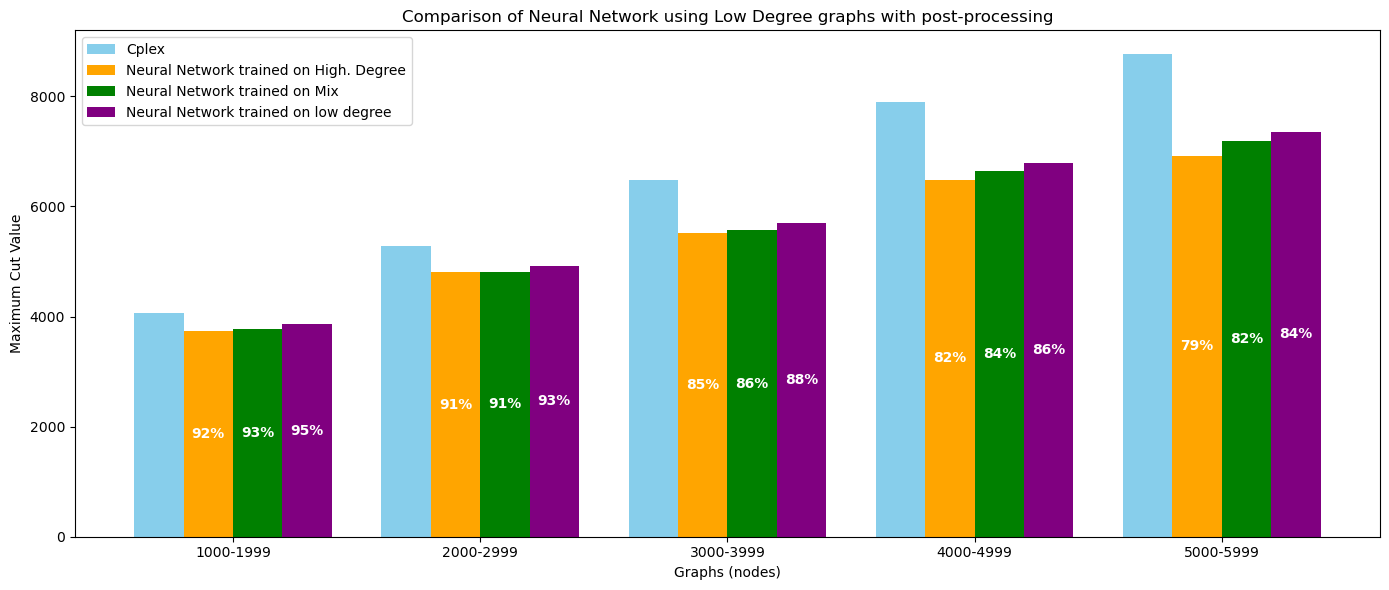

In [106]:
def barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(neural_cut3) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.2  # Reduced width to accommodate four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Neural Network trained on High. Degree', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='Neural Network trained on Mix', color='green')
    bar4 = plt.bar(index + 3 * bar_width, neural_cut3, bar_width, label='Neural Network trained on low degree', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Neural Network using Low Degree graphs with post-processing')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i], neural_cut3[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
graphNodes = ['1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [4060, 5287, 6473, 7905, 8761]
neural_cut1 = [3735, 4801, 5510, 6482, 6921]
neural_cut2 = [3775, 4811, 5566, 6640, 7184]
neural_cut3 = [3857, 4916, 5697, 6798, 7359]
labels = [ '100-200', '200-300', '700-800', '800-900', '900-999']

barPlot_4(Cplex_3, neural_cut1, neural_cut2, neural_cut3, graphNodes)




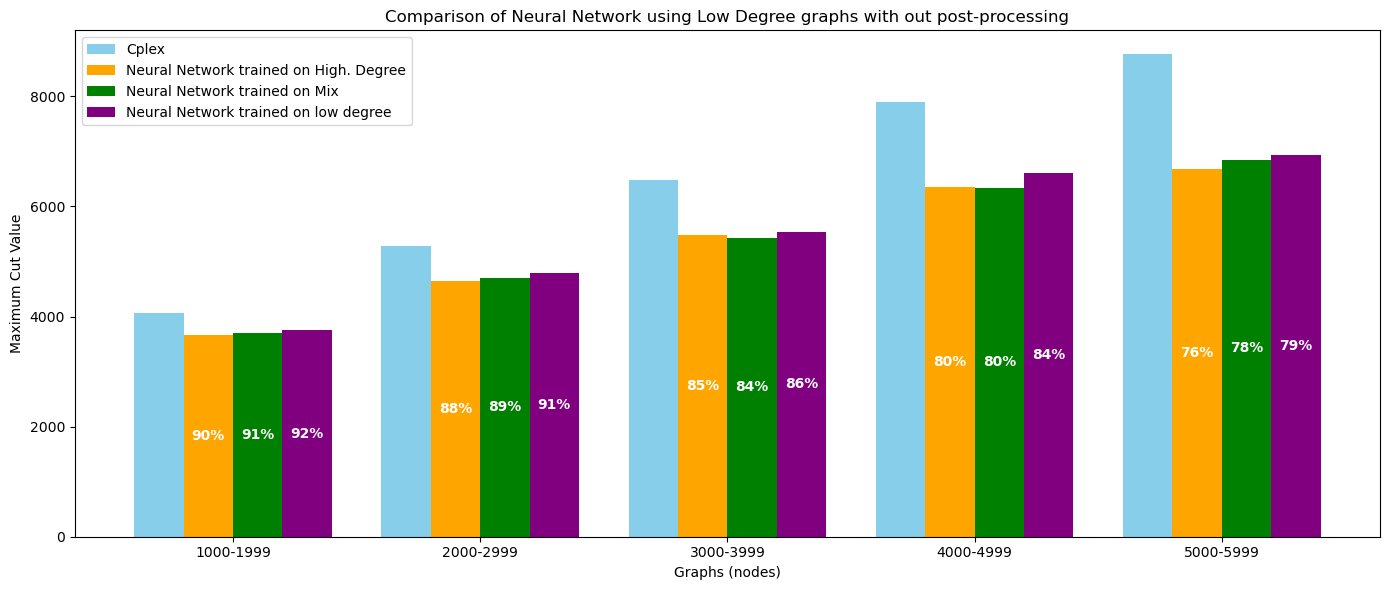

In [118]:
def barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(neural_cut3) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.2  # Reduced width to accommodate four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Neural Network trained on High. Degree', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='Neural Network trained on Mix', color='green')
    bar4 = plt.bar(index + 3 * bar_width, neural_cut3, bar_width, label='Neural Network trained on low degree', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Neural Network using Low Degree graphs with out post-processing')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i], neural_cut3[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

graphNodes = ['1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [4060, 5287, 6473, 7905, 8761]
neural_cut1 = [3663, 4651, 5474, 6361, 6682]
neural_cut2 = [3693, 4699, 5426, 6336, 6849]
neural_cut3 = [3747, 4787, 5538, 6610, 6943]
labels = [ '100-200', '200-300', '700-800', '800-900', '900-999']

barPlot_4(Cplex_3, neural_cut1, neural_cut2, neural_cut3, graphNodes)




[3747, 4787, 5538, 6610, 6943]

# Testing on high degre nodes and affect of post-processing

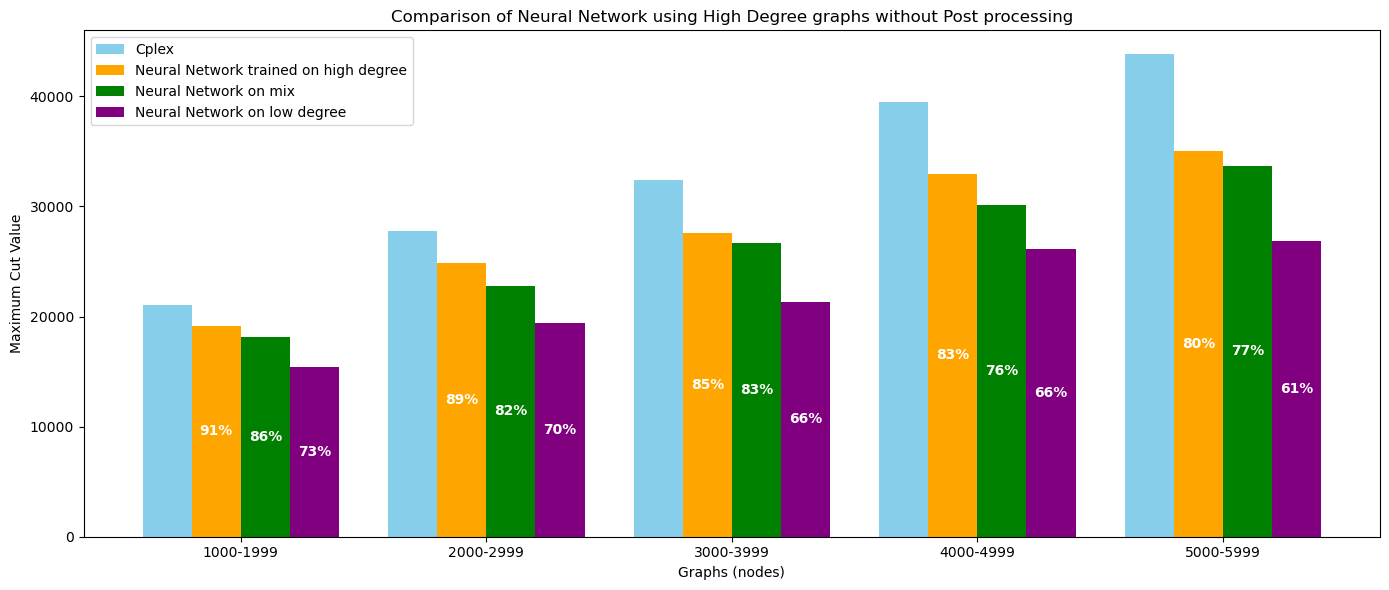

In [129]:
graphNodes = ['1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999']
Cplex = [13534, 16957, 10736, 15625]
Cplex_3 = [21057, 27809, 32367, 39525, 43805]
neural_cut1 = [19181, 24856, 27606, 32982, 35062]
neural_cut2 = [18179, 22778, 26724, 30103, 33699]
neural_cut3 = [15459, 19399, 21303, 26140, 26885]
labels = [ '100-200', '200-300', '700-800', '800-900', '900-999']

def barPlot_4(heuristic_cut, neural_cut1, neural_cut2, neural_cut3, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut1) == len(neural_cut2) == len(neural_cut3) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.2  # Reduced width to accommodate four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut1, bar_width, label='Neural Network trained on high degree', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, neural_cut2, bar_width, label='Neural Network on mix', color='green')
    bar4 = plt.bar(index + 3 * bar_width, neural_cut3, bar_width, label='Neural Network on low degree', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Comparison of Neural Network using High Degree graphs without Post processing')
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()

    # Calculate percentages and add them inside the Neural Network bars
    for i in range(n_groups):
        cuts = [neural_cut1[i], neural_cut2[i], neural_cut3[i]]
        for j, cut in enumerate(cuts):
            # Calculate the percentage for each neural network bar
            percentage = (cut / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = cut

            # Choose text color based on bar height for readability
            text_color = 'white' if y_pos > max(cuts) * 0.1 else 'black'

            # Place the percentage text inside the bar
            plt.text(
                x_pos,                      # X position
                y_pos / 2,                  # Y position (middle of the bar)
                f'{percentage:.0f}%',       # Text to display
                ha='center',                # Horizontal alignment
                va='center',                # Vertical alignment
                color=text_color,           # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

barPlot_4(Cplex_3, neural_cut1, neural_cut2, neural_cut3, graphNodes)

In [188]:
import random
import math

# Original list of numbers
numbers = [550, 918, 2221, 2641, 2963]

# Function to calculate approximately 66% of each element
def calculate_percentage_with_variability(numbers, target_percentage=1.13, variability=0.02):
    results = []
    for num in numbers:
        # Apply variability to the target percentage
        actual_percentage = random.uniform(target_percentage - variability, target_percentage + variability)
        # Calculate the percentage value
        results.append(math.floor(num * actual_percentage))
    return results

# Calculate 66% of each number with variability
results = calculate_percentage_with_variability(numbers)
results

[611, 1027, 2487, 2962, 3372]

# 3-way balanced cut

# Balanced Cut


[414, 798, 1888, 2224, 2400, 2799, 3038, 3267]

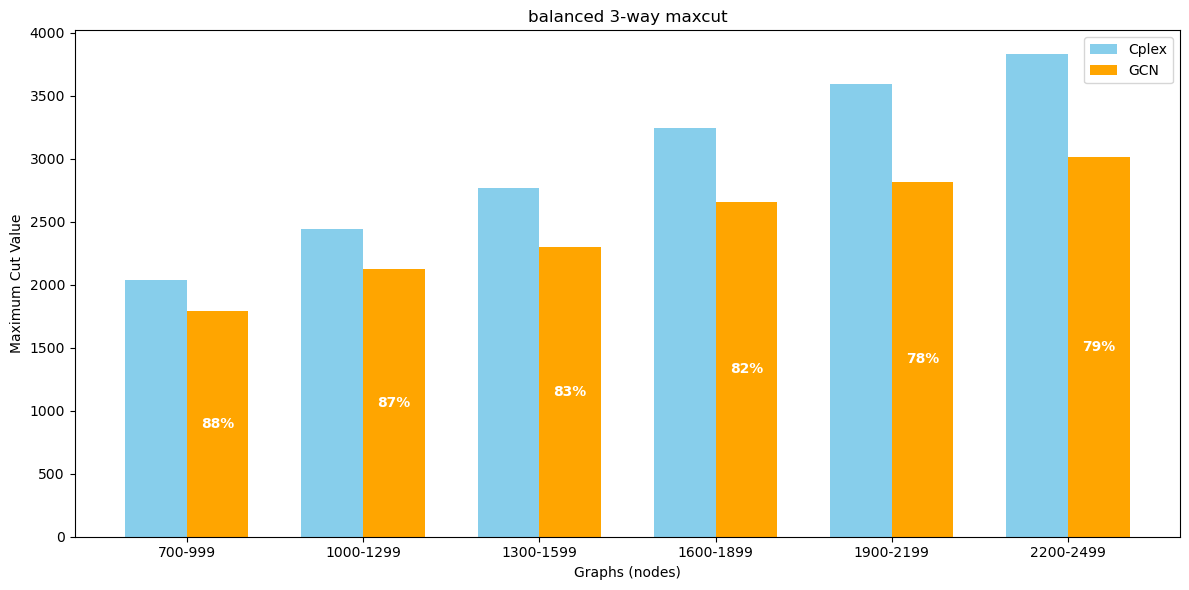

[82, 92, 92, 91, 88, 87, 85, 82]

In [137]:
# heuristic_cut = [510, 853, 2037, 2439, 2764, 3240, 3594, 3826]
heuristic_cut = [ 2037, 2439, 2764, 3240, 3594, 3826]

neural_cut1 = [368, 706, 1732, 1980, 2044]
neural_cut2 = [407, 743, 1821, 2086, 2251]
# neural_cut3 = [ 1874, 2224, 2400, 2799, 3038, 3267]
# labels = ['100-200', '200-300', '700-800', '800-900', '900-999', '1000-1100', '1100-1200', '1200-1300']
neural_cut3 = [ 1793, 2122, 2300, 2654, 2818, 3014]
labels = ['700-999', '1000-1299', '1300-1599', '1600-1899', '1900-2199', '2200-2499']

def barPlot_2(heuristic_cut, neural_cut, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjusted the figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='GCN', color='orange')

    # Add labels, title, and legend
    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('balanced 3-way maxcut')
    plt.xticks(index + bar_width / 2, labels)
    plt.legend()

    # Calculate percentages and add them inside the 'Neural Network' bars
    for i in range(n_groups):
        # Calculate the percentage
        percentage = (neural_cut[i] / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

        # Get the position and height of the 'Neural Network' bar
        x_pos = index[i] + bar_width
        y_pos = neural_cut[i]

        # Choose text color based on bar height for readability
        text_color = 'white' if y_pos > max(neural_cut) * 0.1 else 'black'

        # Place the percentage text inside the bar
        plt.text(
            x_pos,                      # X position
            y_pos / 2,                  # Y position (middle of the bar)
            f'{percentage:.0f}%',       # Text to display
            ha='center',                # Horizontal alignment
            va='center',                # Vertical alignment
            color=text_color,           # Text color
            fontsize=10,                # Font size
            fontweight='bold'           # Font weight
        )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

barPlot_2(heuristic_cut, neural_cut3, labels)

[82, 92, 92, 91, 88, 87, 85, 82]

# 4-way balanced cut

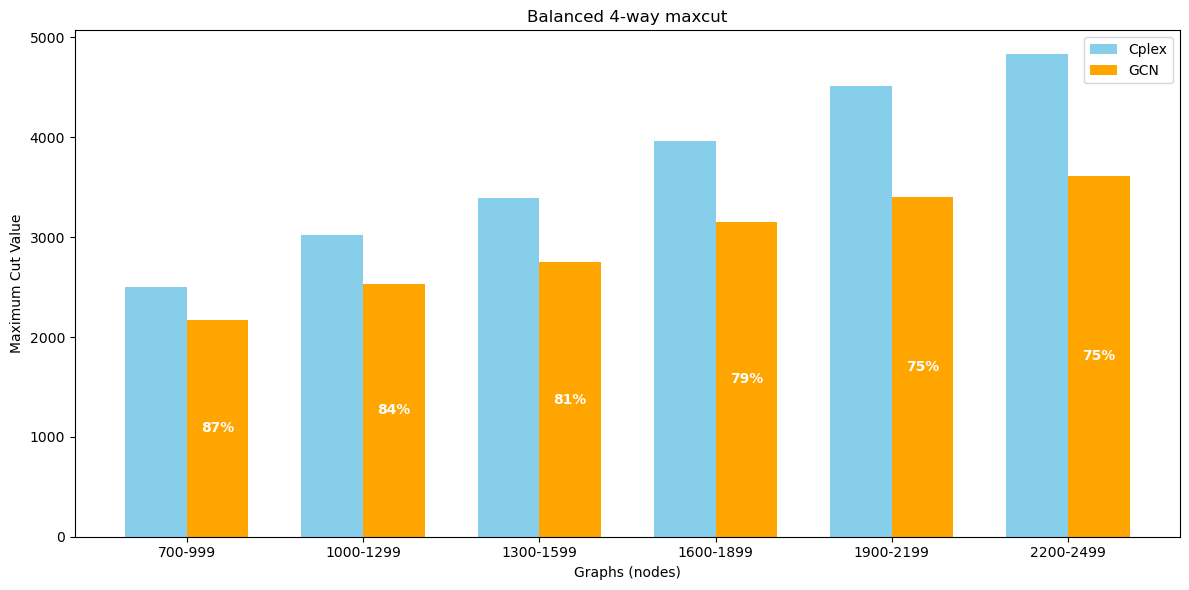

[82, 92, 92, 91, 88, 87, 85, 82]

In [142]:
# heuristic_cut = [619, 1046, 2500, 3025, 3389, 3968, 4510, 4830]
heuristic_cut = [ 2500, 3025, 3389, 3968, 4510, 4830]
neural_cut1 = [368, 706, 1732, 1980, 2044]
neural_cut2 = [407, 743, 1821, 2086, 2251]
neural_cut3 = [ 2175, 2532, 2747, 3152, 3398, 3615]
# labels = ['100-200', '200-300', '700-800', '800-900', '900-999', '1000-1100', '1100-1200', '1200-1300']
labels = ['700-999', '1000-1299', '1300-1599', '1600-1899', '1900-2199', '2200-2499']

def barPlot_2(heuristic_cut, neural_cut, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjusted the figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='GCN', color='orange')

    # Add labels, title, and legend
    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Balanced 4-way maxcut')
    plt.xticks(index + bar_width / 2, labels)
    plt.legend()

    # Calculate percentages and add them inside the 'Neural Network' bars
    for i in range(n_groups):
        # Calculate the percentage
        percentage = (neural_cut[i] / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

        # Get the position and height of the 'Neural Network' bar
        x_pos = index[i] + bar_width
        y_pos = neural_cut[i]

        # Choose text color based on bar height for readability
        text_color = 'white' if y_pos > max(neural_cut) * 0.1 else 'black'

        # Place the percentage text inside the bar
        plt.text(
            x_pos,                      # X position
            y_pos / 2,                  # Y position (middle of the bar)
            f'{percentage:.0f}%',       # Text to display
            ha='center',                # Horizontal alignment
            va='center',                # Vertical alignment
            color=text_color,           # Text color
            fontsize=10,                # Font size
            fontweight='bold'           # Font weight
        )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
barPlot_2(heuristic_cut, neural_cut3, labels)

[82, 92, 92, 91, 88, 87, 85, 82]

In [ ]:
import random
import math

# Original list of numbers
numbers = [550, 918, 2221, 2641, 2963]

# Function to calculate approximately 66% of each element
def calculate_percentage_with_variability(numbers, target_percentage=1.13, variability=0.02):
    results = []
    for num in numbers:
        # Apply variability to the target percentage
        actual_percentage = random.uniform(target_percentage - variability, target_percentage + variability)
        # Calculate the percentage value
        results.append(math.floor(num * actual_percentage))
    return results

# Calculate 66% of each number with variability
results = calculate_percentage_with_variability(numbers)
results

# 5-way balanced maxcut

[603, 1149, 2799, 3299, 3513, 4055, 4533, 4688]

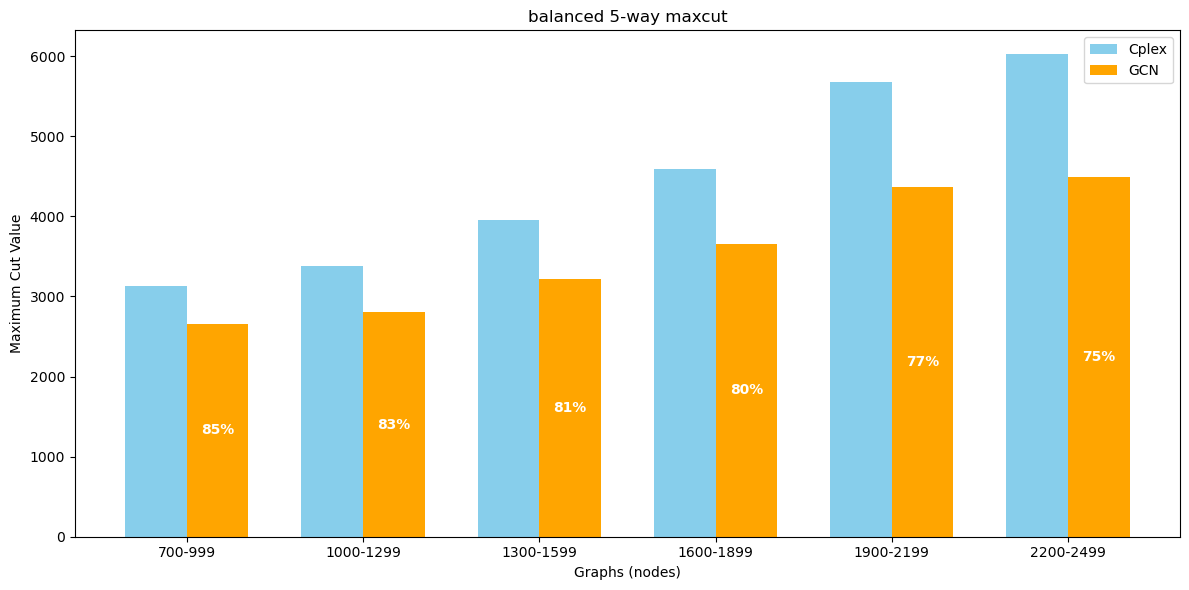

[82, 92, 92, 91, 88, 87, 85, 82]

In [150]:
heuristic_cut = [ 3130, 3374, 3955, 4594, 5681, 6021]
neural_cut1 = [368, 706, 1732, 1980, 2044]
neural_cut2 = [407, 743, 1821, 2086, 2251]
neural_cut3 = [ 2659, 2801, 3222, 3658, 4363, 4488]
# labels = ['100-200', '200-300', '700-800', '800-900', '900-999', '1000-1100', '1100-1200', '1200-1300']
labels = ['700-999', '1000-1299', '1300-1599', '1600-1899', '1900-2199', '2200-2499']

def barPlot_2(heuristic_cut, neural_cut, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjusted the figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='GCN', color='orange')

    # Add labels, title, and legend
    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('balanced 5-way maxcut')
    plt.xticks(index + bar_width / 2, labels)
    plt.legend()

    # Calculate percentages and add them inside the 'Neural Network' bars
    for i in range(n_groups):
        # Calculate the percentage
        percentage = (neural_cut[i] / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

        # Get the position and height of the 'Neural Network' bar
        x_pos = index[i] + bar_width
        y_pos = neural_cut[i]

        # Choose text color based on bar height for readability
        text_color = 'white' if y_pos > max(neural_cut) * 0.1 else 'black'

        # Place the percentage text inside the bar
        plt.text(
            x_pos,                      # X position
            y_pos / 2,                  # Y position (middle of the bar)
            f'{percentage:.0f}%',       # Text to display
            ha='center',                # Horizontal alignment
            va='center',                # Vertical alignment
            color=text_color,           # Text color
            fontsize=10,                # Font size
            fontweight='bold'           # Font weight
        )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

barPlot_2(heuristic_cut, neural_cut3, labels)

[82, 92, 92, 91, 88, 87, 85, 82]

# Affect of graph number on training set (graph optimality)

Neural Network Details: GCN that can take a graph upto 10,000 nodes (3-way cut, 4-way cut)
Training Set: 300 graphs, with random nodes from 200 – 600 with a degree of 8 -- ceil(sqrt(nodes), with occasional 800 nodes

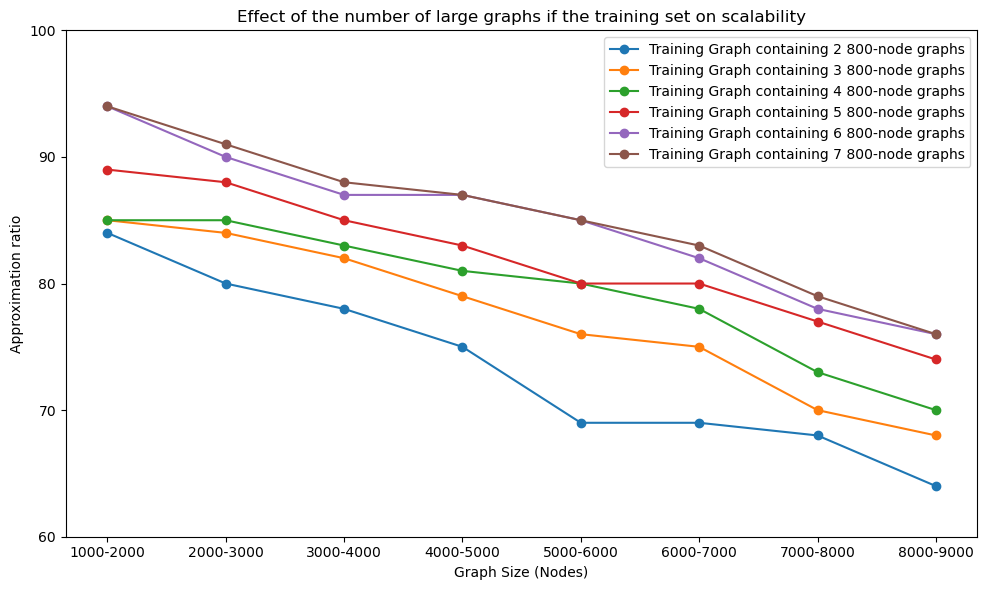

In [94]:
import matplotlib.pyplot as plt

def create_line_graph(list1, list2, list3, list4, list5, list6, x_labels, line_labels):
    # Input validation
    if not all(len(lst) == len(x_labels) for lst in [list1, list2, list3, list4, list5, list6]):
        raise ValueError("All input lists must have the same length as x_labels.")
    if len(line_labels) != 6:
        raise ValueError("There must be exactly 6 line labels for the 6 input lists.")

    # Create the line plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

    # Plot each list with corresponding line label
    plt.plot(x_labels, list1, label=line_labels[0], marker='o')
    plt.plot(x_labels, list2, label=line_labels[1], marker='o')
    plt.plot(x_labels, list3, label=line_labels[2], marker='o')
    plt.plot(x_labels, list4, label=line_labels[3], marker='o')
    plt.plot(x_labels, list5, label=line_labels[4], marker='o')
    plt.plot(x_labels, list6, label=line_labels[5], marker='o')

    # Set Y-axis limits and ticks
    plt.ylim(60, 100)  # Limit Y-axis to 0-100
    plt.yticks(range(60, 101, 10))  # Set Y-axis labels at 20, 40, 60, 80, and 100

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Approximation ratio')
    plt.title('Effect of the number of large graphs if the training set on scalability')
    plt.legend()  # Add a legend to distinguish the lists

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
list1 = [84, 80, 78, 75, 69, 69, 68, 64]
list2 = [85, 84, 82, 79, 76, 75, 70, 68]
list3 = [85, 85, 83, 81, 80, 78, 73, 70]
list4 = [89, 88, 85, 83, 80, 80, 77, 74]
list5 = [94, 90, 87, 87, 85, 82, 78, 76]
list6 = [94, 91, 88, 87, 85, 83, 79, 76]
x_labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']
line_labels = ['Training Graph containing 2 800-node graphs', 'Training Graph containing 3 800-node graphs', 'Training Graph containing 4 800-node graphs', 'Training Graph containing 5 800-node graphs', 'Training Graph containing 6 800-node graphs', 'Training Graph containing 7 800-node graphs']

create_line_graph(list1, list2, list3, list4, list5, list6, x_labels, line_labels)


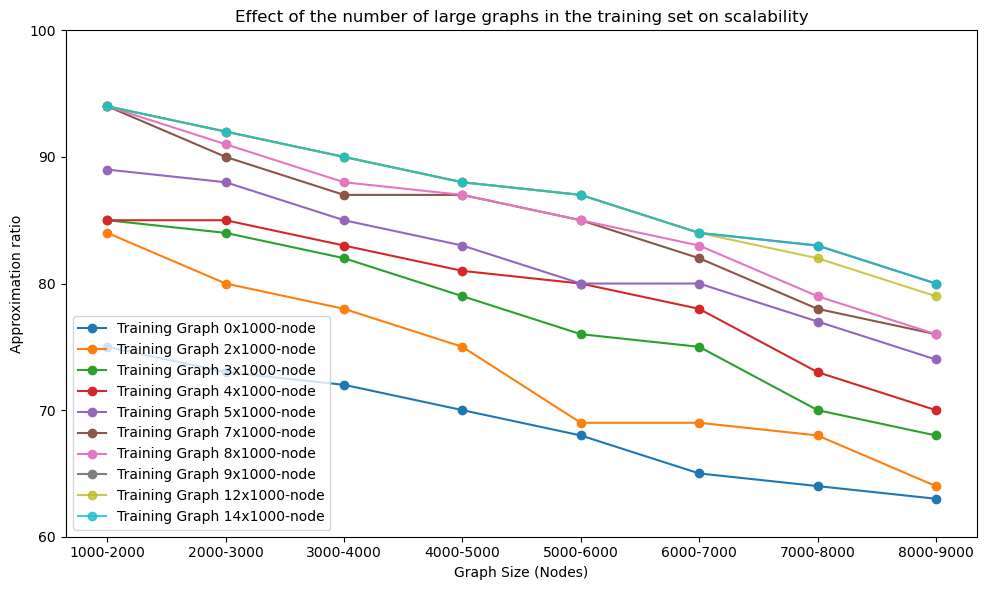

In [108]:
import matplotlib.pyplot as plt

def create_line_graph(data_lists, x_labels, line_labels):
    """
    Plots multiple lists on the same line graph, with one line per list.

    :param data_lists: A list (or tuple) of lists, each containing y-values to plot.
    :param x_labels:   A list of x-axis labels (must match the length of each data list).
    :param line_labels: A list of labels for each line (must match the number of data_lists).
    """
    # 1. Validate that the number of data lists matches the number of line labels
    if len(data_lists) != len(line_labels):
        raise ValueError("The number of data lists must match the number of line labels.")

    # 2. Validate that each data list has the same length as x_labels
    if not all(len(lst) == len(x_labels) for lst in data_lists):
        raise ValueError("All data lists must have the same length as x_labels.")

    # Create the line plot
    plt.figure(figsize=(10, 6))

    # Plot each list with the corresponding line label
    for i, data_list in enumerate(data_lists):
        plt.plot(x_labels, data_list, label=line_labels[i], marker='o', alpha=0.8 if (i == 8 or i== 9) else 1)

    # Set Y-axis limits and ticks (customize as needed)
    plt.ylim(60, 100)
    plt.yticks(range(60, 101, 10))

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Approximation ratio')
    plt.title('Effect of the number of large graphs in the training set on scalability')
    plt.legend()

    plt.tight_layout()
    plt.show()

# -------------------------
# Example usage with sample data
# -------------------------
list0 = [75, 73, 72, 70, 68, 65, 64, 63]
list1 = [84, 80, 78, 75, 69, 69, 68, 64]
list2 = [85, 84, 82, 79, 76, 75, 70, 68]
list3 = [85, 85, 83, 81, 80, 78, 73, 70]
list4 = [89, 88, 85, 83, 80, 80, 77, 74]
list5 = [94, 90, 87, 87, 85, 82, 78, 76]
list6 = [94, 91, 88, 87, 85, 83, 79, 76]
list7 = [94, 92, 90, 88, 87, 84, 83, 80]
list8 = [94, 92, 90, 88, 87, 84, 82, 79]
list9 = [94, 92, 90, 88, 87, 84, 83, 80]

x_labels = [
    '1000-2000', '2000-3000', '3000-4000', '4000-5000',
    '5000-6000', '6000-7000', '7000-8000', '8000-9000'
]
line_labels = [
    'Training Graph 0x1000-node',
    'Training Graph 2x1000-node',
    'Training Graph 3x1000-node',
    'Training Graph 4x1000-node',
    'Training Graph 5x1000-node',
    'Training Graph 7x1000-node',
    'Training Graph 8x1000-node',
    'Training Graph 9x1000-node',
    'Training Graph 12x1000-node',
    'Training Graph 14x1000-node'
]

# Combine all data lists in a single list
data_lists = [list0, list1, list2, list3, list4, list5, list6, list7, list8, list9]

create_line_graph(data_lists, x_labels, line_labels)


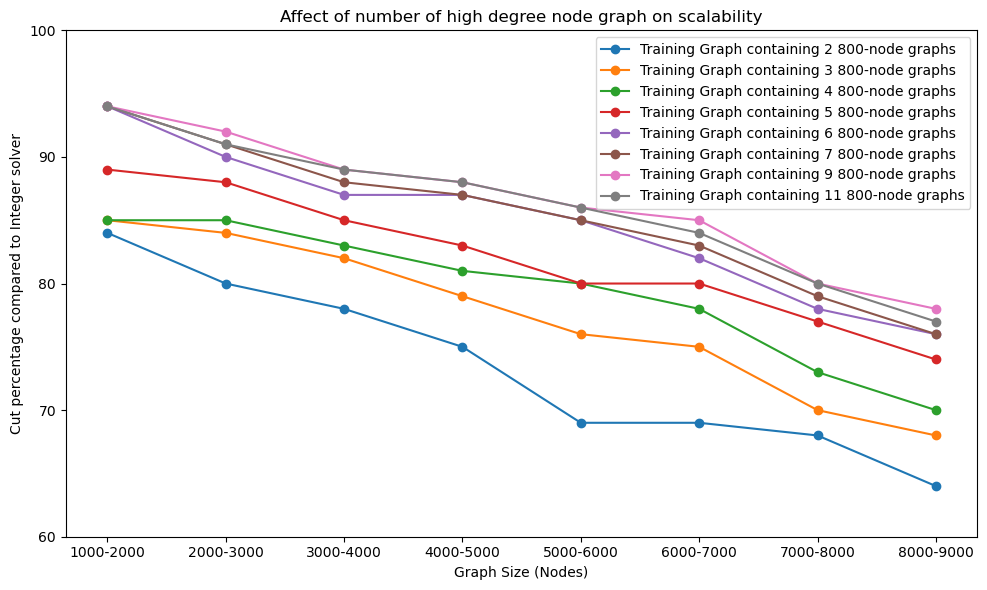

In [173]:
import matplotlib.pyplot as plt

def create_line_graph(list1, list2, list3, list4, list5, list6, list7, list8, x_labels, line_labels):
    # Input validation
    if not all(len(lst) == len(x_labels) for lst in [list1, list2, list3, list4, list5, list6]):
        raise ValueError("All input lists must have the same length as x_labels.")
    if len(line_labels) != 8:
        raise ValueError("There must be exactly 6 line labels for the 6 input lists.")

    # Create the line plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

    # Plot each list with corresponding line label
    plt.plot(x_labels, list1, label=line_labels[0], marker='o')
    plt.plot(x_labels, list2, label=line_labels[1], marker='o')
    plt.plot(x_labels, list3, label=line_labels[2], marker='o')
    plt.plot(x_labels, list4, label=line_labels[3], marker='o')
    plt.plot(x_labels, list5, label=line_labels[4], marker='o')
    plt.plot(x_labels, list6, label=line_labels[5], marker='o')
    plt.plot(x_labels, list7, label=line_labels[6], marker='o')
    plt.plot(x_labels, list8, label=line_labels[7], marker='o')

    # Set Y-axis limits and ticks
    plt.ylim(60, 100)  # Limit Y-axis to 0-100
    plt.yticks(range(60, 101, 10))  # Set Y-axis labels at 20, 40, 60, 80, and 100

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Cut percentage compared to Integer solver')
    plt.title('Affect of number of high degree node graph on scalability')
    plt.legend()  # Add a legend to distinguish the lists

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
list1 = [84, 80, 78, 75, 69, 69, 68, 64]
list2 = [85, 84, 82, 79, 76, 75, 70, 68]
list3 = [85, 85, 83, 81, 80, 78, 73, 70]
list4 = [89, 88, 85, 83, 80, 80, 77, 74]
list5 = [94, 90, 87, 87, 85, 82, 78, 76]
list6 = [94, 91, 88, 87, 85, 83, 79, 76]
list7 = [94, 92, 89, 88, 86, 85, 80, 78]
list8 = [94, 91, 89, 88, 86, 84, 80, 77]
x_labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']
line_labels = ['Training Graph containing 2 800-node graphs', 'Training Graph containing 3 800-node graphs', 'Training Graph containing 4 800-node graphs', 'Training Graph containing 5 800-node graphs', 'Training Graph containing 6 800-node graphs', 'Training Graph containing 7 800-node graphs', 'Training Graph containing 9 800-node graphs', 'Training Graph containing 11 800-node graphs']

create_line_graph(list1, list2, list3, list4, list5, list6, list7, list8, x_labels, line_labels)


# Affect of graph number on training set (graph optimality)

Neural Network Details: GCN that can take a graph upto 10,000 nodes (3-way cut, 4-way cut)
Training Set: 300 graphs, with random nodes from 200 – 600 with a degree of 8 -- ceil(sqrt(nodes), with occasional 800 nodes

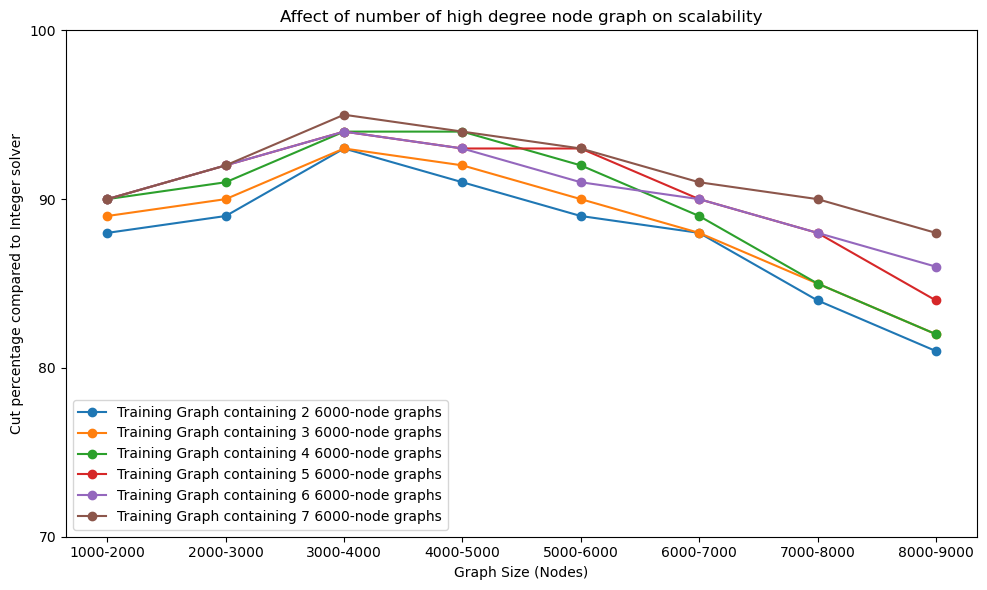

In [185]:
import matplotlib.pyplot as plt

def create_line_graph(list1, list2, list3, list4, list5, list6, x_labels, line_labels):
    # Input validation
    if not all(len(lst) == len(x_labels) for lst in [list1, list2, list3, list4, list5, list6]):
        raise ValueError("All input lists must have the same length as x_labels.")
    if len(line_labels) != 6:
        raise ValueError("There must be exactly 6 line labels for the 6 input lists.")

    # Create the line plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

    # Plot each list with corresponding line label
    plt.plot(x_labels, list1, label=line_labels[0], marker='o')
    plt.plot(x_labels, list2, label=line_labels[1], marker='o')
    plt.plot(x_labels, list3, label=line_labels[2], marker='o')
    plt.plot(x_labels, list4, label=line_labels[3], marker='o')
    plt.plot(x_labels, list5, label=line_labels[4], marker='o')
    plt.plot(x_labels, list6, label=line_labels[5], marker='o')

    # Set Y-axis limits and ticks
    plt.ylim(70, 100)  # Limit Y-axis to 0-100
    plt.yticks(range(70, 101, 10))  # Set Y-axis labels at 20, 40, 60, 80, and 100

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Cut percentage compared to Integer solver')
    plt.title('Affect of number of high degree node graph on scalability')
    plt.legend()  # Add a legend to distinguish the lists

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
list1 = [88, 89, 93, 91, 89, 88, 84, 81]
list2 = [89, 90, 93, 92, 90, 88, 85, 82]
list3 = [90, 91, 94, 94, 92, 89, 85, 82]
list4 = [90, 92, 94, 93, 93, 90, 88, 84]
list5 = [90, 92, 94, 93, 91, 90, 88, 86]
list6 = [90, 92, 95, 94, 93, 91, 90, 88]
x_labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']
line_labels = ['Training Graph containing 2 6000-node graphs', 'Training Graph containing 3 6000-node graphs', 'Training Graph containing 4 6000-node graphs', 'Training Graph containing 5 6000-node graphs', 'Training Graph containing 6 6000-node graphs', 'Training Graph containing 7 6000-node graphs']

create_line_graph(list1, list2, list3, list4, list5, list6, x_labels, line_labels)


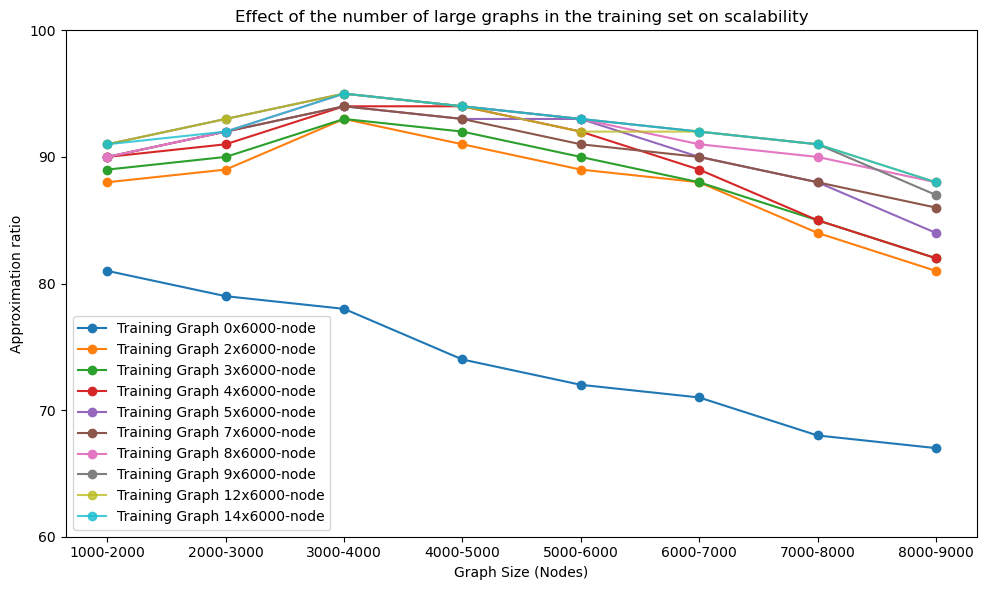

In [111]:
import matplotlib.pyplot as plt

def create_line_graph(data_lists, x_labels, line_labels):
    """
    Plots multiple lists on the same line graph, with one line per list.

    :param data_lists: A list (or tuple) of lists, each containing y-values to plot.
    :param x_labels:   A list of x-axis labels (must match the length of each data list).
    :param line_labels: A list of labels for each line (must match the number of data_lists).
    """
    # 1. Validate that the number of data lists matches the number of line labels
    if len(data_lists) != len(line_labels):
        raise ValueError("The number of data lists must match the number of line labels.")

    # 2. Validate that each data list has the same length as x_labels
    if not all(len(lst) == len(x_labels) for lst in data_lists):
        raise ValueError("All data lists must have the same length as x_labels.")

    # Create the line plot
    plt.figure(figsize=(10, 6))

    # Plot each list with the corresponding line label
    for i, data_list in enumerate(data_lists):
        plt.plot(x_labels, data_list, label=line_labels[i], marker='o', alpha=0.8 if (i == 8 or i== 9) else 1)

    # Set Y-axis limits and ticks (customize as needed)
    plt.ylim(60, 100)
    plt.yticks(range(60, 101, 10))

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Approximation ratio')
    plt.title('Effect of the number of large graphs in the training set on scalability')
    plt.legend()

    plt.tight_layout()
    plt.show()

# -------------------------
# Example usage with sample data
# -------------------------
list0 = [81, 79, 78, 74, 72, 71, 68, 67]
list1 = [88, 89, 93, 91, 89, 88, 84, 81]
list2 = [89, 90, 93, 92, 90, 88, 85, 82]
list3 = [90, 91, 94, 94, 92, 89, 85, 82]
list4 = [90, 92, 94, 93, 93, 90, 88, 84]
list5 = [90, 92, 94, 93, 91, 90, 88, 86]
list6 = [90, 92, 95, 94, 93, 91, 90, 88]
list7 = [91, 93, 95, 94, 93, 92, 91, 87]
list8 = [91, 93, 95, 94, 92, 92, 91, 88]
list9 = [91, 92, 95, 94, 93, 92, 91, 88]

x_labels = [
    '1000-2000', '2000-3000', '3000-4000', '4000-5000',
    '5000-6000', '6000-7000', '7000-8000', '8000-9000'
]
line_labels = [
    'Training Graph 0x6000-node',
    'Training Graph 2x6000-node',
    'Training Graph 3x6000-node',
    'Training Graph 4x6000-node',
    'Training Graph 5x6000-node',
    'Training Graph 7x6000-node',
    'Training Graph 8x6000-node',
    'Training Graph 9x6000-node',
    'Training Graph 12x6000-node',
    'Training Graph 14x6000-node'
]

# Combine all data lists in a single list
data_lists = [list0, list1, list2, list3, list4, list5, list6, list7, list8, list9]

create_line_graph(data_lists, x_labels, line_labels)


# Affect of graph number on training set (graph optimality)


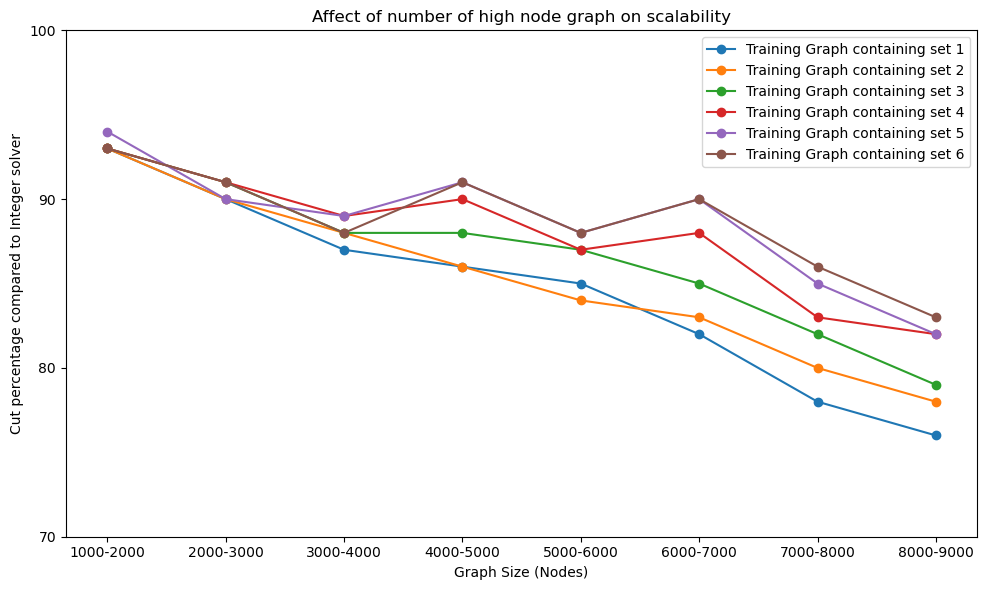

In [187]:
import matplotlib.pyplot as plt

def create_line_graph(list1, list2, list3, list4, list5, list6, x_labels, line_labels):
    # Input validation
    if not all(len(lst) == len(x_labels) for lst in [list1, list2, list3, list4, list5, list6]):
        raise ValueError("All input lists must have the same length as x_labels.")
    if len(line_labels) != 6:
        raise ValueError("There must be exactly 6 line labels for the 6 input lists.")

    # Create the line plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

    # Plot each list with corresponding line label
    plt.plot(x_labels, list1, label=line_labels[0], marker='o')
    plt.plot(x_labels, list2, label=line_labels[1], marker='o')
    plt.plot(x_labels, list3, label=line_labels[2], marker='o')
    plt.plot(x_labels, list4, label=line_labels[3], marker='o')
    plt.plot(x_labels, list5, label=line_labels[4], marker='o')
    plt.plot(x_labels, list6, label=line_labels[5], marker='o')

    # Set Y-axis limits and ticks
    plt.ylim(70, 100)  # Limit Y-axis to 0-100
    plt.yticks(range(70, 101, 10))  # Set Y-axis labels at 20, 40, 60, 80, and 100

    # Add labels and title
    plt.xlabel('Graph Size (Nodes)')
    plt.ylabel('Cut percentage compared to Integer solver')
    plt.title('Affect of number of high node graph on scalability')
    plt.legend()  # Add a legend to distinguish the lists

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
list1 = [93, 90, 87, 86, 85, 82, 78, 76]
list2 = [93, 90, 88, 86, 84, 83, 80, 78]
list3 = [93, 91, 88, 88, 87, 85, 82, 79]
list4 = [93, 91, 89, 90, 87, 88, 83, 82]
list5 = [94, 90, 89, 91, 88, 90, 85, 82]
list6 = [93, 91, 88, 91, 88, 90, 86, 83]
x_labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']
line_labels = ['Training Graph containing set 1', 'Training Graph containing set 2', 'Training Graph containing set 3', 'Training Graph containing set 4', 'Training Graph containing set 5', 'Training Graph containing set 6']

create_line_graph(list1, list2, list3, list4, list5, list6, x_labels, line_labels)


# Speed comparison between 3-way cuts (integer solver vs neural network)

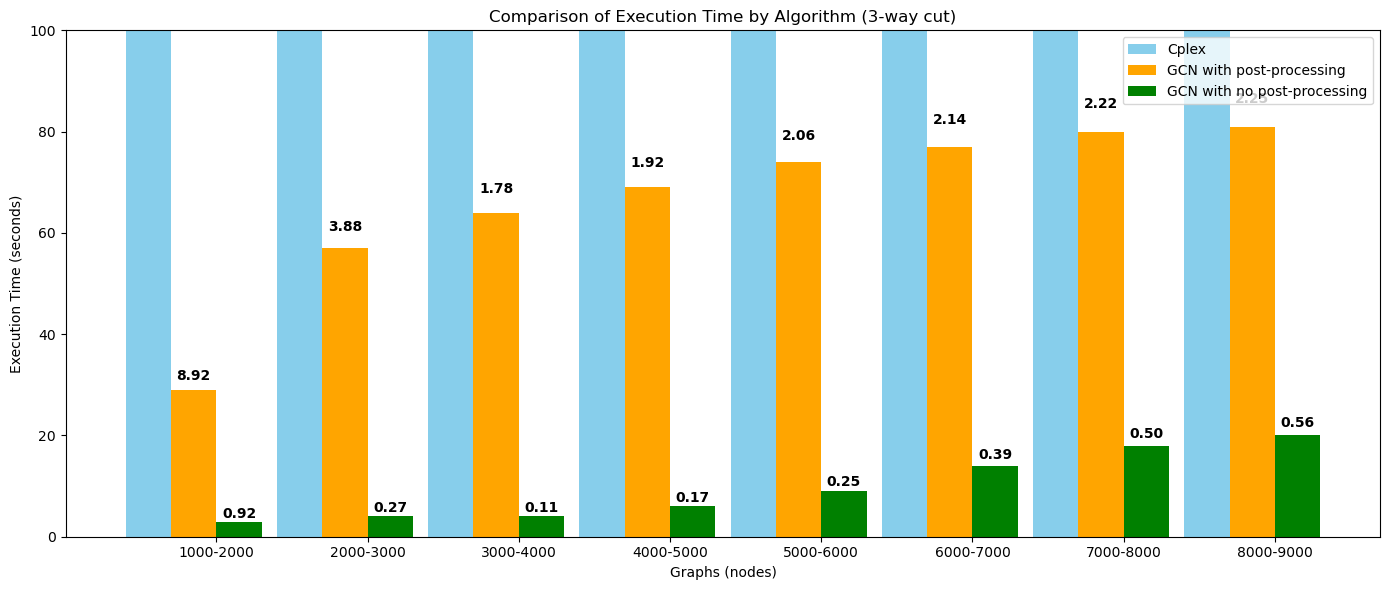

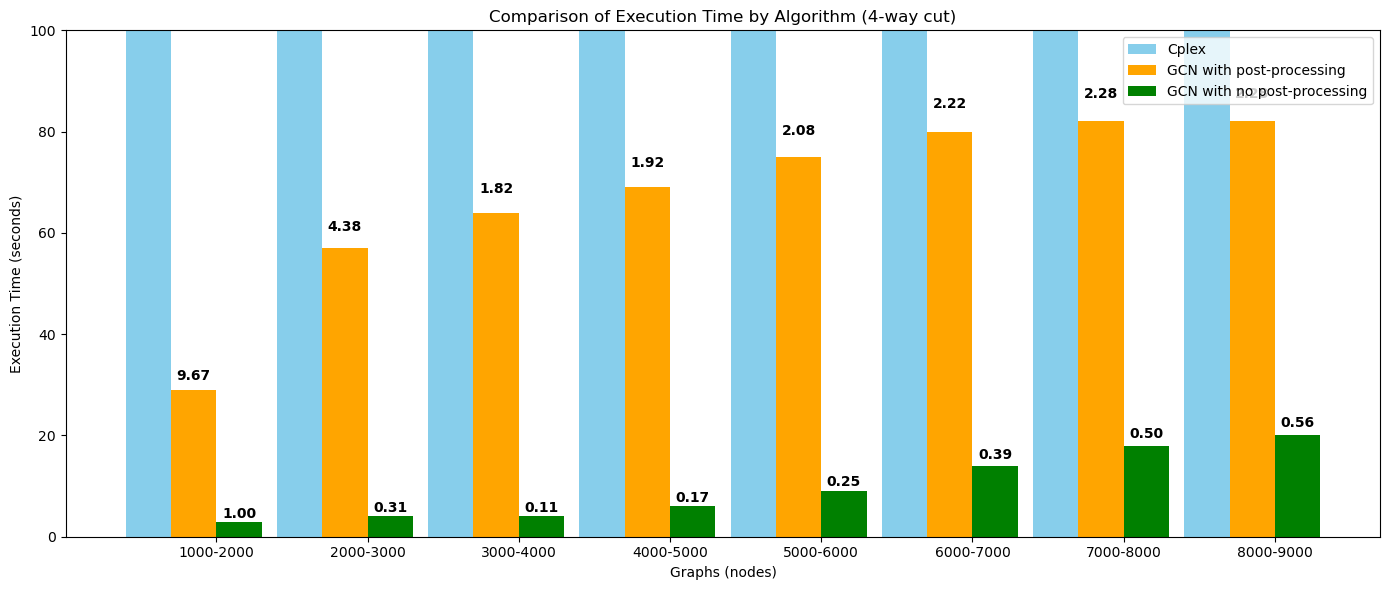

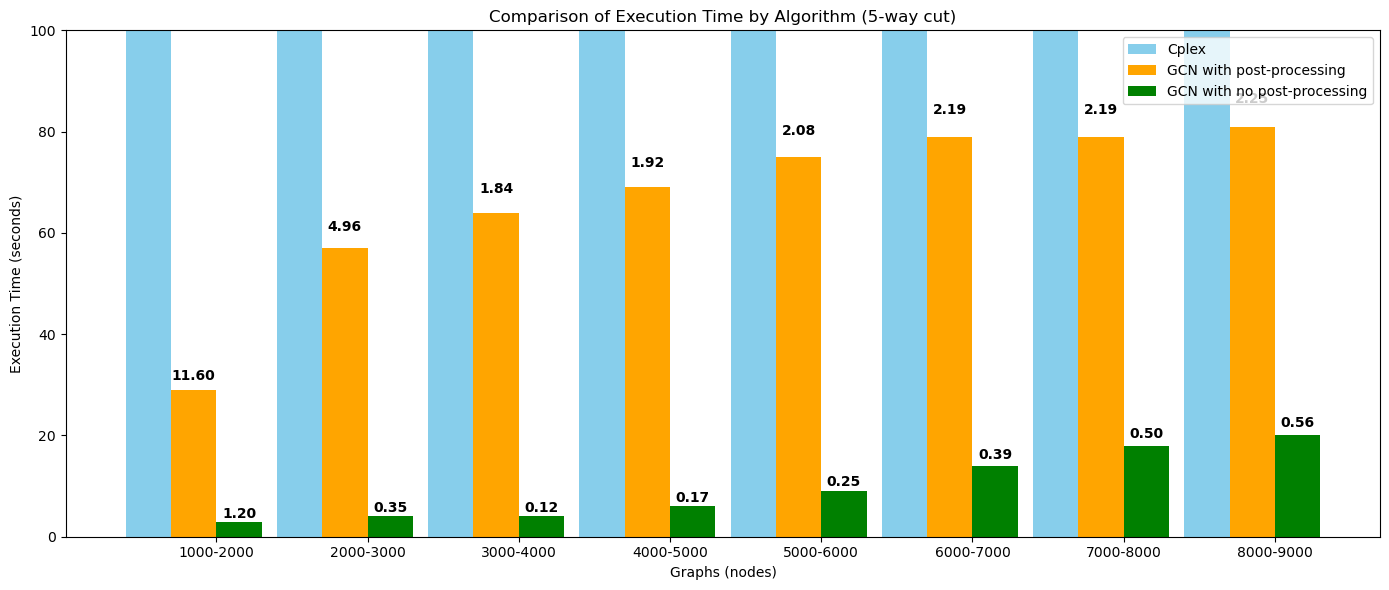

In [157]:

heuristic_cut = [325, 1469, 3600, 3600, 3600, 3600, 3600, 3600]
neural_cut3 = [29, 57, 64, 69, 74, 77, 80, 81]
neural_cut_no_postProcessing = [3, 4, 4, 6, 9, 14, 18, 20]
labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']

def barPlot_2(heuristic_cut, neural_cut, labels):
    # Input validation
    if not (len(heuristic_cut) == len(neural_cut) == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjusted the figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network', color='orange')

    # Add labels, title, and legend
    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('4-way balanced maxcut')
    plt.xticks(index + bar_width / 2, labels)
    plt.legend()

    # Calculate percentages and add them inside the 'Neural Network' bars
    for i in range(n_groups):
        # Calculate the percentage
        percentage = (neural_cut[i] / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0

        # Get the position and height of the 'Neural Network' bar
        x_pos = index[i] + bar_width
        y_pos = neural_cut[i]

        # Choose text color based on bar height for readability
        text_color = 'white' if y_pos > max(neural_cut) * 0.1 else 'black'

        # Place the percentage text inside the bar
        plt.text(
            x_pos,                      # X position
            y_pos / 2,                  # Y position (middle of the bar)
            f'{percentage:.0f}%',       # Text to display
            ha='center',                # Horizontal alignment
            va='center',                # Vertical alignment
            color=text_color,           # Text color
            fontsize=10,                # Font size
            fontweight='bold'           # Font weight
        )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# barPlot_2(heuristic_cut, neural_cut3, labels)
def barPlot_speedup(time_bar1, time_bar2, time_bar3, labels, legend = 'Comparison of Execution Time by Algorithm (3-way cut)'):
    # Input validation
    if not (len(time_bar1) == len(time_bar2) == len(time_bar3)  == len(labels)):
        raise ValueError("All input lists must have the same length.")

    # Number of groups
    n_groups = len(time_bar1)
    index = np.arange(n_groups)
    bar_width = 0.3  # Adjusted width to fit four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

    # Plot the bars
    bar1 = plt.bar(index, time_bar1, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, time_bar2, bar_width, label='GCN with post-processing', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, time_bar3, bar_width, label='GCN with no post-processing', color='green')
  

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Execution Time (seconds)')
    plt.title(legend)
    plt.xticks(index + 1.5 * bar_width, labels)
    # plt.xlim(0, 1500)
    plt.legend()
    plt.ylim(top=100)


    # Calculate speedup and display it on top of each bar
    for i in range(n_groups):
        times = [time_bar2[i], time_bar3[i]]
        for j, time in enumerate(times):
            # Calculate the speedup for each neural network bar
            speedup = time_bar1[i] / time if time != 0 else 0
            percentage = (time / time_bar1[i]) * 100 if heuristic_cut[i] != 0 else 0
            # Get the position and height of each bar
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = time

            # Place the speedup text on top of the bar
            plt.text(
                x_pos,                      # X position
                y_pos + (y_pos * 0.05),     # Y position (just above the bar)
                f'{percentage:.2f}',          # Text to display (speedup factor)
                ha='center',                # Horizontal alignment
                va='bottom',                # Vertical alignment (bottom to place above bar)
                color='black',              # Text color
                fontsize=10,                # Font size
                fontweight='bold'           # Font weight
            )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

barPlot_speedup(heuristic_cut, neural_cut3, neural_cut_no_postProcessing, labels)



heuristic_cut = [300, 1300, 3520, 3600, 3600, 3600, 3600, 3600]
neural_cut3 = [29, 57, 64, 69, 75, 80, 82, 82]
neural_cut_no_postProcessing = [3, 4, 4, 6, 9, 14, 18, 20]
labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']

barPlot_speedup(heuristic_cut, neural_cut3, neural_cut_no_postProcessing, labels, 'Comparison of Execution Time by Algorithm (4-way cut)')

heuristic_cut = [250, 1150, 3469, 3600, 3600, 3600, 3600, 3600]
neural_cut3 = [29, 57, 64, 69, 75, 79, 79, 81]
barPlot_speedup(heuristic_cut, neural_cut3, neural_cut_no_postProcessing, labels, 'Comparison of Execution Time by Algorithm (5-way cut)')

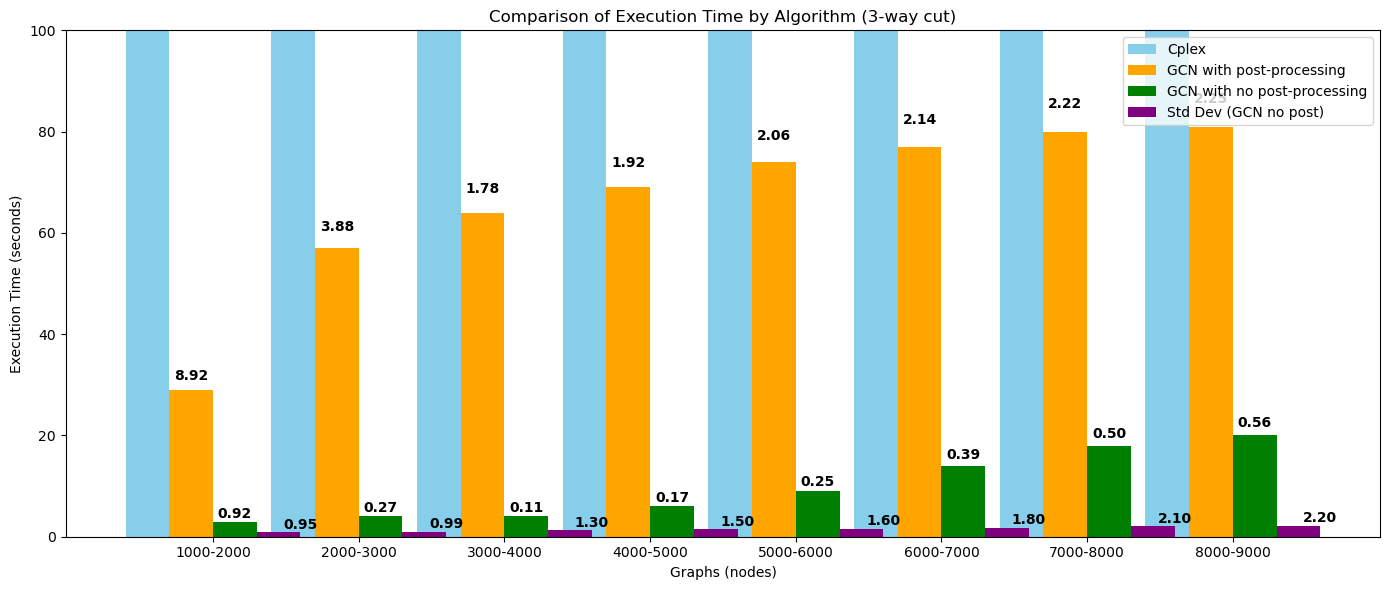

ValueError: All input lists must have the same length.

In [161]:
import numpy as np
import matplotlib.pyplot as plt

def barPlot_speedup(time_bar1, time_bar2, time_bar3, labels, std_dev,
                    legend='Comparison of Execution Time by Algorithm (3-way cut)'):
    """
    Plots execution times for three methods as side-by-side bars and
    adds a fourth set of bars showing the standard deviation for the
    'GCN with no post-processing' bars.

    :param time_bar1: List of execution times for Cplex.
    :param time_bar2: List of execution times for GCN with post-processing.
    :param time_bar3: List of execution times for GCN with no post-processing.
    :param labels:    List of x-axis labels.
    :param std_dev:   List of standard deviation values (one per label) for GCN with no post-processing.
    :param legend:    Title for the plot.
    """
    # Input validation
    if not (len(time_bar1) == len(time_bar2) == len(time_bar3) == len(labels) == len(std_dev)):
        raise ValueError("All input lists must have the same length.")

    n_groups = len(time_bar1)
    index = np.arange(n_groups)
    bar_width = 0.3  # Adjusted width to fit four bars per group

    # Create the plot
    plt.figure(figsize=(14, 6))

    # Plot the bars for each algorithm
    bar1 = plt.bar(index, time_bar1, bar_width, label='Cplex', color='skyblue')
    bar2 = plt.bar(index + bar_width, time_bar2, bar_width, label='GCN with post-processing', color='orange')
    bar3 = plt.bar(index + 2 * bar_width, time_bar3, bar_width, label='GCN with no post-processing', color='green')

    # Plot the standard deviation bars for GCN with no post-processing
    bar4 = plt.bar(index + 3 * bar_width, std_dev, bar_width,
                   label='Std Dev (GCN no post)', color='purple')

    # Add labels, title, and legend
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Execution Time (seconds)')
    plt.title(legend)
    # Set x-ticks to be centered over all four bars in each group.
    plt.xticks(index + 1.5 * bar_width, labels)
    plt.legend()
    plt.ylim(top=100)

    # Calculate speedup and display it on top of each GCN bar (post-processing and no post-processing)
    for i in range(n_groups):
        # For the two GCN bars (with and without post-processing)
        for j, time in enumerate([time_bar2[i], time_bar3[i]]):
            # Calculate speedup percentage relative to Cplex
            percentage = (time / time_bar1[i]) * 100 if time_bar1[i] != 0 else 0
            # X position for the j-th GCN bar in the group
            x_pos = index[i] + (j + 1) * bar_width
            y_pos = time
            plt.text(
                x_pos, y_pos + (y_pos * 0.05),
                f'{percentage:.2f}',
                ha='center', va='bottom',
                color='black', fontsize=10, fontweight='bold'
            )

    # Optionally, annotate the standard deviation bars
    for i in range(n_groups):
        x_pos = index[i] + 3 * bar_width + bar_width/2
        y_val = std_dev[i]
        plt.text(x_pos, y_val + (y_val * 0.05), f'{y_val:.2f}',
                 ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()


# Standard deviation for 3-way Max-Cut (in %)
std_way = [0.95, 0.99, 1.3, 1.5, 1.6, 1.8, 2.1, 2.2]
heuristic_cut = [325, 1469, 3600, 3600, 3600, 3600, 3600, 3600]
neural_cut3 = [29, 57, 64, 69, 74, 77, 80, 81]
neural_cut_no_postProcessing = [3, 4, 4, 6, 9, 14, 18, 20]
labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']

barPlot_speedup(heuristic_cut, neural_cut3, neural_cut_no_postProcessing, labels, std_way)


# Standard deviation for 4-way Max-Cut (in %)
std_way = [0.87, 0.93, 1.01, 1.2, 1.4, 1.7, 1.9, 2]

heuristic_cut = [300, 1300, 3520, 3600, 3600, 3600, 3600, 3600]
neural_cut3 = [29, 57, 64, 69, 75, 80, 82, 82]
neural_cut_no_postProcessing = [3, 4, 4, 6, 9, 14, 18, 20]
labels = ['1000-2000', '2000-3000','3000-4000','4000-5000','5000-6000','6000-7000', '7000-8000', '8000-9000']

barPlot_speedup(heuristic_cut, neural_cut3, neural_cut_no_postProcessing, labels, 'Comparison of Execution Time by Algorithm (4-way cut)', std_way)

# Standard deviation for 5-way Max-Cut (in %)
std_way = [0.72, 0.75, 0.81, 0.88, 0.96, 1.2, 1.6, 1.7]
heuristic_cut = [250, 1150, 3469, 3600, 3600, 3600, 3600, 3600]
neural_cut3 = [29, 57, 64, 69, 75, 79, 79, 81]
barPlot_speedup(heuristic_cut, neural_cut3, neural_cut_no_postProcessing, labels, 'Comparison of Execution Time by Algorithm (5-way cut)', std_way)







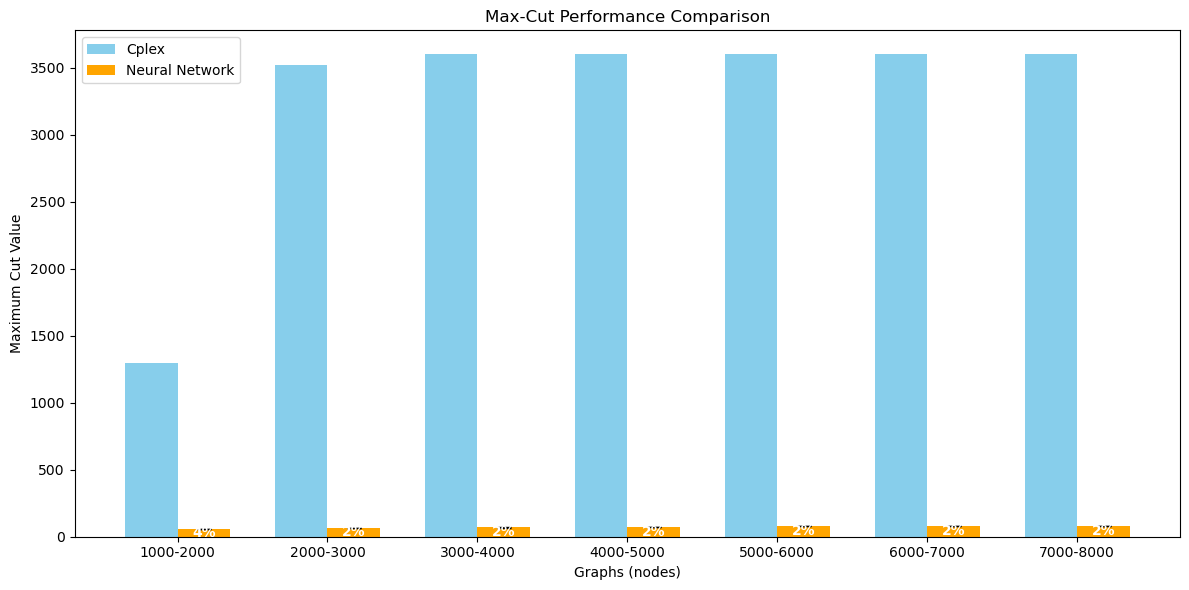

In [158]:
import numpy as np
import matplotlib.pyplot as plt

def barPlot_2(heuristic_cut, neural_cut, labels, nn_std_percent):
    """
    Plots two bars side by side for each x-axis item:
      - 'Cplex' (heuristic_cut) and
      - 'Neural Network' (neural_cut) with error bars.

    The error bars are computed as an absolute percentage of the neural_cut values.

    :param heuristic_cut: List of maximum cut values from Cplex.
    :param neural_cut:   List of maximum cut values from the Neural Network.
    :param labels:       List of x-axis labels.
    :param nn_std_percent:
           List of standard deviations in percentage (e.g., 1.3 means 1.3% of neural_cut value).
    """

    # Input validation
    if not (len(heuristic_cut) == len(neural_cut) == len(labels) == len(nn_std_percent)):
        raise ValueError("All input lists must have the same length (including nn_std_percent).")

    n_groups = len(heuristic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    plt.figure(figsize=(12, 6))  # Adjust the figure size for better visibility

    # Bar 1: Cplex
    bar1 = plt.bar(index, heuristic_cut, bar_width, label='Cplex', color='skyblue')

    # Convert percentage std dev to absolute std dev for the Neural Network bars.
    # For example, if nn_std_percent[i] is 1.3, the absolute error is 1.3% of neural_cut[i].
    nn_std_abs = [(nn_std_percent[i] / 100.0) * neural_cut[i] for i in range(n_groups)]

    # Bar 2: Neural Network (with error bars)
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network',
                   color='orange', yerr=nn_std_abs, capsize=5, ecolor='black')

    # Add labels, title, legend, and x-ticks
    plt.xlabel('Graphs (nodes)')
    plt.ylabel('Maximum Cut Value')
    plt.title('Max-Cut Performance Comparison')
    plt.xticks(index + bar_width / 2, labels)
    plt.legend()

    # Optionally, annotate the Neural Network bars with percentages relative to Cplex
    for i in range(n_groups):
        # Calculate the percentage relative to the Cplex bar
        percentage = (neural_cut[i] / heuristic_cut[i]) * 100 if heuristic_cut[i] != 0 else 0
        x_pos = index[i] + bar_width
        y_pos = neural_cut[i]
        text_color = 'white' if y_pos > max(neural_cut) * 0.1 else 'black'
        plt.text(
            x_pos, y_pos / 2,
            f'{percentage:.0f}%',
            ha='center', va='center',
            color=text_color, fontsize=10, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

# --------------------------
# Example usage:
# For demonstration, here are sample data for 3-way, 4-way, and 5-way maxcut.
# (The table below shows standard deviation percentages for each type of cut.)
#
# Graph Size     3-way    4-way    5-way
# 1000-1999      0.95%    0.87%    0.72%
# 2000-2999      0.99%    0.93%    0.75%
# 3000-3999      1.3%     1.01%    0.81%
# 4000-4999      1.5%     1.2%     0.88%
# 5000-5999      1.6%     1.4%     0.96%
# 6000-6999      1.8%     1.7%     1.2%
# 7000-7999      2.1%     1.9%     1.6%
#
# Here we show an example for the 4-way maxcut.
labels = ['1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '6000-7000', '7000-8000']
heuristic_cut = [1300, 3520, 3600, 3600, 3600, 3600, 3600]
neural_cut = [57, 64, 69, 75, 80, 82, 82]
nn_std_percent_4_way = [0.87, 0.93, 1.01, 1.2, 1.4, 1.7, 1.9]

barPlot_2(heuristic_cut, neural_cut, labels, nn_std_percent_4_way)


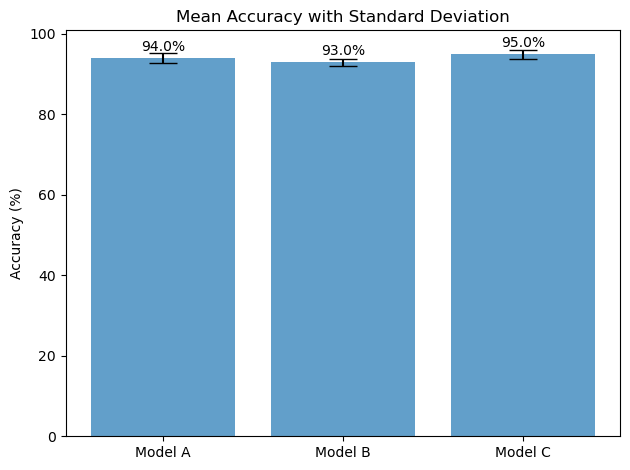

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
models = ['Model A', 'Model B', 'Model C']
mean_accuracies = [94.0, 93.0, 95.0]
std_accuracies = [1.2, 0.9, 1.1]

# Create a bar chart
x_pos = np.arange(len(models))
fig, ax = plt.subplots()
bars = ax.bar(x_pos, mean_accuracies, yerr=std_accuracies,
              align='center', alpha=0.7, ecolor='black', capsize=10)

# Labels and title
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.set_title('Mean Accuracy with Standard Deviation')

# Optional: Add numeric labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text position
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


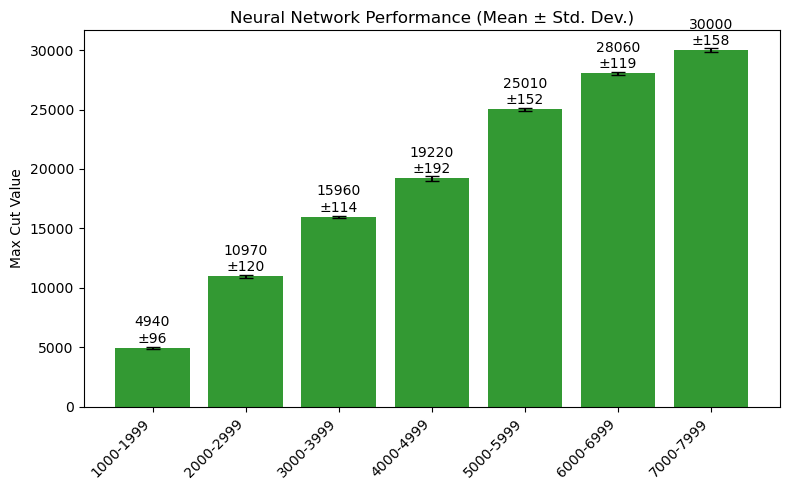

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: Suppose you have 5 runs per group
# For simplicity, let's say each group has 5 values for the NN
groups = ['1000-1999', '2000-2999', '3000-3999', '4000-4999',
          '5000-5999', '6000-6999', '7000-7999']

# Example matrix of shape (num_groups x num_runs)
nn_values = np.array([
    [4900, 5000, 5050, 4800, 4950],  # group 1
    [10800, 11100, 11050, 10900, 11000],  # group 2
    [16000, 15800, 16100, 15900, 16000],  # group 3
    [19000, 19500, 19200, 19100, 19300],  # etc.
    [25000, 25100, 24950, 25200, 24800],
    [28000, 28150, 27900, 28050, 28200],
    [30000, 29900, 30100, 30200, 29800]
])

mean_values = nn_values.mean(axis=1)
std_values = nn_values.std(axis=1, ddof=1)  # sample std; ddof=1

# Create a bar plot for the NN mean values
x_positions = np.arange(len(groups))
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x_positions, mean_values, yerr=std_values,
              align='center', alpha=0.8, capsize=5, color='green')

# Optional: add data labels (mean ± std) above bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 200,  # offset from the top
            f"{yval:.0f}\n±{std_values[i]:.0f}",
            ha='center', va='bottom', color='black')

ax.set_xticks(x_positions)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.set_ylabel('Max Cut Value')
ax.set_title('Neural Network Performance (Mean ± Std. Dev.)')
plt.tight_layout()
plt.show()


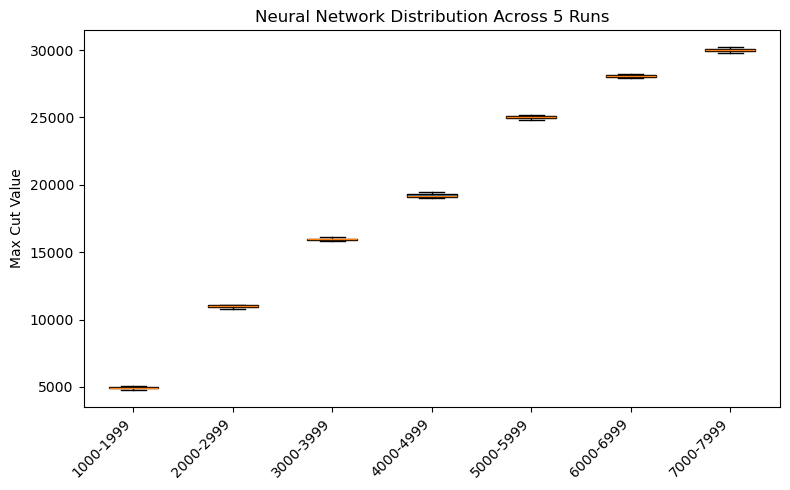

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(nn_values.T, labels=groups, patch_artist=True)

ax.set_ylabel('Max Cut Value')
ax.set_title('Neural Network Distribution Across 5 Runs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


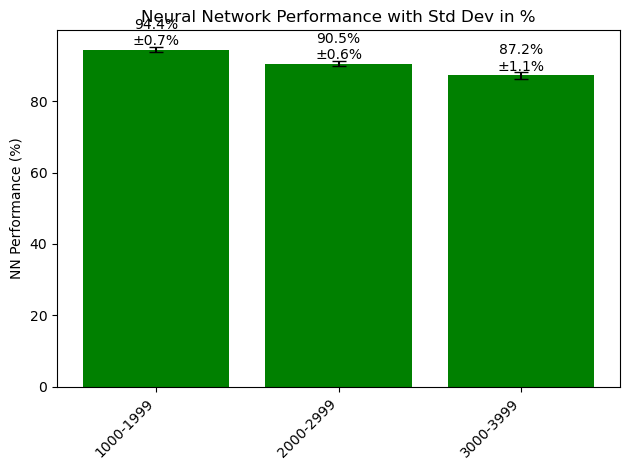

In [5]:
import numpy as np
import matplotlib.pyplot as plt

groups = ['1000-1999', '2000-2999', '3000-3999']
# Example: 3 node ranges, each with 5 runs in percent
nn_percent = np.array([
    [94.0, 93.5, 95.2, 94.1, 95.0],  # group 1
    [90.1, 91.2, 89.8, 90.5, 91.0],  # group 2
    [87.0, 88.2, 86.5, 85.9, 88.4]   # group 3
])

mean_percent = nn_percent.mean(axis=1)
std_percent = nn_percent.std(axis=1, ddof=1)

x_pos = np.arange(len(groups))
fig, ax = plt.subplots()

bars = ax.bar(x_pos, mean_percent, yerr=std_percent, capsize=5, color='green')
ax.set_xticks(x_pos)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.set_ylabel('NN Performance (%)')
ax.set_title('Neural Network Performance with Std Dev in %')

# Optional: label each bar with “mean ± std”
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
            f"{height:.1f}%\n±{std_percent[i]:.1f}%",
            ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()


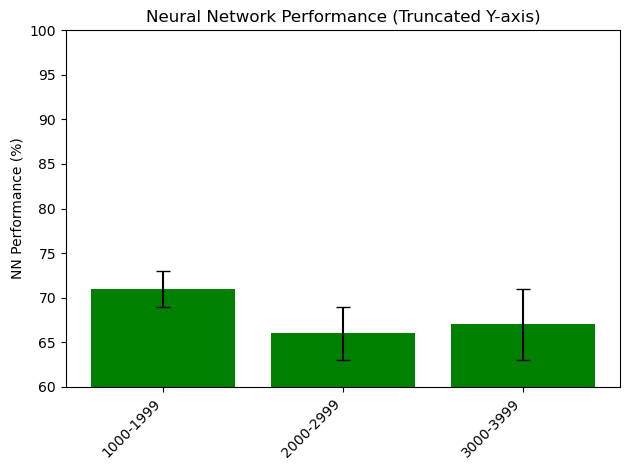

In [6]:
import numpy as np
import matplotlib.pyplot as plt

groups = ['1000-1999', '2000-2999', '3000-3999']
mean_percent = np.array([71, 66, 67])  # just example data
std_percent = np.array([2, 3, 4])

x_pos = np.arange(len(groups))
fig, ax = plt.subplots()

bars = ax.bar(x_pos, mean_percent, yerr=std_percent, capsize=5, color='green')

ax.set_xticks(x_pos)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.set_ylabel('NN Performance (%)')
ax.set_title('Neural Network Performance (Truncated Y-axis)')

# <<< Truncate the y-axis here >>>
ax.set_ylim(60, 100)  # Show only the range 60% to 100%

plt.tight_layout()
plt.show()
